In [1]:
import time
begin=time.time()

In [2]:
prefix = 'bdb_model_playaction_final-space-test'
offense = 'MIA'
defense = 'CLE'

In [ ]:
import os
import numpy as np # linear algebra
from numpy.matlib import repmat
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from fuzzywuzzy import fuzz
import datetime
import sklearn

#for image generation
from scipy import stats
from scipy.special import expit
import matplotlib.image as mpimg

import time
from tqdm import tqdm_notebook

import pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D
)

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

import h5py
import bdb_gameplan_space as bdb
from matplotlib.colors import ListedColormap

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
def ensure_folder_exists(folder):    
    # Check if the folder exists
    if not os.path.exists(folder):
        print(f"Folder '{folder}' does not exist. Creating it.")
        os.makedirs(folder)
    else:
        print(f"Folder '{folder}' already exists.")

In [5]:
prefix_files = os.path.join(prefix, 'files')
prefix_cnn = os.path.join(prefix, 'cnn')
prefix_list = [prefix, prefix_files, prefix_cnn]
for i in prefix_list:
    ensure_folder_exists(i)

Folder 'bdb_model_playaction_final-space-test' does not exist. Creating it.
Folder 'bdb_model_playaction_final-space-test\files' does not exist. Creating it.
Folder 'bdb_model_playaction_final-space-test\cnn' does not exist. Creating it.


In [6]:
#Motion fixed

play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'dropbackType', 'playAction']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadDropback']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadDropback'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['event'] == 'pass_forward') | (pl['event'] == 'sack') | (pl['event'] == 'qb_strip_sack')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [7]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'dropbackType', 'playAction']]
cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Everyone stays to be evaluated
cleandf = cleandf.loc[(cleandf['dropbackType'].str.contains('DESIGNED') == False) & (cleandf['dropbackType'] != 'UNKNOWN') & (cleandf['playAction'] == False)].reset_index(drop=True)

In [8]:
space_dict = bdb.generateSpaces(cleandf,200,100,1)

  0%|          | 0/2637 [00:00<?, ?it/s]

In [9]:
for idx, i in enumerate(cleandf['PlayId']):
    NflId = cleandf['NflId'].iloc[idx]
    rho = space_dict[i][NflId].sum()
    cleandf.at[idx, 'Space'] = rho
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
player_space = cleandf.groupby(['NflId', 'Position']).agg({'Space':'sum', 'PlayId':'count'}).reset_index()
player_space = player_space.rename(columns = {'Space':'Space_total', 'PlayId':'Plays_total'})
player_space['Space_average'] = player_space['Space_total'] / player_space['Plays_total']
player_space.loc[(player_space['NflId'] == 46162), 'Position'] = 'SS'
player_space.loc[(player_space['NflId'] == 46199), 'Position'] = 'DE'
cleandf.loc[(cleandf['NflId'] == 46162), 'Position'] = 'SS'
cleandf.loc[(cleandf['NflId'] == 46199), 'Position'] = 'DE'
player_space.loc[(player_space['Position'] == 'FB'), 'Position'] = 'RB'
cleandf.loc[(cleandf['Position'] == 'FB'), 'Position'] = 'RB'
for idx, i in enumerate(player_space['Plays_total']):
    if i < 50:
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space_average'], 10)
        player_space.at[idx, 'Space Adj'] = ((i*player_space['Space_average'].iloc[idx]) + ((50-i)*position_adj)) / 50
    else:
        player_space.at[idx, 'Space Adj'] = player_space['Space_average'].iloc[idx]
for idx, i in enumerate(player_space['Plays_total']):
    position_max = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Adj'].max()
    player_space.at[idx, 'Space Factor'] = player_space['Space Adj'].iloc[idx] / position_max

In [11]:
del cleandf

In [12]:
#Motion fixed

play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'dropbackType', 'playAction']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadDropback']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadDropback'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [13]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
play_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['PlayId'])
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'dropbackType', 'playAction']]
cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Everyone stays to be evaluated
off_form_df = cleandf.loc[(cleandf['PossessionTeam'] == offense)].reset_index(drop=True)
def_form_df = cleandf.loc[(cleandf['DefensiveTeam'] == defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['PossessionTeam'] != offense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['DefensiveTeam'] != defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['dropbackType'].str.contains('DESIGNED') == False) & (cleandf['dropbackType'] != 'UNKNOWN') & (cleandf['playAction'] == False)].reset_index(drop=True)

In [14]:
def one_hot_enc(df2, var):
    one_hot = pd.get_dummies(df2[var])
    df2 = (df2
              .drop(var, axis=1)
              .join(one_hot)
         )
    return df2

In [15]:
## game state information for each row

plays = cleandf.groupby('PlayId').first().drop(columns=['Team', 'X', 'Y', 'Dir', 'NflId', 'PossessionTeam',
                                                        'ToLeft', 'IsOnOffense', 'BallCarrier', 'HomeTeamAbbr',
                                                       'VisitorTeamAbbr', 'PlayDirection', 'YardLine', 
                                                       'A', 'S', 'FieldPosition',
                                                       'Dis', 'GameId', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay'])
# one-hot categoricals
plays = one_hot_enc(plays, 'OffenseFormation')
di = {"outdoor":1, "indoor":0, "artificial":1, "natural":0, "home":1, "away":0}
plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})
di = {1:"D1", 2:"D2", 3:"D3", 4:"D4"}
plays = plays.replace({'Down':di})
plays = one_hot_enc(plays, 'Down')
di = {1:"Q1", 2:"Q2", 3:"Q3", 4:"Q4", 5:"OT"}
plays = plays.replace({'Quarter':di})
plays = one_hot_enc(plays, 'Quarter')

# add play id back to groupby dataframe
pids = plays.index.tolist()
plays['PlayId'] = pids

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\3665325619.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})


In [16]:
def generateImages(df,nx,ny,alpha):
    plays = df.groupby('PlayId')
    nPlays = plays.ngroups
    playDict = {}
    
    xg = np.linspace(0,100,nx)
    yg = np.linspace(0,53.3,ny)
    x, y = np.meshgrid(xg,yg)
    grid = np.stack((x, y), axis=-1)
    
    
    for playId, playData in tqdm_notebook(plays):
        playDensities = makeFields(playData,grid)
        playTensor = makeTensor(playDensities,alpha)
        if np.isnan(playTensor).any():
            print(playId)
        playDict[playId] = playTensor
        
    return playDict

def makeTensor(rho,alpha):
    #alpha should be in the range [1e-3, 1e2]
    #dens_list[0] = defense
    #dens_list[1] = offense
    #dens_list[2] = ball carrier
    
    rho_def = rho[0]/np.max(rho[0])*127
    rho_off = rho[1]/np.max(rho[1])*127
    rho_bc = rho[2]/np.max(rho[2])*127
    rho_comp = (expit(alpha*(rho_off-rho_def)))*127
    playTensor = np.stack([rho_def,rho_off,rho_comp], axis = -1)
    playTensor = playTensor.astype('int8')
    #converting to int8 to save memory
    
    return playTensor

def makeFields(df,grid): 
    ny, nx, _ = grid.shape
    rho_def = np.zeros((ny,nx))
    rho_off = np.zeros((ny,nx))
    rho_bc = np.zeros((ny,nx))
    
    
    for _, row in df.iterrows():
        pos = [row['X'],53.3 - row['Y']]
        spe = row['S']
        ori = row['Dir']
        
        if np.isnan(ori):
            ori = 0
            
        rho = dens(pos,spe,ori,grid)
   
        if row['IsOnOffense']:
            rho_off += rho
            if row['BallCarrier']:
                rho_bc += rho
        else:
            rho_def += rho
            
    return [rho_def,rho_off,rho_bc]

def dens(pos,spe,ori,grid):
    #need to convert units on parameters and estimate proper values for football vs. soccer
    roc = 4
    srat = spe**2/13**2
    
    R = np.array([[np.cos(ori),-np.sin(ori)], [np.sin(ori),np.cos(ori)]])
    S2 = np.array([[((roc-roc*srat)/2)**2,0],[0,((roc+roc*srat)/2)**2+1e-8]])
    sigma = np.matmul(np.matmul(R,S2),np.transpose(R))
    mu = (pos[0]+spe*np.cos(ori)*0.5, pos[1]+spe*np.sin(ori)*0.5)
    
    return stats.multivariate_normal.pdf(grid, mean = mu, cov = sigma)

In [17]:
image_dict = generateImages(cleandf,200,100,1)

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/2716 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


In [18]:
def create_cnn(height, width, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
            filt = (5,5)
        else:
            filt = (3,3)
        # CONV => RELU => BN => POOL
        
        x = Conv2D(f, filt, padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = BatchNormalization()(x)
    
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, imageDim=(100,200),
                 nChannels = 3, gsDim = 34, shuffle=True):
        'Initialization'
        self.imageDim = imageDim
        self.gsDim = gsDim
        self.nChannels = nChannels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        Xim, yardage = self.__data_generation(list_IDs_temp)

        return Xim, yardage

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        Xim = np.empty((self.batch_size, *self.imageDim, self.nChannels))
        #Xgs = np.empty((self.batch_size, self.gsDim))
        yardage = np.empty((self.batch_size,199), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            temp = np.load(prefix + '/files/image' + str(int(ID)) + '.npy')
            Xim[i,] = temp.astype('float')/128.
            #Xgs[i,] = np.load(prefix + '/files/gameState' + str(int(ID)) + '.npy')
            
            # Store output
            yardage_temp = np.load(prefix + '/files/yardage' + str(int(ID)) + '.npy')
            yardage_temp_adj = []
            pl = 0
            for j in yardage_temp[0]:
                if (j == 1) & (pl == 0):
                    yardage_temp_adj.append(1)
                    pl+=1
                else:
                    yardage_temp_adj.append(0)
            yardage_temp_adj = np.array(yardage_temp_adj)
            yardage[i,] = yardage_temp_adj
            
        return Xim, yardage  # Return a tuple instead of a list

In [20]:
plays = cleandf.groupby('PlayId').first().drop(columns=['Team', 'X', 'Y', 'Dir', 'NflId', 'PossessionTeam', 'DefensiveTeam',
                                                        'ToLeft', 'IsOnOffense', 'BallCarrier', 'HomeTeamAbbr',
                                                       'VisitorTeamAbbr', 'PlayDirection', 'YardLine', 
                                                       'A', 'S', 'FieldPosition',
                                                       'Dis', 'GameId', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay'])
# one-hot categoricals
plays = one_hot_enc(plays, 'OffenseFormation')
di = {"outdoor":1, "indoor":0, "artificial":1, "natural":0, "home":1, "away":0}
plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})
di = {1:"D1", 2:"D2", 3:"D3", 4:"D4"}
plays = plays.replace({'Down':di})
plays = one_hot_enc(plays, 'Down')
di = {1:"Q1", 2:"Q2", 3:"Q3", 4:"Q4", 5:"OT"}
plays = plays.replace({'Quarter':di})
plays = one_hot_enc(plays, 'Quarter')

# add play id back to groupby dataframe
pids = plays.index.tolist()
plays['PlayId'] = pids

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\4096794483.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})


In [21]:
del plays['Position']
del plays['dropbackType']
del plays['playAction']

In [26]:
for idx, i in enumerate(plays.columns):
    if i == 'Yards':
        yard_var = idx
        break

for idx, i in enumerate(plays.columns):
    if i == 'expectedPointsAdded':
        epa_var = idx
        break

playMat = plays.to_numpy()
playMat = playMat.astype('float')
nanInd = np.argwhere(np.isnan(playMat))
playMat[nanInd[:,0],nanInd[:,1]] = np.zeros((1,1))
gs = playMat

yards = gs[:,yard_var]
pids = gs[:,-1].astype('int64')
    
gs[:,7] = (100-gs[:,7])/100.
        
gs = gs.astype('float')
gsTrain, gsTV = train_test_split(gs,train_size = 0.7)
gsVal, gsTest = train_test_split(gsTV, test_size = 0.5)

yardsTrain = gsTrain[:,yard_var]
pidTrain = gsTrain[:,-1]
gsTrain = np.delete(gsTrain, -1, axis=1)
gsTrain = np.delete(gsTrain, yard_var, axis=1)

yardsTest = gsTest[:,yard_var]
pidTest = gsTest[:,-1]
gsTest = np.delete(gsTest, -1, axis=1)
gsTest = np.delete(gsTest, yard_var, axis=1)

yardsVal = gsVal[:,yard_var]
pidVal = gsVal[:,-1]
gsVal = np.delete(gsVal, -1, axis=1)
gsVal = np.delete(gsVal, yard_var, axis=1)

In [27]:
def saveToFile(gameStates,yards,playIds,imageDict, prefix):
    n = gameStates.shape[0]
    print('Saving files for each play...')
    for ii in tqdm_notebook(range(n)):
        gameState = gameStates[ii,:]
        y = int(yards[ii]) 
        yvec = np.concatenate((np.zeros((1,y+99)),np.ones((1,100-y))), axis = 1)
        
        playId = playIds[ii]
        image = imageDict[playId]
        
        np.save(prefix + '/files/gameState'+str(playId)+'.npy',gameState)
        np.save(prefix + '/files/image'+str(playId)+'.npy',image)
        np.save(prefix + '/files/yardage'+str(playId)+'.npy',yvec)
        
    return 

def splitGS(gs, yard_var, epa_var):
    n = gs.shape[0]
    yards = gs[:,yard_var]
    pids = gs[:,-1].astype('int64')
    
    gs = np.delete(gs, -1, axis=1)
    gs = np.delete(gs, yard_var, axis=1)
    gs = np.delete(gs, epa_var, axis=1)
    gs[:,7] = (100-gs[:,7])/100.
        
    gs = gs.astype('float')
    return gs, yards, pids

In [30]:
gs, y, pids = bdb.splitGS(playMat, yard_var, epa_var)
saveToFile(gs,y,pids,image_dict, prefix)

temp = list(pids)
np.save(prefix + '/PlayIds.npy',temp)

Saving files for each play...


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\2254489092.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm_notebook(range(n)):


  0%|          | 0/2716 [00:00<?, ?it/s]

In [31]:
batch_size = 64
gsDim = 20
training_generator = DataGenerator(
    pidTrain, 
    batch_size = batch_size)
validation_generator = DataGenerator(
    pidVal, 
    batch_size = batch_size)
testing_generator = DataGenerator(
    pidTest, 
    batch_size = batch_size)

In [32]:
cnn = create_cnn(100, 200, 3)

x = cnn.output

x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Dense(199, activation="softmax")(x)

model = Model(inputs=cnn.input, 
              outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 200, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 50, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 25, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19200)          │        76,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    19,661,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 20,001,575 (76.30 MB)

 Trainable params: 19,959,847 (76.14 MB)

 Non-trainable params: 41,728 (163.00 KB)

In [33]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath=prefix + 'combinedWeights.hdf5.keras', verbose=1, save_best_only=False)

es = EarlyStopping(monitor='val_loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=11)
es.set_model(model)

lr = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,
                       patience=5,
                       verbose=1,
                       mode='min',
                       min_delta=0.00001)

history = model.fit(training_generator,
                   validation_data = validation_generator,
                   epochs = 100,
                   callbacks = [es, lr, checkpointer],
                   verbose = 1)

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.0136 - loss: 5.8913
Epoch 1: saving model to bdb_model_playaction_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0136 - loss: 5.8890 - val_accuracy: 0.2292 - val_loss: 5.0750 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.0299 - loss: 5.5559
Epoch 2: saving model to bdb_model_playaction_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 612ms/step - accuracy: 0.0304 - loss: 5.5526 - val_accuracy: 0.2474 - val_loss: 4.8127 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.0731 - loss: 5.1987
Epoch 3: saving model to bdb_model_playaction_final-space-testcombinedWeights.hdf5.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 571ms/step - accuracy: 0.0734 - loss: 5.1969 - val_accuracy: 0.2578 - val_loss: 4.5410 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


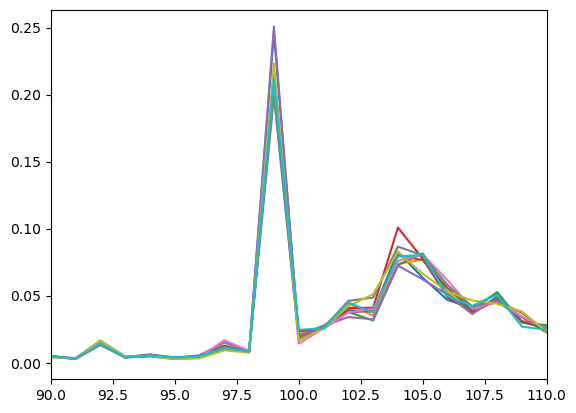

In [34]:
#Epochs = 2
for i in range(0, 10):
    PlayId1 = pidTest[i]
    gs1 = np.load(prefix + '/files/gameState' + str(int(PlayId1)) + '.npy')
    im1 = np.load(prefix + '/files/image' + str(int(PlayId1)) + '.npy')/128.
    y1 = np.load(prefix + '/files/yardage' + str(int(PlayId1)) + '.npy')
    dist1 = model.predict(im1.reshape((1, 100, 200, 3)))
    plt.plot(dist1.reshape(-1,))
    plt.xlim([90,110])

In [35]:
#Offense Cleaning
total_form_df = pd.concat([off_form_df, def_form_df]).reset_index(drop=True)
play_df = pd.DataFrame()
playlist = list(total_form_df['PlayId'].drop_duplicates())
for idx, i in enumerate(playlist):
    pl = total_form_df.loc[(total_form_df['PlayId'] == i)].reset_index(drop=True)
    pl = pl.loc[(pl['IsOnOffense'] == True)].reset_index(drop=True)
    snap = pd.DataFrame(bdb.offense_locations(pl))
    snap = snap.iloc[5:, :].reset_index(drop=True)
    for jdx, j in enumerate(snap['NflId']):
        if (j in list(pl['NflId'])):
            pl2 = pl.loc[(pl['PlayId'] == i) & (pl['NflId'] == j)].reset_index(drop=True)
            play_df = pd.concat([play_df, pl2]).reset_index(drop=True)

offense_formation_dict = bdb.generateFormationImages(play_df,200,100,1)
np.save(prefix + '/offense_formation_dict.npy',offense_formation_dict)

  0%|          | 0/520 [00:00<?, ?it/s]

17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 20, Silhouette score: 0.2314
Number of clusters: 21, Silhouette score: 0.2481
Number of clusters: 22, Silhouette score: 0.2522
Number of clusters: 23, Silhouette score: 0.2520
Number of clusters: 24, Silhouette score: 0.2469
Number of clusters: 25, Silhouette score: 0.2458
Number of clusters: 26, Silhouette score: 0.2407
Number of clusters: 27, Silhouette score: 0.2385


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 28, Silhouette score: 0.2353
Number of clusters: 29, Silhouette score: 0.2336
Number of clusters: 30, Silhouette score: 0.2360
Number of clusters: 31, Silhouette score: 0.2353


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 32, Silhouette score: 0.2371
Number of clusters: 33, Silhouette score: 0.2485
Number of clusters: 34, Silhouette score: 0.2572
Number of clusters: 35, Silhouette score: 0.2536


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 36, Silhouette score: 0.2493
Number of clusters: 37, Silhouette score: 0.2508
Number of clusters: 38, Silhouette score: 0.2542
Number of clusters: 39, Silhouette score: 0.2342


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 40, Silhouette score: 0.2332
Number of clusters: 41, Silhouette score: 0.2343
Number of clusters: 42, Silhouette score: 0.2325
Number of clusters: 43, Silhouette score: 0.2347


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 44, Silhouette score: 0.2373
Number of clusters: 45, Silhouette score: 0.2365
Number of clusters: 46, Silhouette score: 0.2391


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Number of clusters: 47, Silhouette score: 0.2400
Number of clusters: 48, Silhouette score: 0.2431
Number of clusters: 49, Silhouette score: 0.2447


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


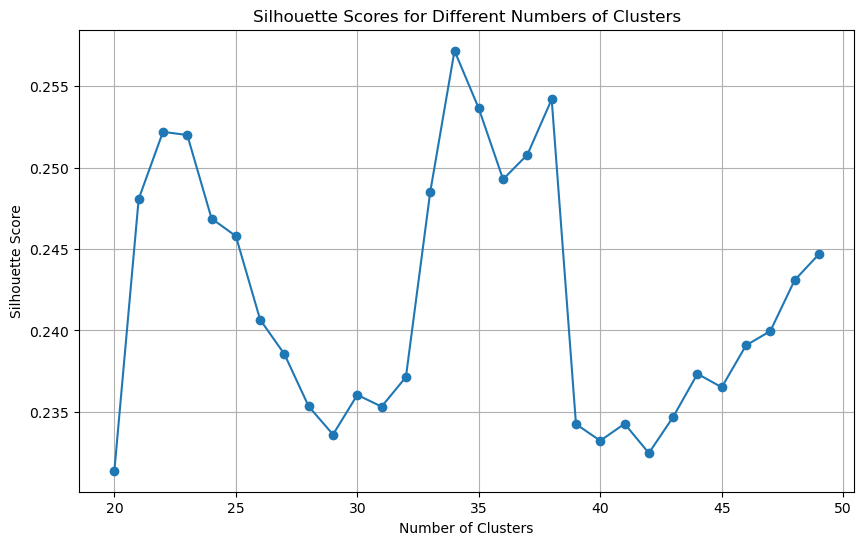

Optimal Number of Clusters: 34


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [36]:
#Finding all offensive formation plays
form_dict = {}
for i in offense_formation_dict.keys():
    if (i in playlist):
        form_dict[i] = offense_formation_dict[i]
images = np.array(list(form_dict.values()))
clustering = bdb.KMeansClusteringWithVGG16(min_clusters=20, max_clusters=50)#len(images)-1)
labels = clustering.fit(images)
league_dict = {'PlayId':[], 'Label':[], 'Team':[]}
for idx, label in enumerate(labels):
    # Assuming you want to store the labels in the same dict
    league_dict['PlayId'].append(list(form_dict.keys())[idx])
    league_dict['Label'].append(label)
    league_dict['Team'].append(play_df.loc[(play_df['PlayId'] == list(form_dict.keys())[idx])]['PossessionTeam'].iloc[0])
leaguedf = pd.DataFrame(league_dict)
leaguedf.loc[(leaguedf['Team'] != offense), 'Team'] = defense

In [37]:
#Finding shared formations between offense and ones defense has faced
ldf = leaguedf.drop_duplicates(subset = ['Label', 'Team'], keep = 'first').reset_index(drop=True)
labels = list(leaguedf.drop_duplicates(subset = 'Label')['Label'])
reciprocated_labels = []
for i in labels:
    if (len(ldf.loc[(ldf['Label'] == i)]) > 1):
        reciprocated_labels.append(i)

In [38]:
for idx, i in enumerate(off_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == off_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        off_form_df.at[idx, 'Space Factor'] = position_adj
for idx, i in enumerate(def_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == def_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        def_form_df.at[idx, 'Space Factor'] = position_adj

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3030
Number of clusters: 3, Silhouette score: 0.2155


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


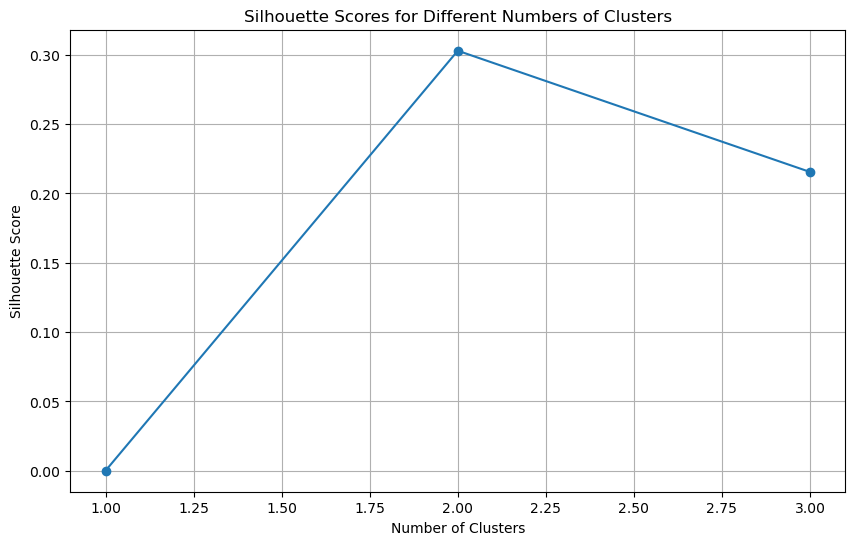

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
23


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2233


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


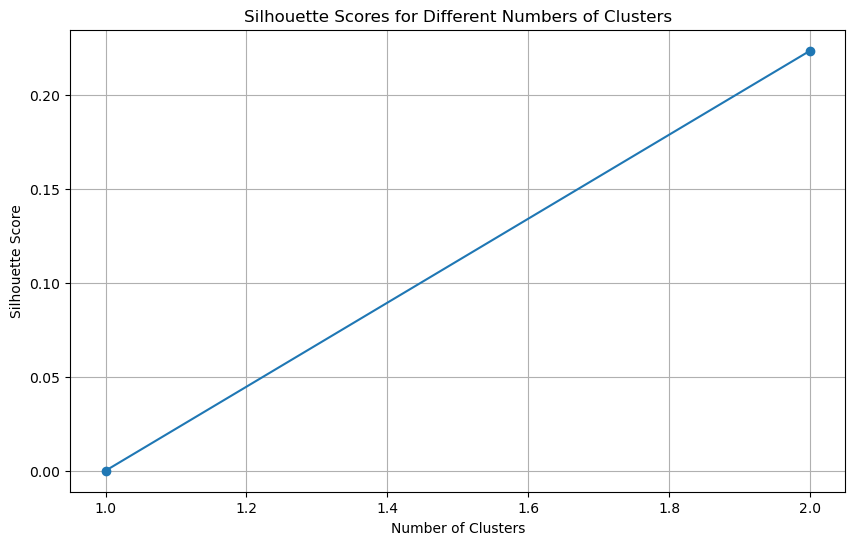

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


Optimal Number of Clusters: 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
22


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4092
Number of clusters: 3, Silhouette score: 0.3249
Number of clusters: 4, Silhouette score: 0.3649
Number of clusters: 5, Silhouette score: 0.3077
Number of clusters: 6, Silhouette score: 0.2546
Number of clusters: 7, Silhouette score: 0.1373
Number of clusters: 8, Silhouette score: 0.2206
Number of clusters: 9, Silhouette score: 0.1542


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

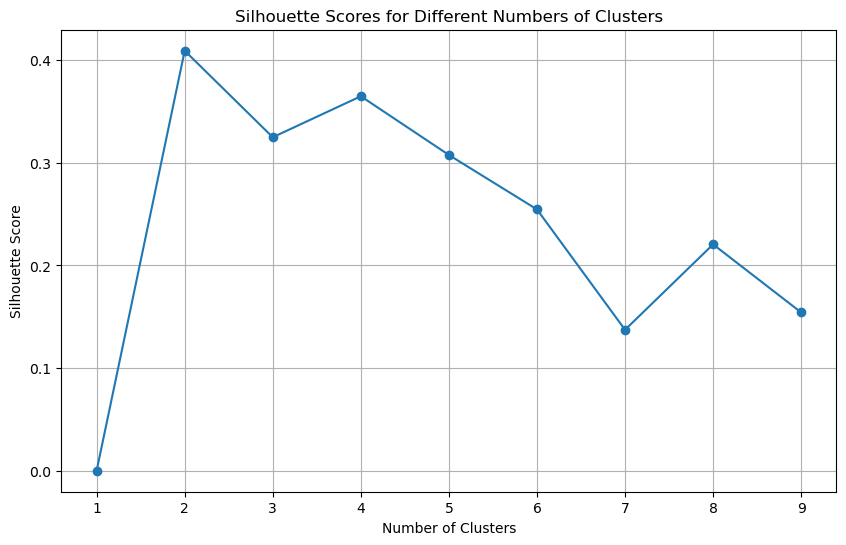

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
19


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1802
Number of clusters: 3, Silhouette score: 0.1066
Number of clusters: 4, Silhouette score: 0.1008
Number of clusters: 5, Silhouette score: 0.1269
Number of clusters: 6, Silhouette score: 0.1555
Number of clusters: 7, Silhouette score: 0.1209
Number of clusters: 8, Silhouette score: 0.1727


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

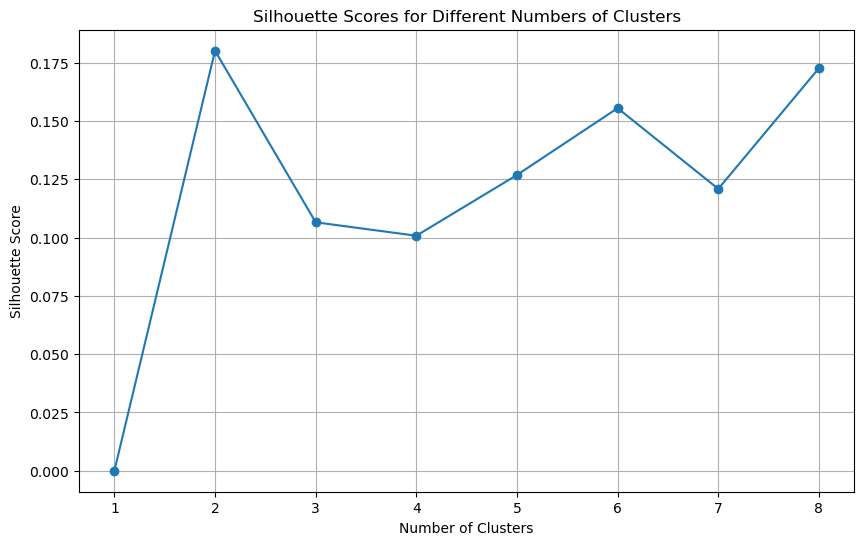

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
26


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1554
Number of clusters: 3, Silhouette score: 0.2695
Number of clusters: 4, Silhouette score: 0.2035
Number of clusters: 5, Silhouette score: 0.1846
Number of clusters: 6, Silhouette score: 0.1559
Number of clusters: 7, Silhouette score: 0.1867
Number of clusters: 8, Silhouette score: 0.1842
Number of clusters: 9, Silhouette score: 0.1418


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

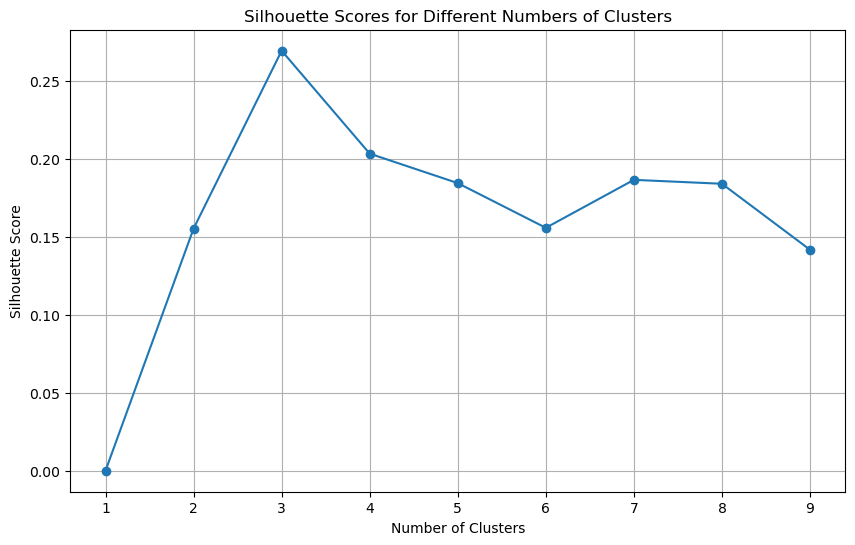

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
16


  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2745
Number of clusters: 3, Silhouette score: 0.1678
Number of clusters: 4, Silhouette score: 0.1720
Number of clusters: 5, Silhouette score: 0.2102
Number of clusters: 6, Silhouette score: 0.2128
Number of clusters: 7, Silhouette score: 0.2116
Number of clusters: 8, Silhouette score: 0.2432
Number of clusters: 9, Silhouette score: 0.2564
Number of clusters: 10, Silhouette score: 0.2455
Number of clusters: 11, Silhouette score: 0.1887
Number of clusters: 12, Silhouette score: 0.1785
Number of clusters: 13, Silhouette score: 0.1579
Number of clusters: 14, Silhouette score: 0.1707
Number of clusters: 15, Silhouette score: 0.1800
Number of clusters: 16, Silhouette score: 0.1705
Number of clusters: 17, Silhouette score: 0.1550
Number of clusters: 18, Silhouette score: 0.1385
Number of clusters: 19, Silhouette score: 0.1172
Number of clusters: 20, Silh

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 22, Silhouette score: 0.0634


Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1670
Number of clusters: 3, Silhouette score: 0.1980
Number of clusters: 4, Silhouette score: 0.1545
Number of clusters: 5, Silhouette score: 0.1575
Number of clusters: 6, Silhouette score: 0.1546
Number of clusters: 7, Silhouette score: 0.2236
Number of clusters: 8, Silhouette score: 0.1914
Number of clusters: 9, Silhouette score: 0.1839
Number of clusters: 10, Silhouette score: 0.1966
Number of clusters: 11, Silhouette score: 0.1753
Number of clusters: 12, Silhouette score: 0.1245
Number of clusters: 13, Silhouette score: 0.1106


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

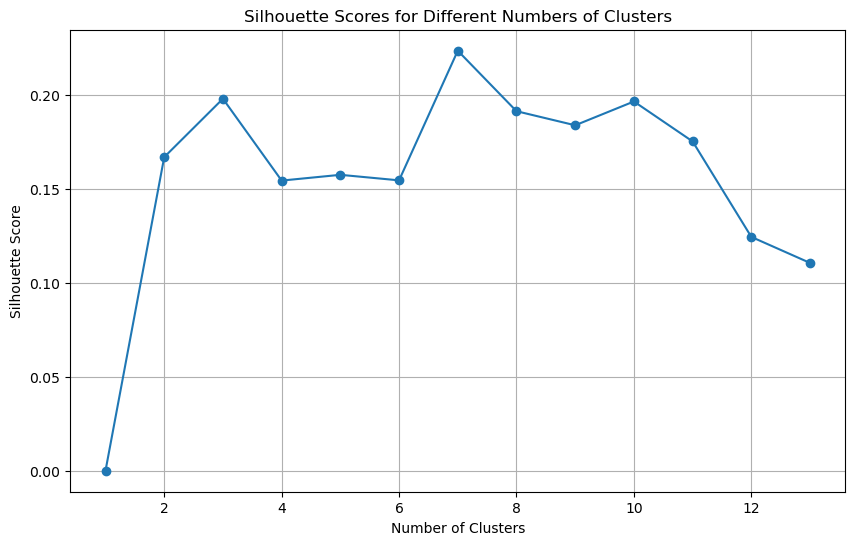

Optimal Number of Clusters: 7


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
11


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1933


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


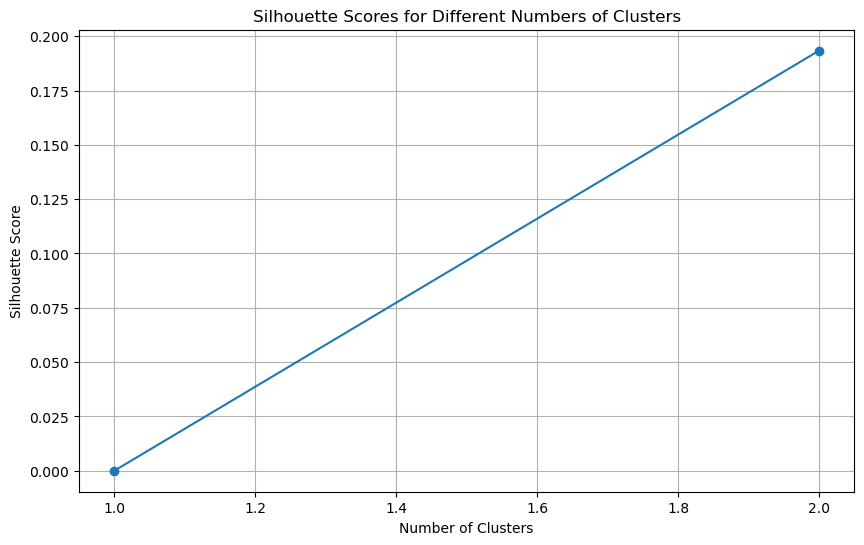

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
31


  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2803
Number of clusters: 3, Silhouette score: 0.2704
Number of clusters: 4, Silhouette score: 0.3271
Number of clusters: 5, Silhouette score: 0.2832
Number of clusters: 6, Silhouette score: 0.2919
Number of clusters: 7, Silhouette score: 0.2878
Number of clusters: 8, Silhouette score: 0.2873
Number of clusters: 9, Silhouette score: 0.2757
Number of clusters: 10, Silhouette score: 0.2625
Number of clusters: 11, Silhouette score: 0.2350
Number of clusters: 12, Silhouette score: 0.2284
Number of clusters: 13, Silhouette score: 0.1925
Number of clusters: 14, Silhouette score: 0.1563
Number of clusters: 15, Silhouette score: 0.1486
Number of clusters: 16, Silhouette score: 0.0520
Number of clusters: 17, Silhouette score: 0.0244


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

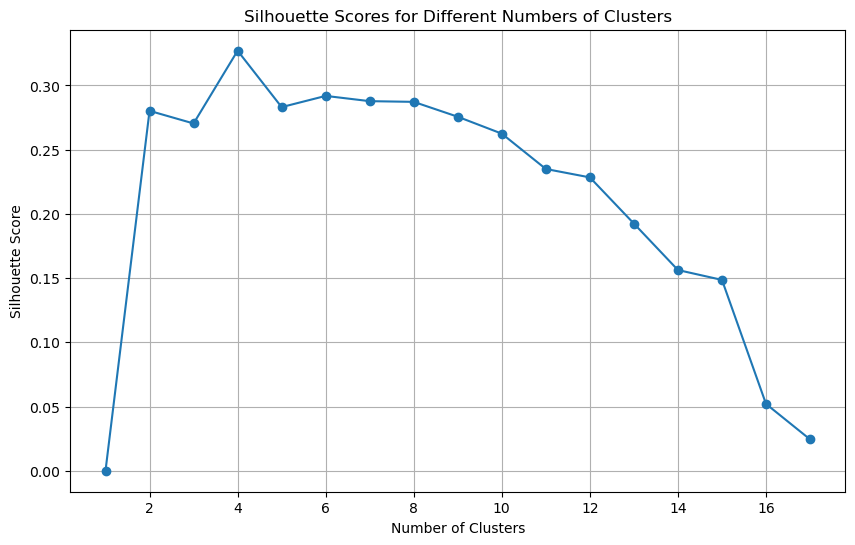

Optimal Number of Clusters: 4


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1418


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


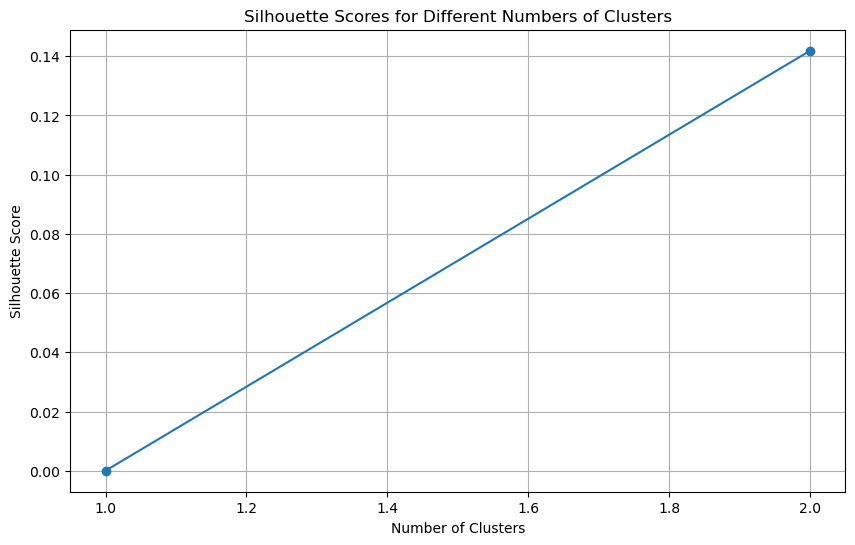

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0


  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1401
Number of clusters: 3, Silhouette score: 0.1546
Number of clusters: 4, Silhouette score: 0.1320
Number of clusters: 5, Silhouette score: 0.1360
Number of clusters: 6, Silhouette score: 0.1087
Number of clusters: 7, Silhouette score: 0.1411
Number of clusters: 8, Silhouette score: 0.1981
Number of clusters: 9, Silhouette score: 0.1781
Number of clusters: 10, Silhouette score: 0.1594
Number of clusters: 11, Silhouette score: 0.1221
Number of clusters: 12, Silhouette score: 0.0592


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

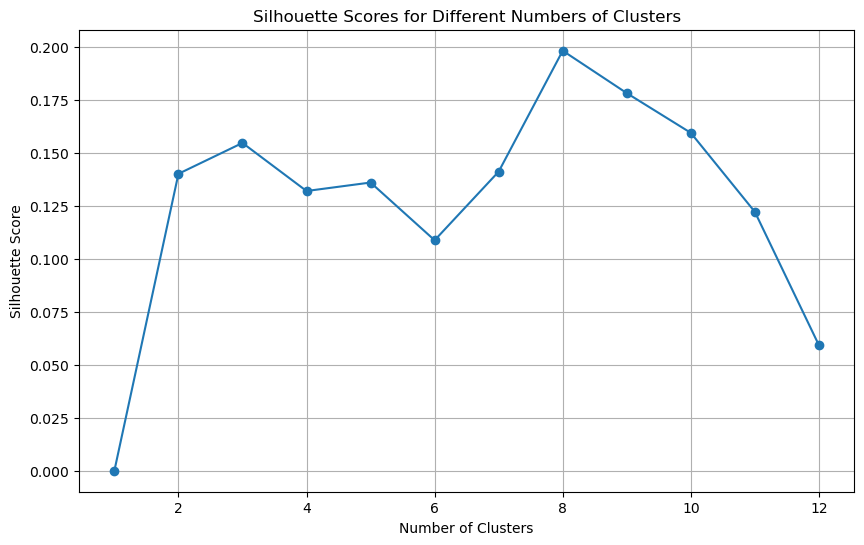

Optimal Number of Clusters: 8


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
5


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
28


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3829
Number of clusters: 3, Silhouette score: 0.2280
Number of clusters: 4, Silhouette score: 0.2083
Number of clusters: 5, Silhouette score: 0.0177
Number of clusters: 6, Silhouette score: 0.0906


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

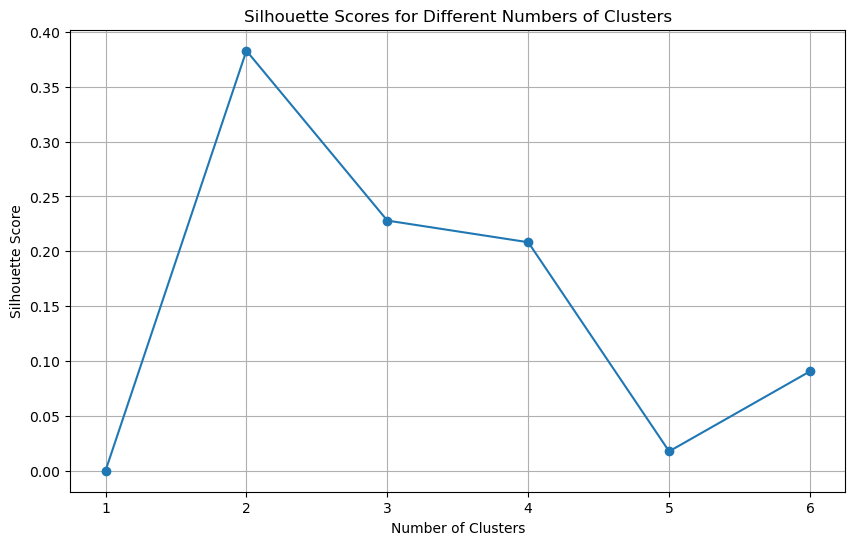

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
12


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2743
Number of clusters: 3, Silhouette score: 0.3218
Number of clusters: 4, Silhouette score: 0.2916


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


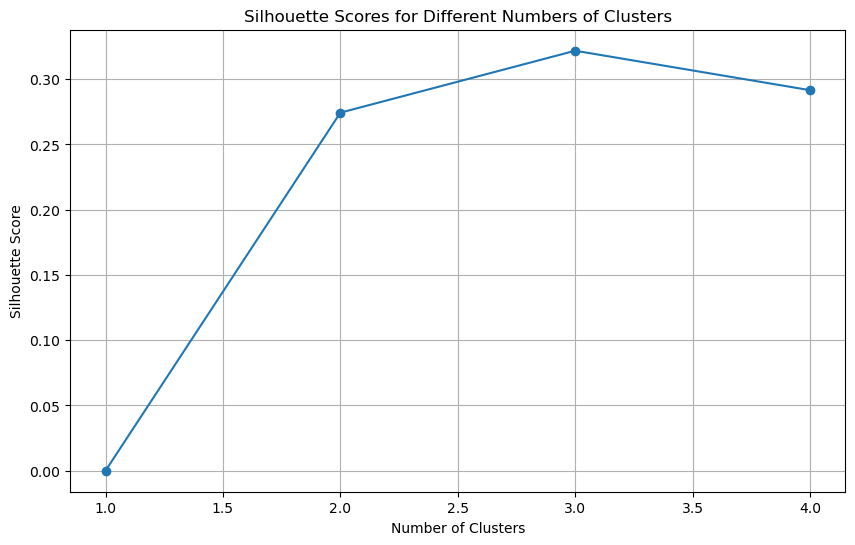

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.0805


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


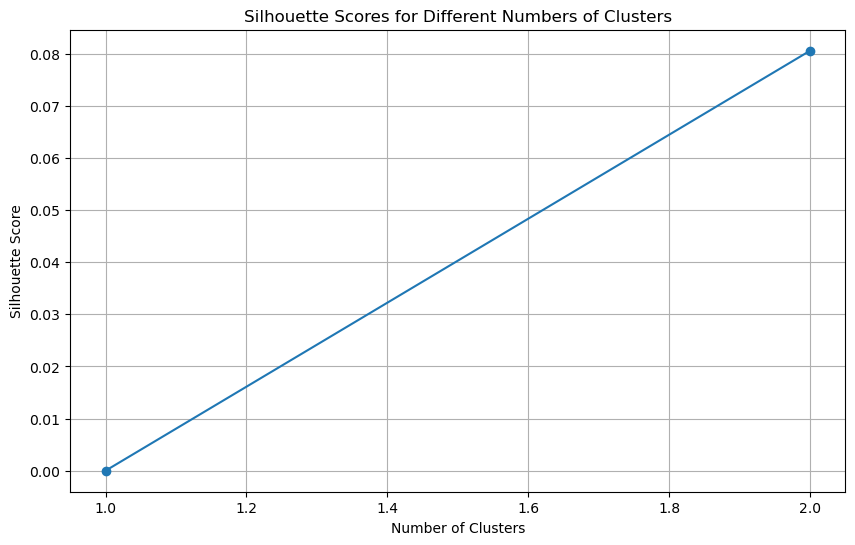

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
20


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2498
Number of clusters: 3, Silhouette score: 0.1820


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


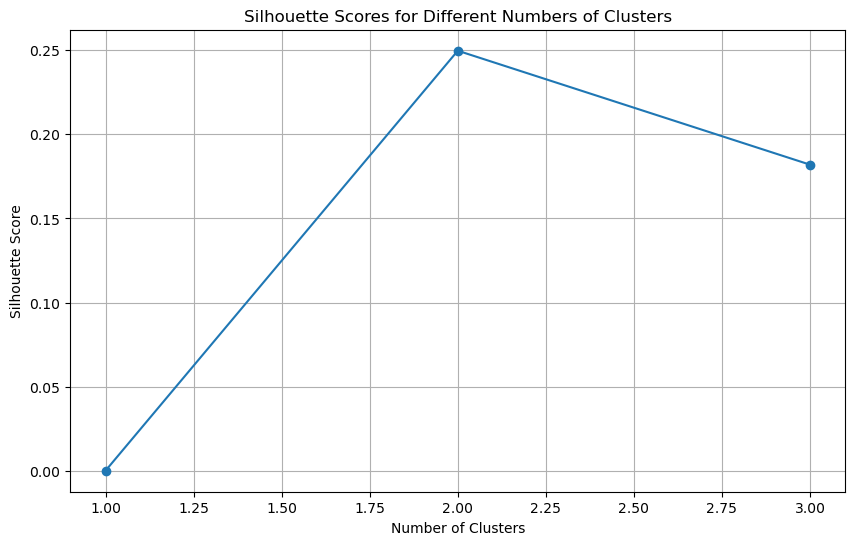

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
18


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.5158
Number of clusters: 3, Silhouette score: 0.4680
Number of clusters: 4, Silhouette score: 0.4489
Number of clusters: 5, Silhouette score: 0.1994
Number of clusters: 6, Silhouette score: 0.1810
Number of clusters: 7, Silhouette score: 0.1241


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

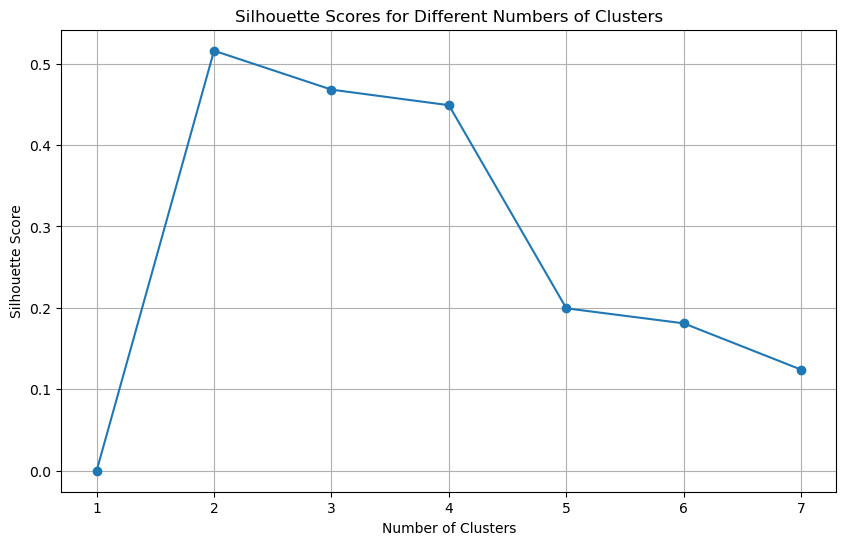

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
24


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


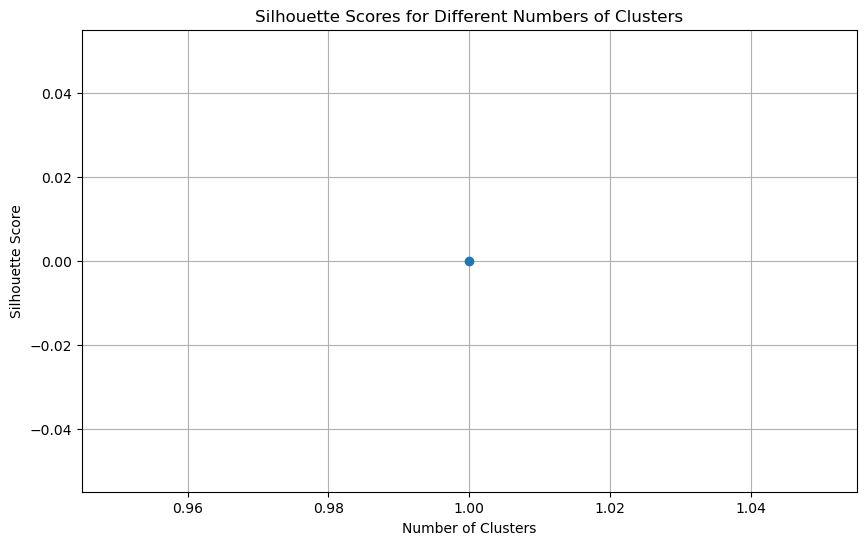

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
30


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


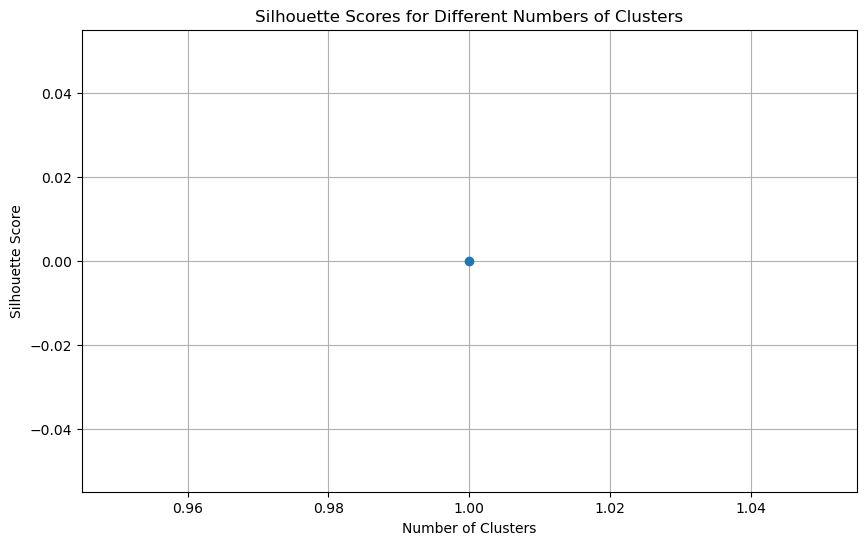

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


33


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2873
Number of clusters: 3, Silhouette score: 0.1514
Number of clusters: 4, Silhouette score: 0.1947
Number of clusters: 5, Silhouette score: 0.2160


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

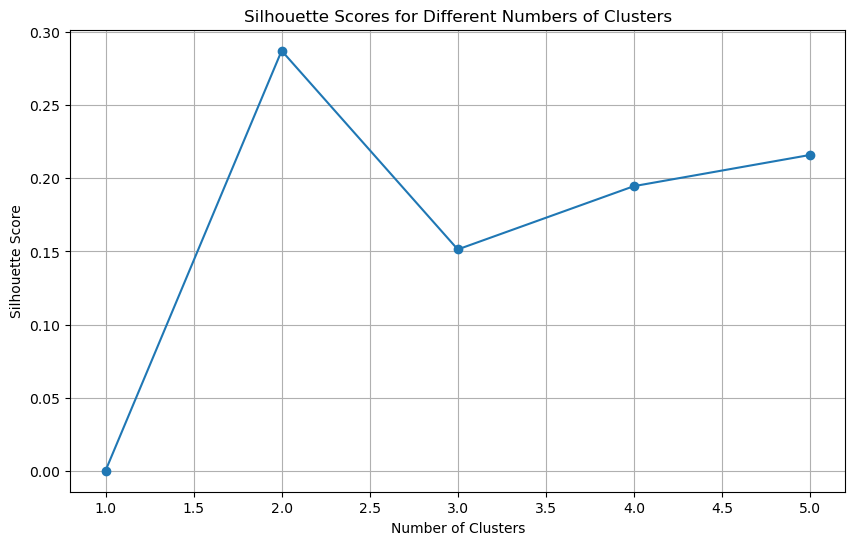

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
17


  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2914
Number of clusters: 3, Silhouette score: 0.1859
Number of clusters: 4, Silhouette score: 0.1156


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


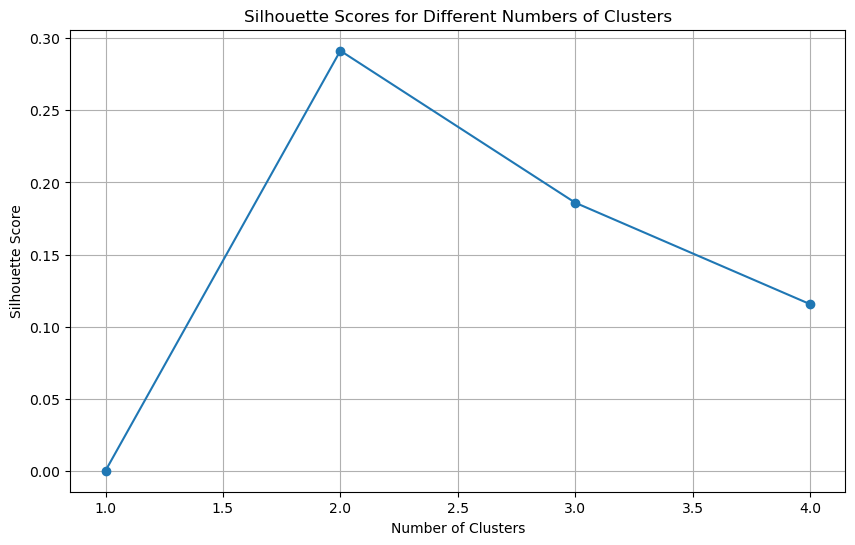

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
10


  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3362
Number of clusters: 3, Silhouette score: 0.1818
Number of clusters: 4, Silhouette score: 0.2906
Number of clusters: 5, Silhouette score: 0.2210
Number of clusters: 6, Silhouette score: 0.3266
Number of clusters: 7, Silhouette score: 0.4058
Number of clusters: 8, Silhouette score: 0.3444
Number of clusters: 9, Silhouette score: 0.3301
Number of clusters: 10, Silhouette score: 0.2941
Number of clusters: 11, Silhouette score: 0.2274
Number of clusters: 12, Silhouette score: 0.1979


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

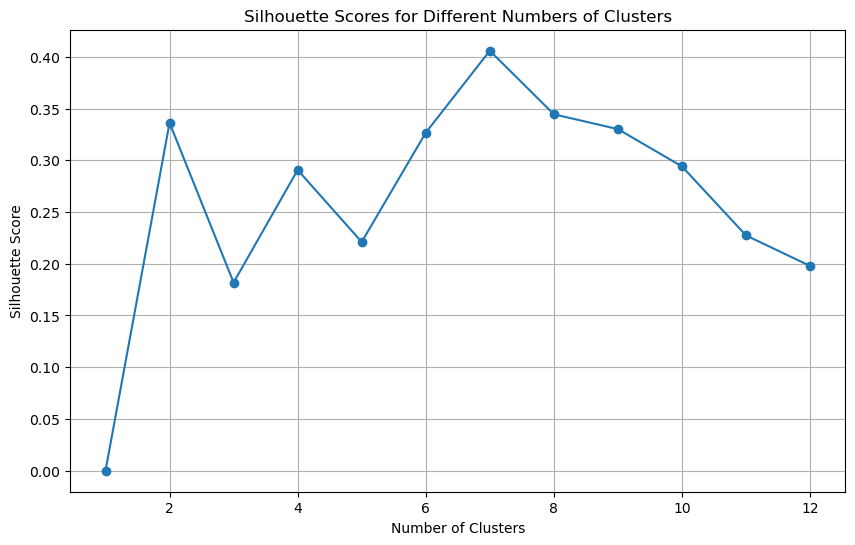

Optimal Number of Clusters: 7


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2659
Number of clusters: 3, Silhouette score: 0.1712
Number of clusters: 4, Silhouette score: 0.1667
Number of clusters: 5, Silhouette score: 0.1598
Number of clusters: 6, Silhouette score: 0.1232


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

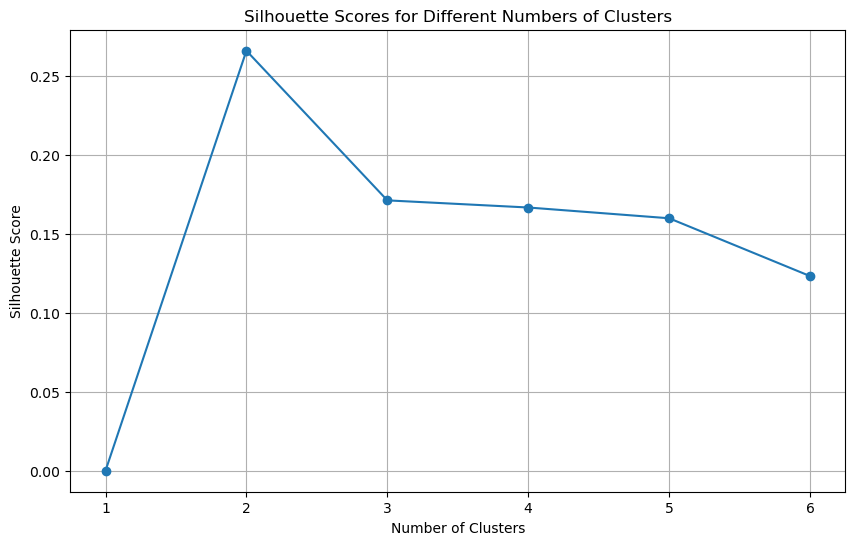

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


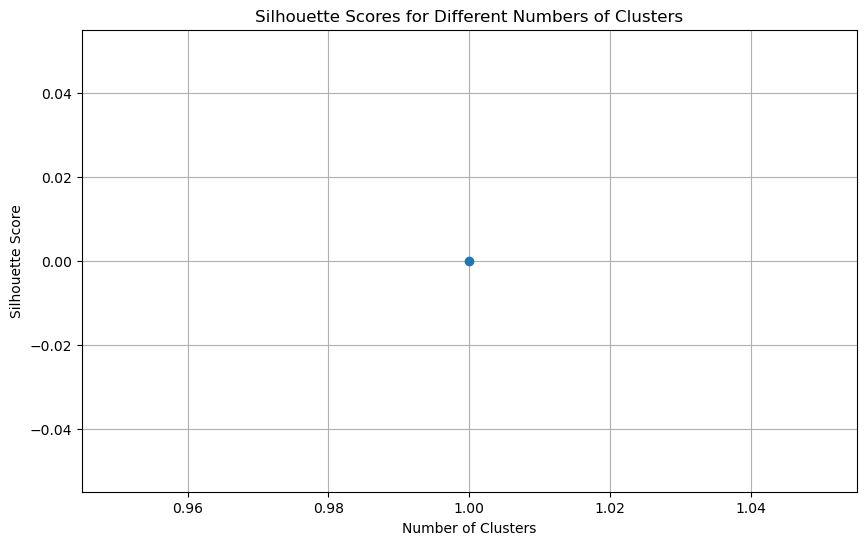

Optimal Number of Clusters: 1


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
9


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3499


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


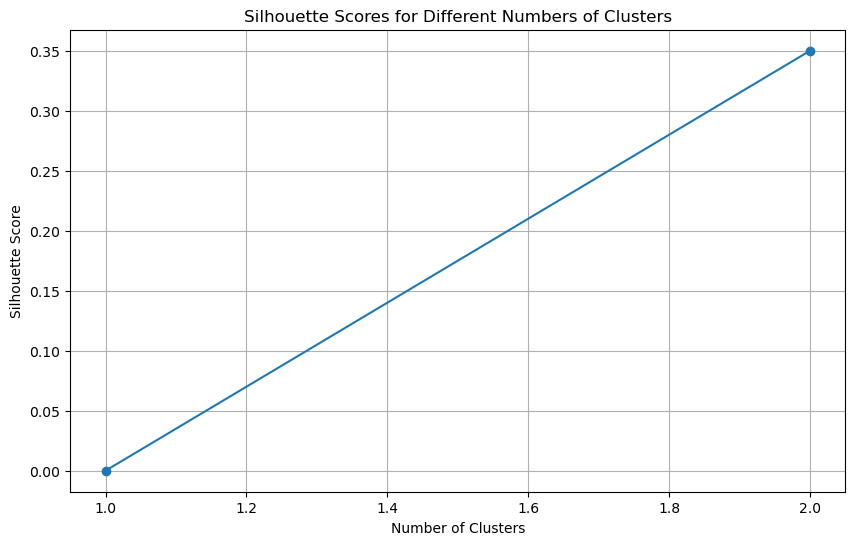

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


Optimal Number of Clusters: 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
14


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4020
Number of clusters: 3, Silhouette score: 0.2510
Number of clusters: 4, Silhouette score: 0.3262
Number of clusters: 5, Silhouette score: 0.2753
Number of clusters: 6, Silhouette score: 0.1613


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

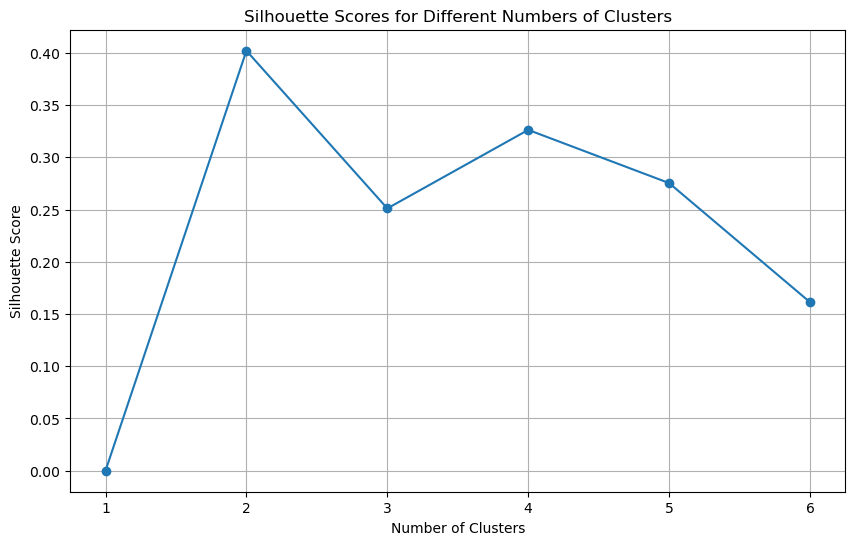

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
27


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.6439


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


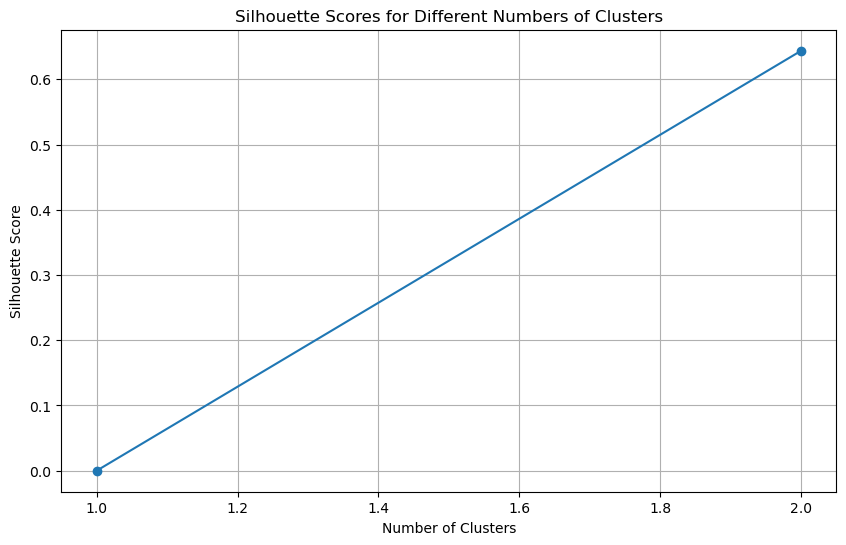

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal Number of Clusters: 2


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:29: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4742
Number of clusters: 3, Silhouette score: 0.2977
Number of clusters: 4, Silhouette score: 0.2425
Number of clusters: 5, Silhouette score: 0.2963
Number of clusters: 6, Silhouette score: 0.1776


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

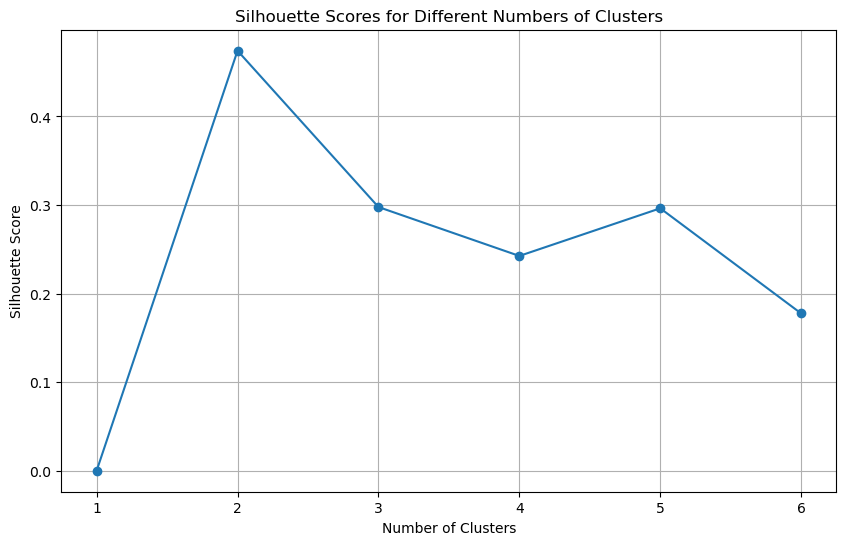

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_28940\326425815.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2


In [39]:
#Clustering all the defensive looks against each reciprocated formation
defensive_clustering = pd.DataFrame()
predict_dict = {'PlayId':[], 'O_Label':[], 'D_Label':[], 'Count':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
drawings_dict = {}
predicted_plays = pd.DataFrame()
weights = np.linspace(-99, 99, 199)
ooo = 0
oo = pd.DataFrame()
#pmf multiplication is just times they happen added up
for i in reciprocated_labels:
    def_play_df = pd.DataFrame()
    defensive_label_df = leaguedf.loc[(leaguedf['Team'] == defense) & (leaguedf['Label'] == i)].reset_index(drop=True)
    for jdx, j in enumerate(defensive_label_df['PlayId']):
        pl = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        pl2 = pd.DataFrame()
        snap = pd.DataFrame(bdb.defense_locations(pl)).reset_index(drop=True)
        for kdx, k in enumerate(snap['NflId']):
            if (k in list(pl['NflId'])):
                pl2 = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False) & (def_form_df['NflId'] == k)].reset_index(drop=True)
                def_play_df = pd.concat([def_play_df, pl2]).reset_index(drop=True)
    #Find best offense and best of each defensive cluster, then predict
    defense_formation_dict = bdb.generateDefFormationImages(def_play_df,200,100,1)
    def_form_dict = {}
    for j in defense_formation_dict.keys():
        #if (i in playlist):
        def_form_dict[j] = defense_formation_dict[j]
    def_images = np.array(list(def_form_dict.values()))
    if len(def_images) > 2:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images)-1)
        def_labels = def_clustering.def_fit(def_images)
    elif len(def_images) > 1:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images))
        def_labels = def_clustering.def_fit(def_images)
    else:
        def_labels = np.array([0])
    def_dict = {'PlayId':[], 'Label':[], 'Team':[]}
    for idx, label in enumerate(def_labels):
        # Assuming you want to store the labels in the same dict
        def_dict['PlayId'].append(list(def_form_dict.keys())[idx])
        def_dict['Label'].append(label)
        def_dict['Team'].append(defense)
    def_df = pd.DataFrame(def_dict)
    dunique = def_form_df.drop_duplicates(subset = ['PlayId', 'expectedPointsAdded']).reset_index(drop=True)
    def_df = pd.merge(def_df, dunique[['PlayId', 'expectedPointsAdded']], how = 'left', on = 'PlayId').reset_index(drop=True)
    def_labels_deduped = np.unique(def_labels)
    #Find Offensive PlayID with Max EPA with this label
    offense_plays = list(leaguedf.loc[(leaguedf['Team'] == offense) & (leaguedf['Label'] == i)]['PlayId'])
    off_df = off_form_df.loc[(off_form_df['PlayId'].isin(offense_plays))].reset_index(drop=True)
    offense_max_pid = off_df.loc[(off_df['expectedPointsAdded'] == off_df['expectedPointsAdded'].min())]['PlayId'].iloc[0]
    offense_max = off_df.loc[(off_df['IsOnOffense'] == True) & (off_df['PlayId'] == offense_max_pid) & (off_df['PossessionTeam'] == offense)].reset_index(drop=True)
    #Find all Defensive PlayIds with Max EPA for all clusters within this label
    defense_plays = pd.DataFrame()
    for j in def_labels_deduped:
        pl = def_df.loc[(def_df['Label'] == j)].reset_index(drop=True)
        defense_min_pid = pl.loc[(pl['expectedPointsAdded'] == pl['expectedPointsAdded'].min())]['PlayId'].iloc[0]
        defense_min = def_form_df.loc[(def_form_df['PlayId'] == defense_min_pid) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        offense_max['PlayIdO'] = offense_max['PlayId']
        offense_max['PlayIdD'] = defense_min['PlayId']
        defense_min['PlayIdO'] = offense_max['PlayId']
        defense_min['PlayIdD'] = defense_min['PlayId']
        defense_min = defense_min.loc[(defense_min['DefensiveTeam'] == defense) & (defense_min['IsOnOffense'] == False)].reset_index(drop=True)
        defense_comp = pd.concat([defense_min, offense_max]).reset_index(drop=True)
        defense_comp['PlayId'] = defense_comp['PlayIdD']
        defense_comp['Count'] = len(pl)
        defense_comp['O_Label'] = i
        defense_comp['D_Label'] = j
        defense_plays = pd.concat([defense_plays, defense_comp]).reset_index(drop=True)
        outliers = defense_min.loc[(defense_min['X'] > 70) | (defense_min['X'] < 50)].reset_index(drop=True)
        oo = pd.concat([oo, outliers])
        if (len(outliers) > 0):
            ooo+=1
            break
    predicted_plays = pd.concat([predicted_plays, defense_plays]).reset_index(drop=True)
    compare_dict = generateImages(defense_plays, 200, 100, 1)
    #Fix Drawings Dict
    for jdx, j in enumerate(compare_dict.keys()):
        drawings_dict[j] = compare_dict[j]
        o_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['O_Label'].iloc[0]
        d_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['D_Label'].iloc[0]
        play_count = defense_plays.loc[(defense_plays['PlayId'] == j)]['Count'].iloc[0]
        model_prediction = model.predict(compare_dict[j].reshape(1, 100, 200, 3) / 128.)
        avg = np.sum(weights * model_prediction)
        predict_dict['PlayId'].append(j)
        predict_dict['O_Label'].append(o_label)
        predict_dict['D_Label'].append(d_label)
        predict_dict['Count'].append(play_count)
        predict_dict['Prediction'].append(model_prediction)
        predict_dict['Mean'].append(avg)
        predict_dict['Mean EPA'].append(avg * 0.135 - 0.543)
        predict_dict['Explosive_%'].append(model_prediction[0][111:].sum())
        predict_dict['Negative_%'].append(model_prediction[0][:99].sum())
    print(i)

In [40]:
predict_df = pd.DataFrame(predict_dict)

In [41]:
offensive_formations = {'O_Label':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
labels_unique = list(predict_df['O_Label'].drop_duplicates())
for idx, i in enumerate(labels_unique):
    pl = predict_df.loc[(predict_df['O_Label'] == i)].reset_index(drop=True)
    avg = (weights * pl['Prediction'].iloc[0]).sum()
    offensive_formations['O_Label'].append(i)
    offensive_formations['Prediction'].append((pl['Prediction'] * pl['Count']).sum() / pl['Count'].sum())
    offensive_formations['Mean'].append(avg)
    offensive_formations['Mean EPA'].append(avg * 0.135 - 0.543)
    offensive_formations['Explosive_%'].append(pl['Prediction'][0][0][115:].sum())
    offensive_formations['Negative_%'].append(pl['Prediction'][0][0][:99].sum())

In [42]:
ppdict = bdb.generateImages(predicted_plays, 1600, 800, 1)

  0%|          | 0/28 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


In [43]:
player_number = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025/tracking_week_' + str(i) + '.csv')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl.loc[(pl['displayName'] != 'football')].reset_index(drop=True)
    player_number = pd.concat([player_number, pl]).reset_index(drop=True)
player_number = player_number.rename(columns = {'playId':'PlayId', 'nflId':'NflId', 'jerseyNumber':'JerseyNumber'})
player_number['PlayId'] = player_number['gameId'].astype(str) + player_number['PlayId'].astype(str).str.zfill(4)
player_number['PlayId'] = player_number['PlayId'].astype('int64')
player_number = player_number[['PlayId', 'NflId', 'JerseyNumber']].reset_index(drop=True)

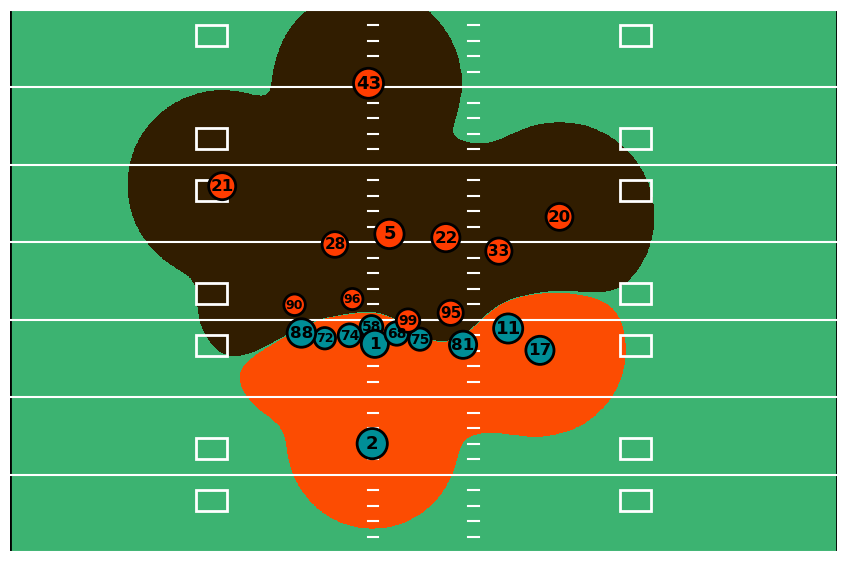

ValueError: cannot convert float NaN to integer

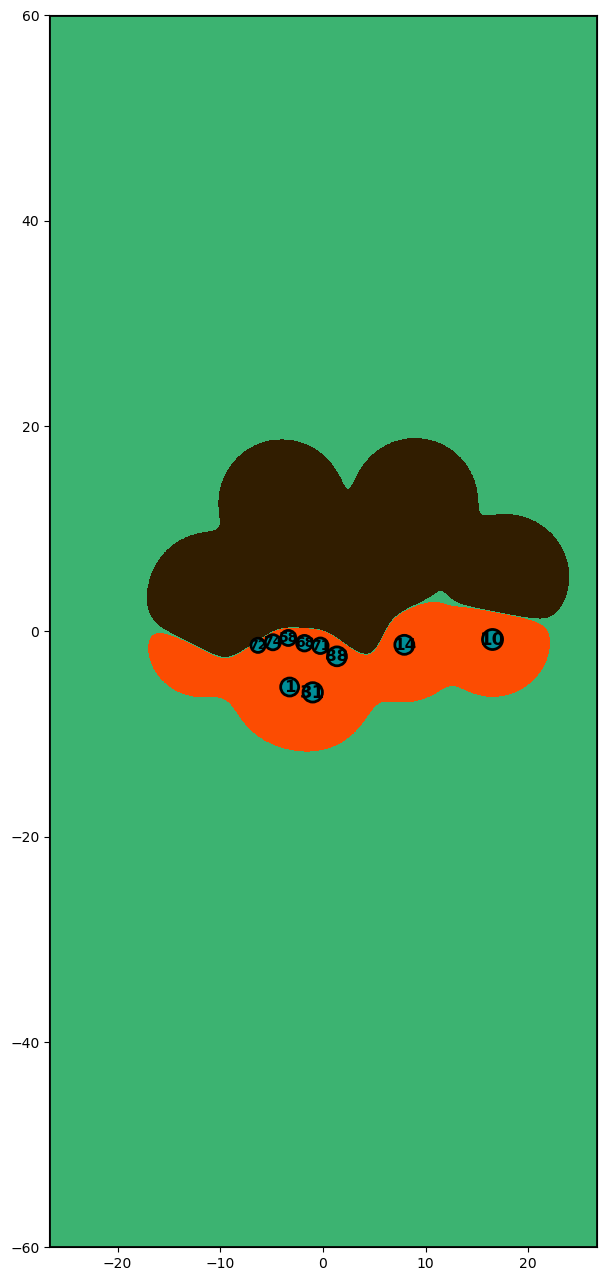

In [44]:
for hdx, h in enumerate(reciprocated_labels):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = pd.merge(snapo, player_number, how = 'left', left_on = ['PlayIdO', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + .5 * size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)   
            else:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + .5 * size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
            ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 7*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig('testfig/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [45]:
weights[114]

15.0

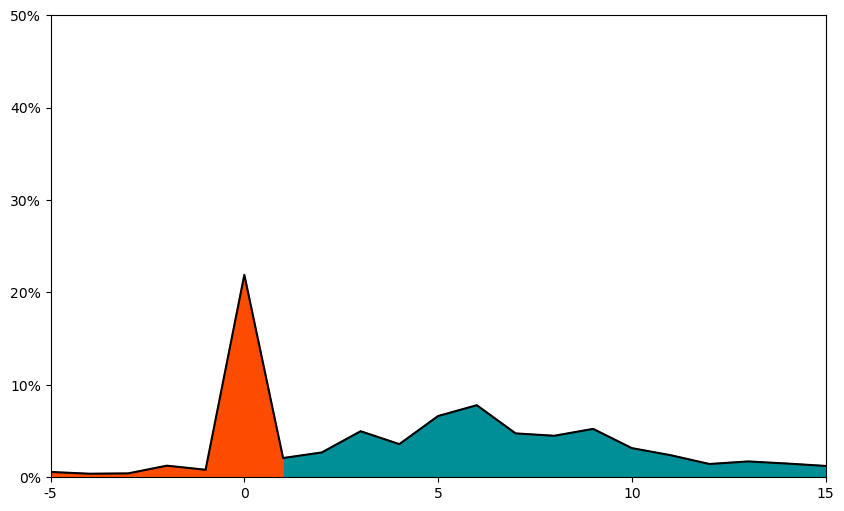

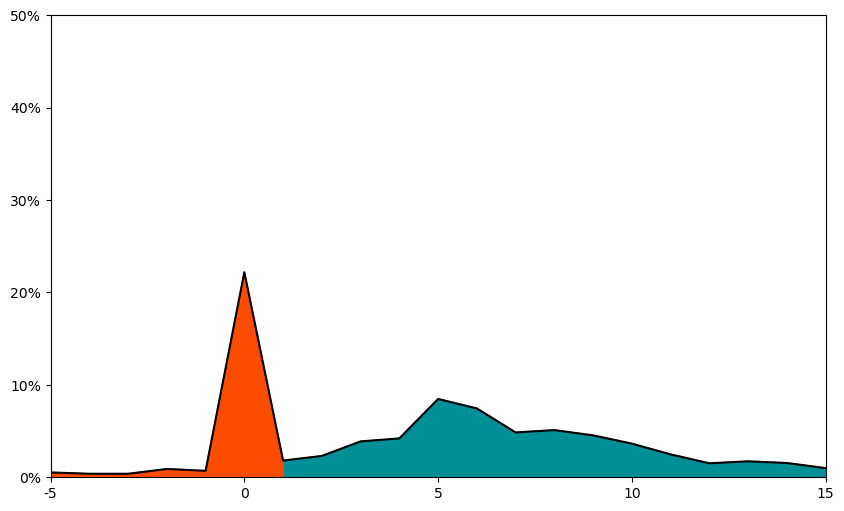

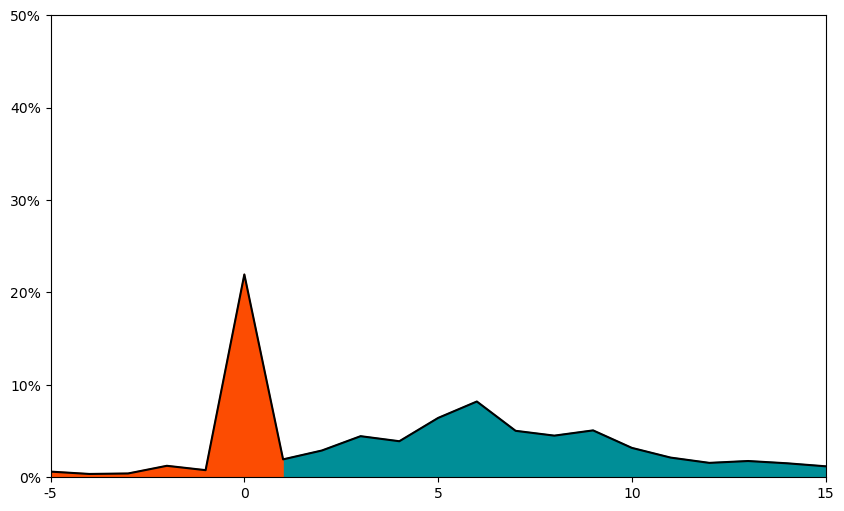

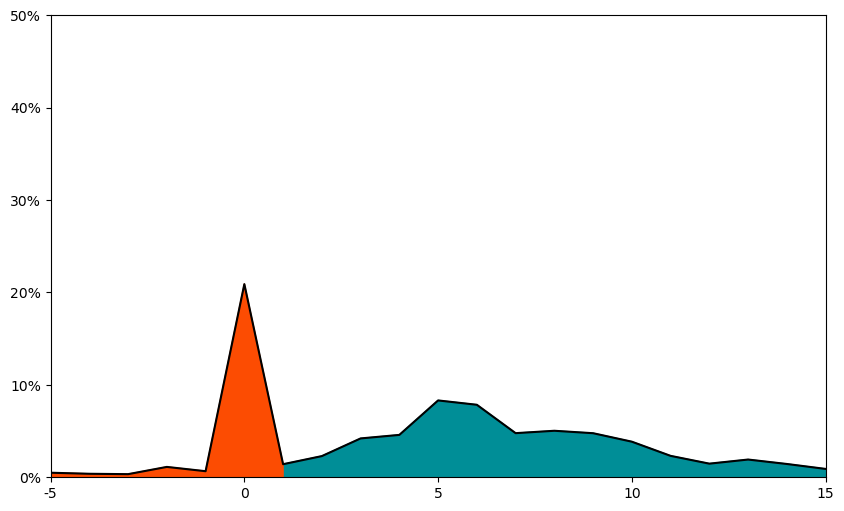

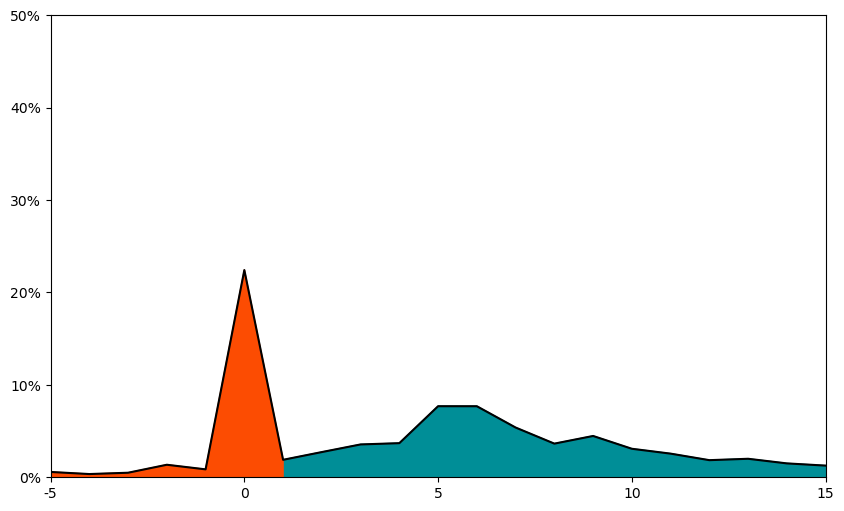

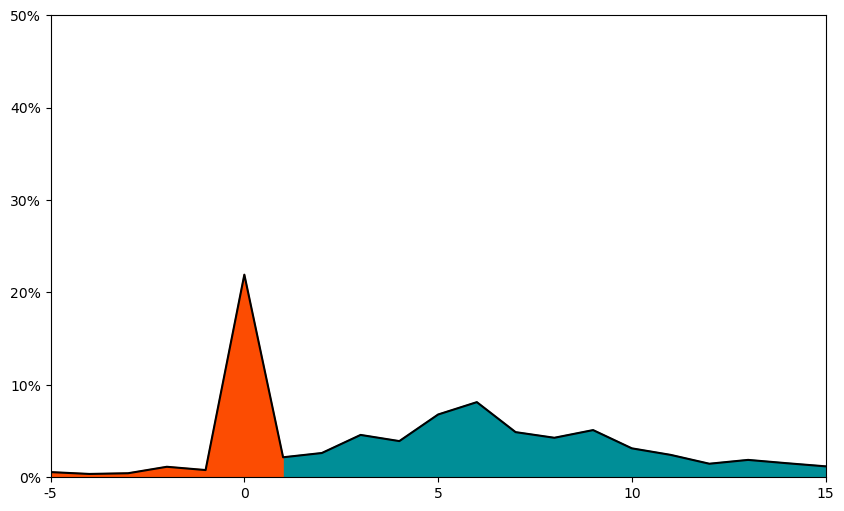

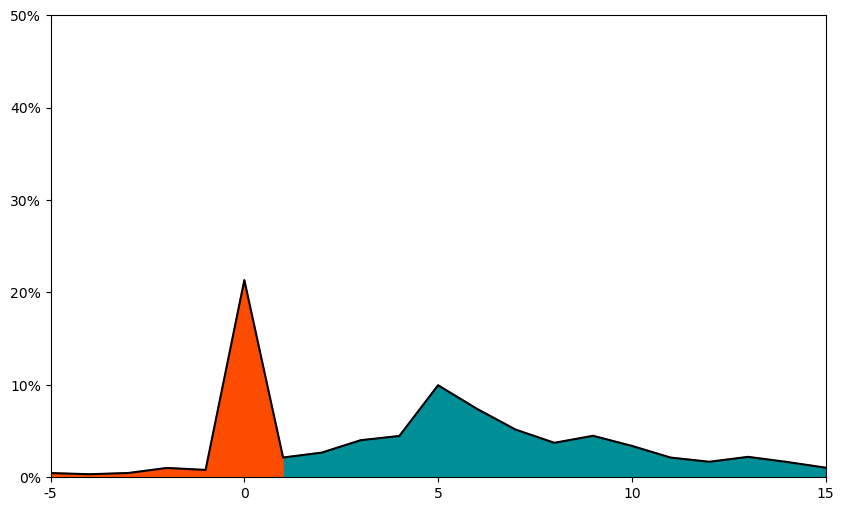

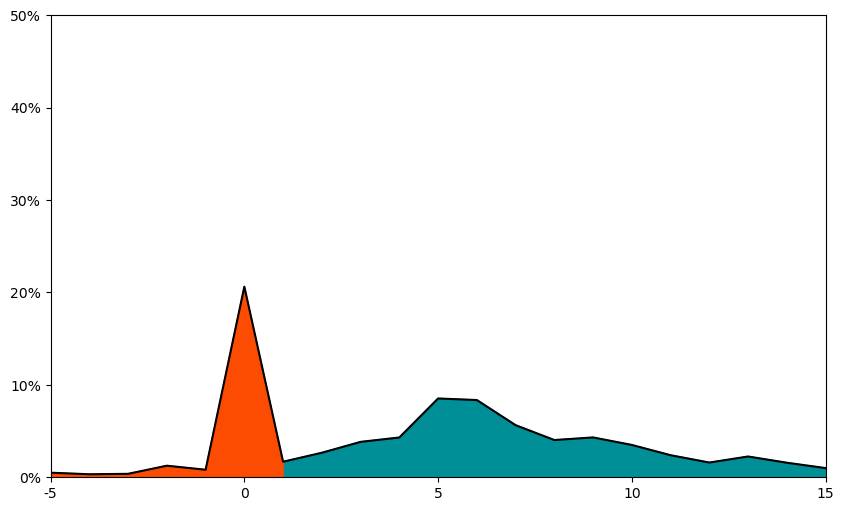

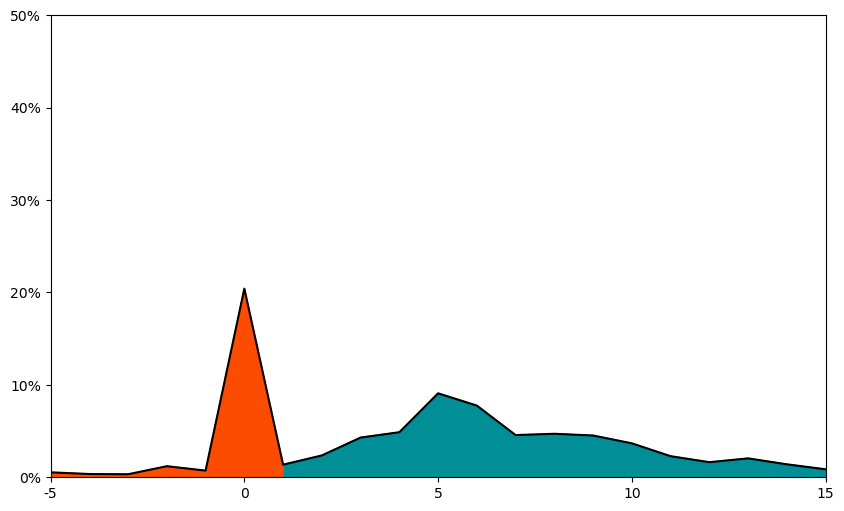

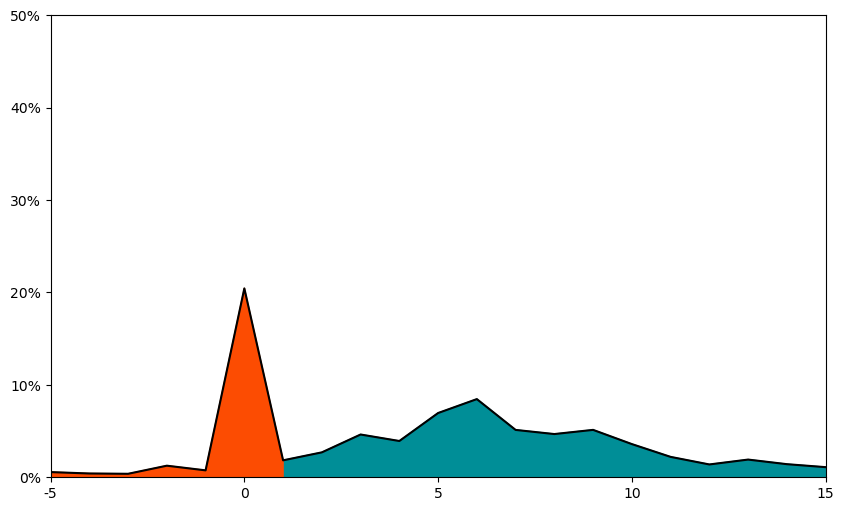

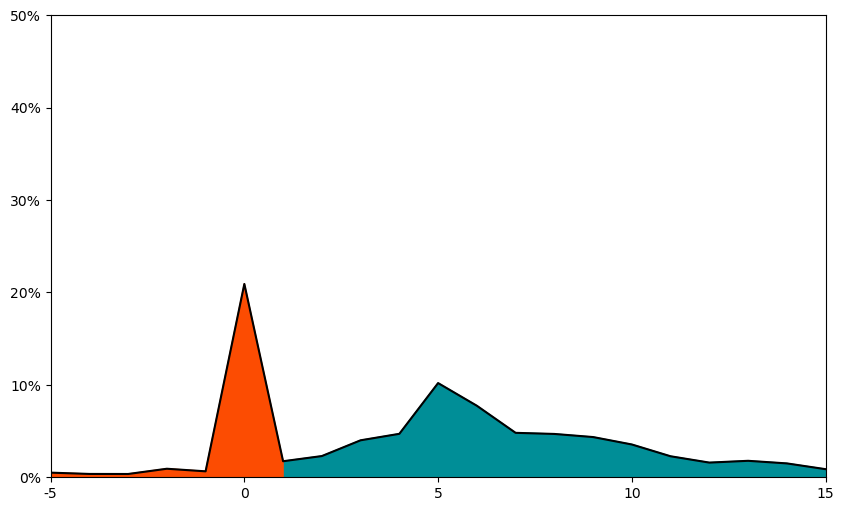

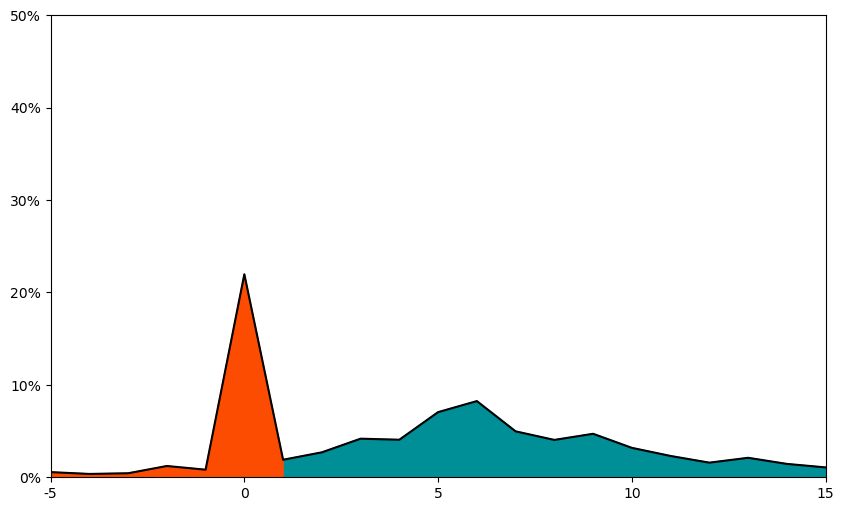

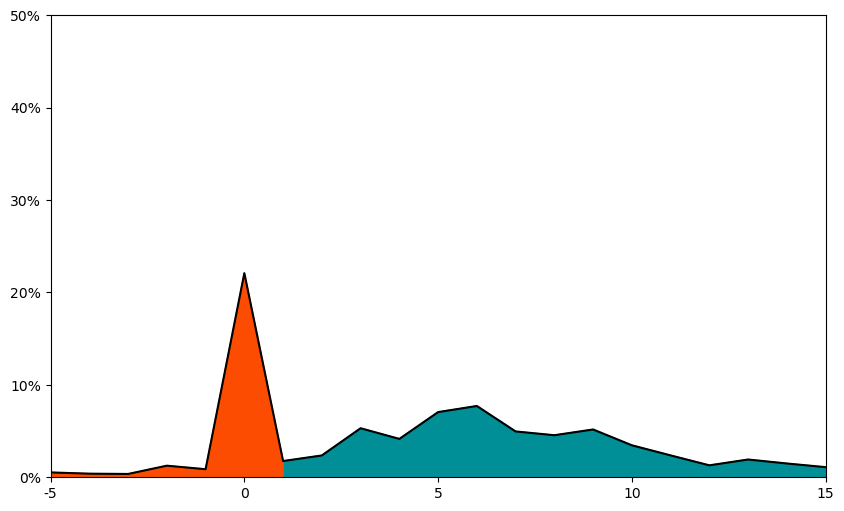

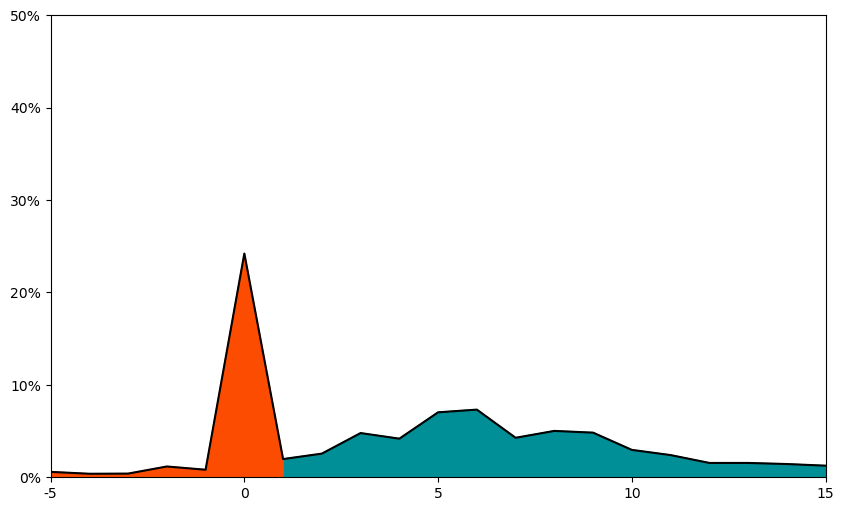

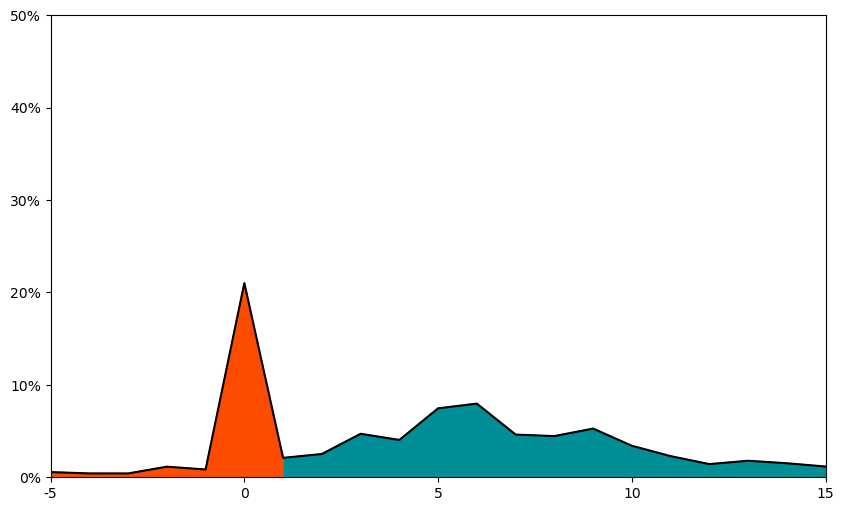

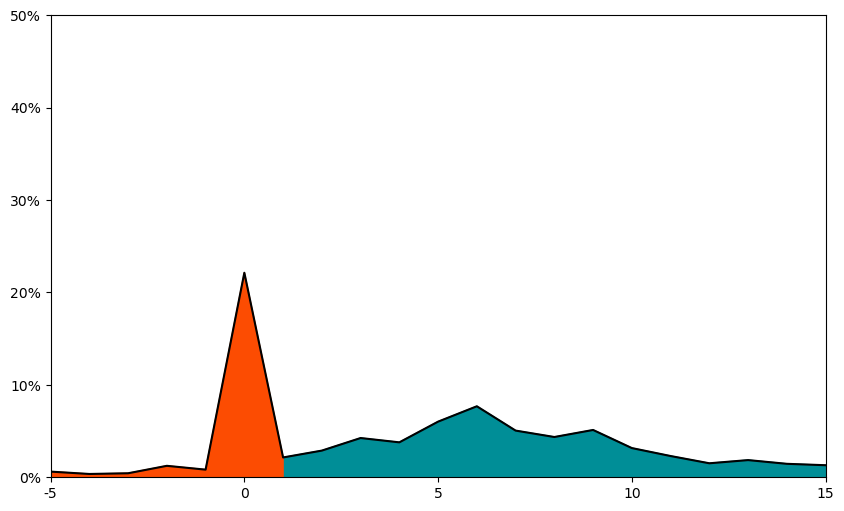

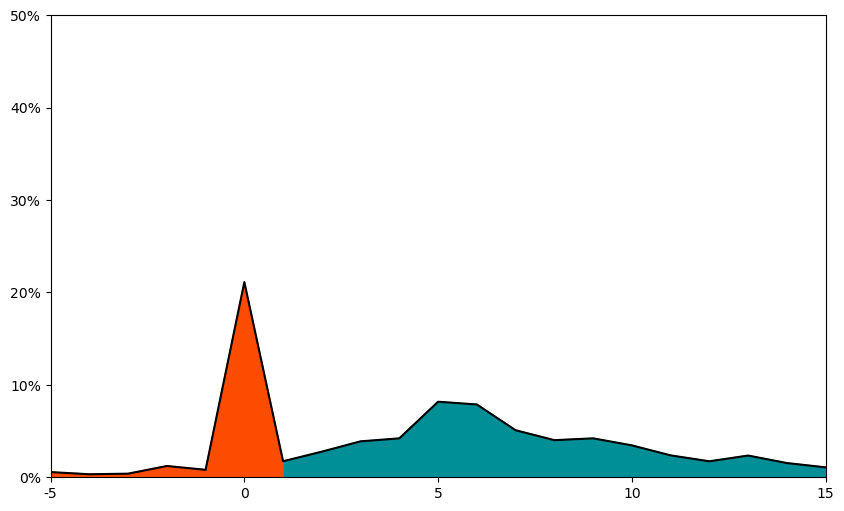

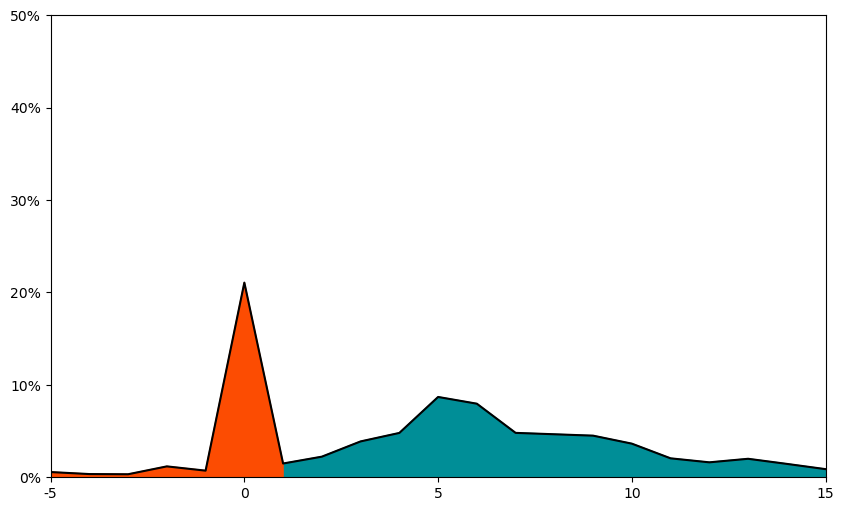

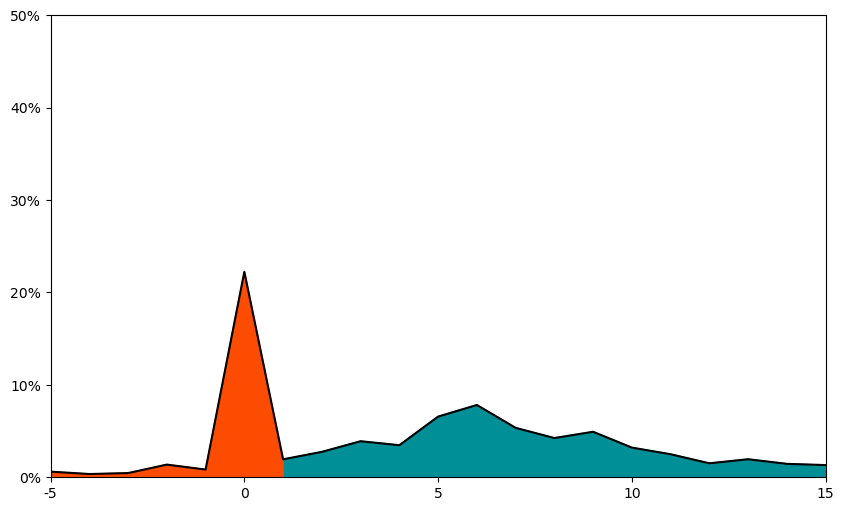

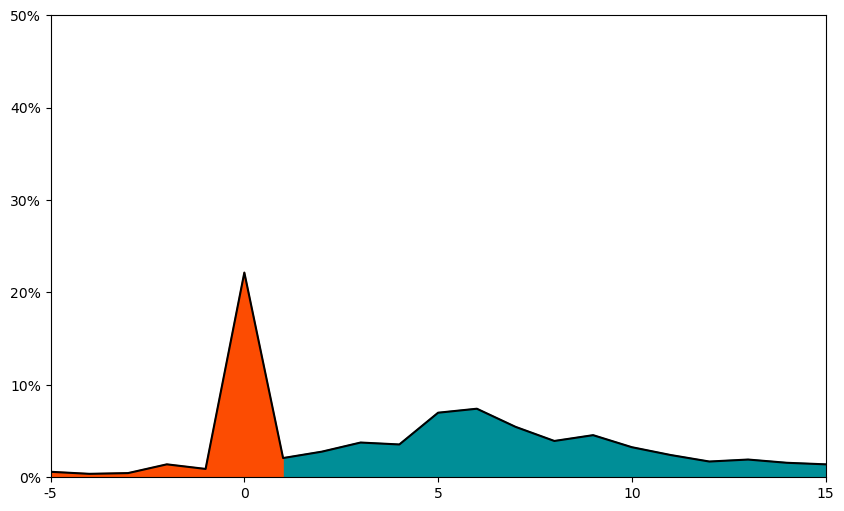

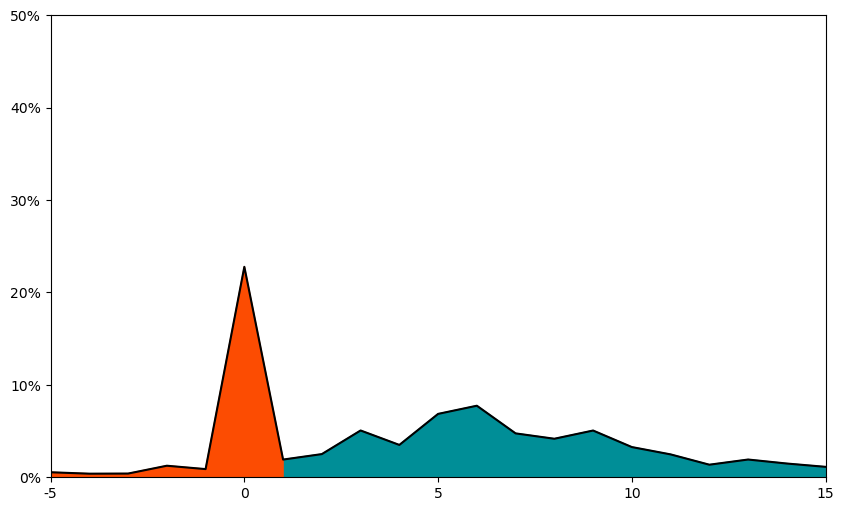

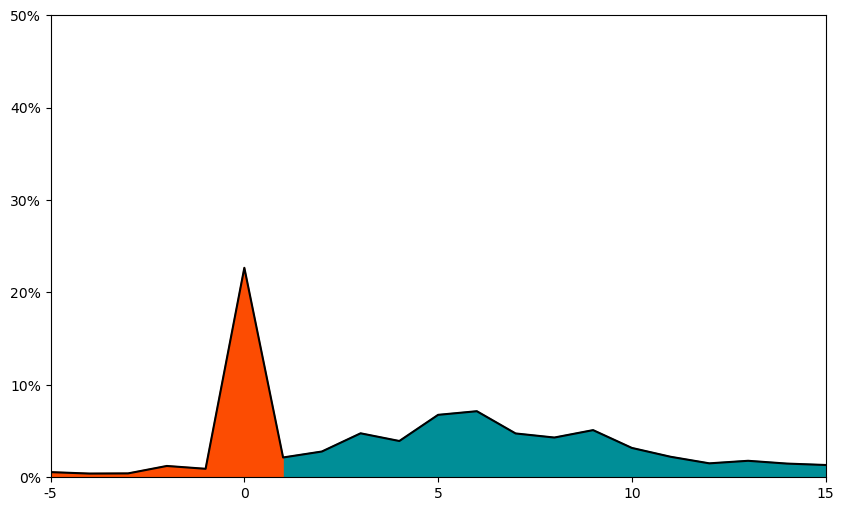

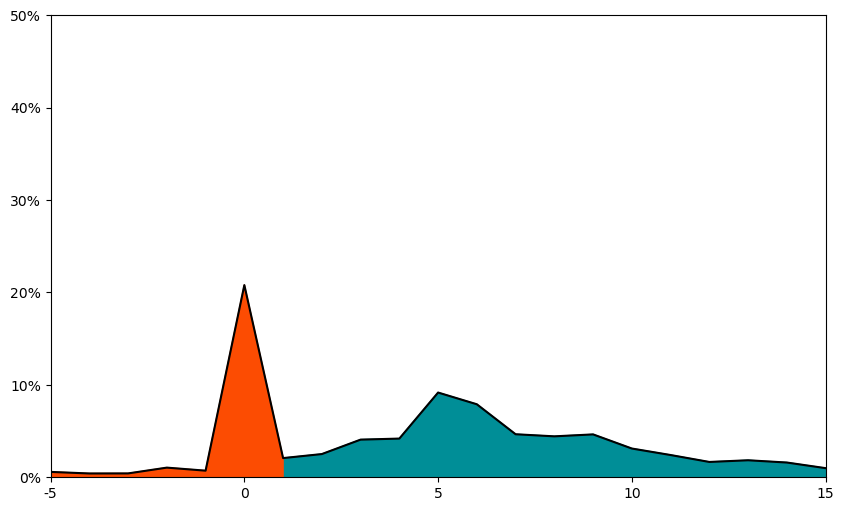

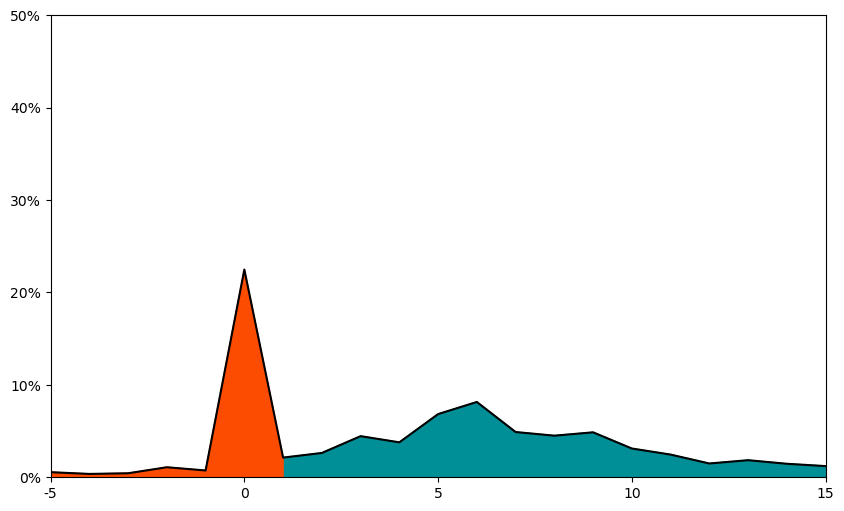

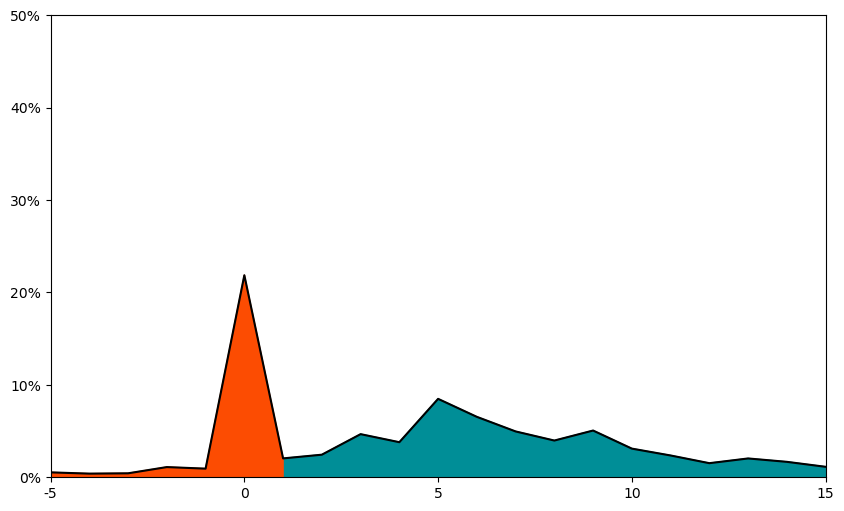

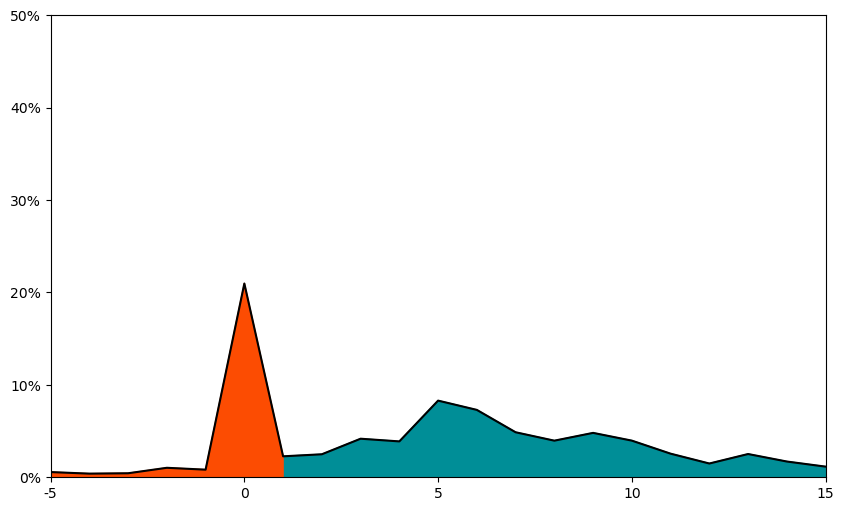

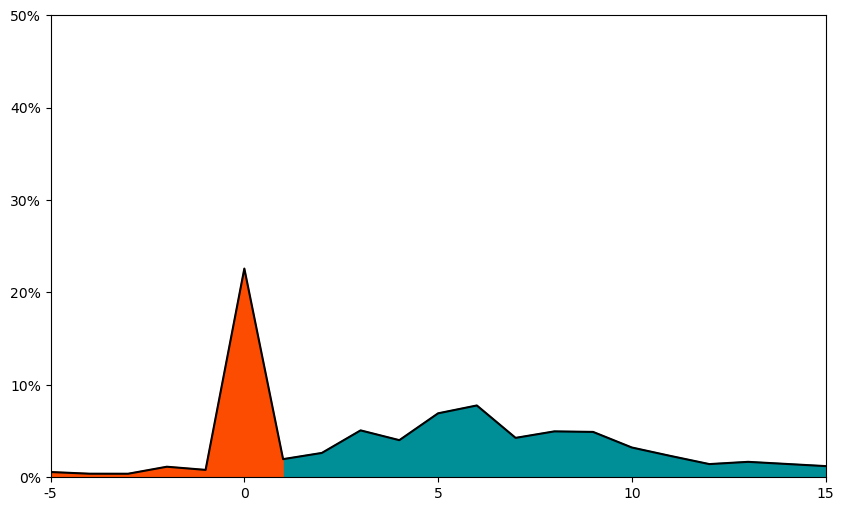

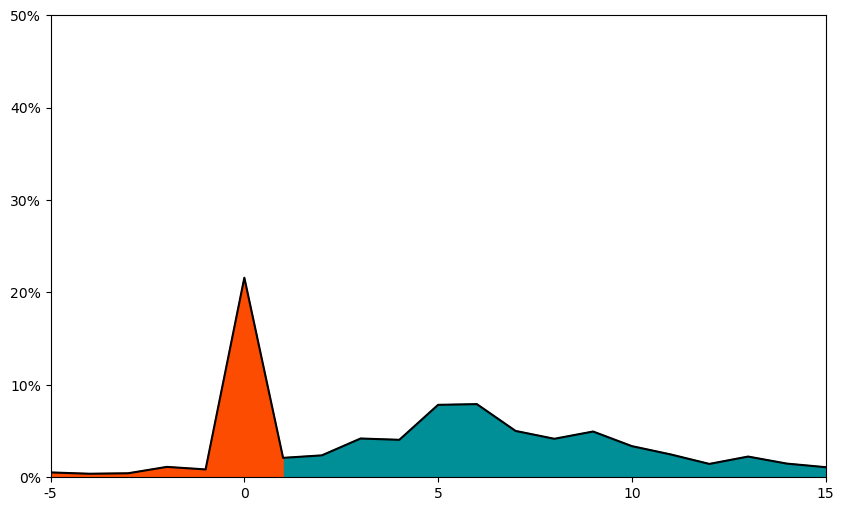

In [46]:
for i in range(len(predict_df)):
    bdb.plt.figure(figsize=(10, 6))  # Optional: Set figure size01
    bdb.plt.ylim([0, .5])
    bdb.plt.xlim([94, 114])
    new_x_ticks = [94, 99, 104, 109, 114]
    new_x_labels = [-5, 0, 5, 10, 15]
    new_y_ticks = [0, .1, .2, .3, .4, .5]
    new_y_labels = ['0%', '10%', '20%', '30%', '40%', '50%']
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = predict_df['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 100), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 100), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.show()

In [47]:
predict_df

PlayId  O_Label  D_Label  Count  \
0   20220911010063       23        0      3   
1   20220911013454       22        0      1   
2   20221002011998       19        0     10   
3   20221031000215       26        0      5   
4   20221002013399       16        0      8   
5   20220911012629        6        0      5   
6   20220922000465       11        0      4   
7   20220918010598       31        0      1   
8   20221031003508        4        0      6   
9   20221031000521        0        0      3   
10  20221002011797        5        0      2   
11  20220918013271       28        0      1   
12  20220918010577       12        0      5   
13  20221002012513        8        0      2   
14  20221009022254       20        0      2   
15  20221016011163       18        0      4   
16  20221016012501       24        0      5   
17  20221023001774       30        0      3   
18  20221023000705       33        0      2   
19  20221002010472       17        0      6   
20  20221002012034       10        0      2   
21  20221002010450        1        0      2   
22  20221031000550        3        0      6   
23  20220922001477        9        0      2   
24  20220918012368       14        0      3   
25  20221009022329       27        0      4   
26  20221002012471       32        0      2   
27  20221023002450        2        0      3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[0.00028679424, 0.00025677067, 0.00025636354, 0.00026405303, 0.00028055237, 0.00026966576, 0.00027168385, 0.00031130092, 0.00025713164, 0.00023913548, 0.0002691206, 0.00057509664, 0.00029974137, 0.00023644585, 0.00033641583, 0.00028453564, 0.00027200612, 0.00024218185, 0.00027342982, 0.00023119006, 0.00025312635, 0.00024792028, 0.00036365437, 0.00033154752, 0.00026716688, 0.0002538126, 0.00026511468, 0.00033511434, 0.0002347607, 0.00039137847, 0.00030993292, 0.00020458498, 0.00029085422, 0....   
1   [[0.00024481202, 0.00023752515, 0.00025452054, 0.00027537614, 0.00024415652, 0.00024008083, 0.000286929, 0.00028577738, 0.00023335837, 0.0002091454, 0.0002499578, 0.0005704104, 0.00026279155, 0.00021394245, 0.00031209073, 0.0002619813, 0.00024221349, 0.00023898321, 0.0002594158, 0.0002430056, 0.00024266008, 0.00023261424, 0.00029958237, 0.0002905167, 0.0002803753, 0.00025627544, 0.00023059105, 0.00034075216, 0.00019610063, 0.00035844644, 0.00027599215, 0.00018759866, 0.0002654427, 0.00036455...   
2   [[0.00027997477, 0.00027133845, 0.00027342004, 0.00026711507, 0.000284524, 0.00026668565, 0.00027495, 0.0003184279, 0.00025535593, 0.00023105506, 0.00027233746, 0.00060265156, 0.00030016276, 0.0002479287, 0.00033424047, 0.00027542922, 0.0002499464, 0.00024113037, 0.00028571198, 0.00024460108, 0.00024692845, 0.0002483311, 0.0003602999, 0.0003346173, 0.0002738982, 0.0002488867, 0.00026408414, 0.00034003376, 0.00023313925, 0.00039593986, 0.00031259697, 0.00020791181, 0.0002902553, 0.00040248752...   
3   [[0.0002617206, 0.00026080443, 0.00026792943, 0.00026972275, 0.00028940942, 0.00026552944, 0.00029005294, 0.0002991073, 0.00023687274, 0.00021889353, 0.00027244163, 0.00058972393, 0.00027603243, 0.00024263737, 0.00031638308, 0.00027609547, 0.0002656396, 0.00024569282, 0.00028550913, 0.00024152252, 0.00022554149, 0.0002728241, 0.00030069493, 0.00031110813, 0.00030124446, 0.00025765793, 0.00024287954, 0.00034208022, 0.00022154434, 0.00040340668, 0.0002955152, 0.00020444143, 0.00027998327, 0.00...   
4   [[0.00025672038, 0.00028838182, 0.00026901398, 0.00027686698, 0.0002854339, 0.0002711539, 0.00026956768, 0.00

In [48]:
for idx, i in enumerate(player_space['Position']):
    position_adj = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Factor'].min()
    player_space.at[idx, 'Space Factor Adj'] = player_space['Space Factor'].iloc[idx] - position_adj
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [49]:
ofdf = pd.DataFrame(offensive_formations)

In [50]:
ofdf_mean = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
ofdf_expl = ofdf.sort_values(by = 'Explosive_%', ascending=False).reset_index(drop=True)
ofdf_neg = ofdf.sort_values(by = 'Negative_%', ascending=False).reset_index(drop=True)

In [51]:
players1 = pd.read_csv('nfl-big-data-bowl-2025/players.csv')

In [52]:
players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]

40023

In [53]:
players1.loc[(players1['displayName'] == 'Robert Jones')]

nflId height  weight birthDate       collegeName position   displayName
1433  53861    6-5     330       NaN  Middle Tennessee        G  Robert Jones

In [54]:
players1.loc[(players1['displayName'] == 'Connor Williams')]

nflId height  weight   birthDate collegeName position      displayName
606  46119    6-5     298  1997-05-12       Texas        C  Connor Williams

In [55]:
players1.loc[(players1['displayName'] == 'Robert Hunt')]

nflId height  weight   birthDate          collegeName position  \
1030  52447    6-5     322  1996-08-25  Louisiana-Lafayette        G   

      displayName  
1030  Robert Hunt

In [56]:
players1.loc[(players1['displayName'] == 'Brandon Shell')]

nflId height  weight   birthDate     collegeName position    displayName
366  43447    6-5     324  1992-02-06  South Carolina        T  Brandon Shell

In [57]:
snap

GameId        PlayId_x  Team          X          Y     S     A   Dis  \
0   2022103003  20220911013454  away  58.629999  20.349999  0.12  0.61  0.01   
1   2022103003  20220911013454  away  54.049999  25.679999  0.08  0.06  0.02   
2   2022103003  20220911013454  away  58.589999  26.419999  0.15  1.07  0.01   
3   2022103003  20220911013454  away  59.199999  43.189999  0.01  0.19  0.02   
4   2022103003  20220911013454  away  57.559999  28.039999  0.63  1.75  0.08   
5   2022103003  20220911013454  away  59.349999  23.299999  0.81  2.26  0.07   
6   2022103003  20220911013454  away  58.679999  34.599999  0.02  0.42  0.01   
7   2022103003  20220911013454  away  54.569999  23.429999  0.00  0.00  0.00   
8   2022103003  20220911013454  away  58.839999  24.869999  0.16  0.85  0.02   
9   2022103003  20220911013454  away  58.929999  21.799999  0.31  1.29  0.03   
10  2022103003  20220911013454  away  59.089999  14.929999  0.00  0.00  0.01   
11  2022091101  20220911013454  away  60.830000  15.880000  0.17  0.12  0.02   
12  2022091101  20220911013454  away  60.540000  29.330000  0.34  0.22  0.03   
13  2022091101  20220911013454  away  72.570000  35.810000  0.46  0.28  0.12   
14  2022091101  20220911013454  away  65.490000  26.880000  0.41  0.27  0.04   
15  2022091101  20220911013454  away  63.420000  15.720000  0.16  1.72  0.18   
16  2022091101  20220911013454  away  60.200000  20.500000  0.01  0.27  0.04   
17  2022091101  20220911013454  away  65.540000  32.110000  0.17  0.25  0.02   
18  2022091101  20220911013454  away  72.490000  22.790000  0.31  1.42  0.03   
19  2022091101  20220911013454  away  61.110000  24.790000  0.42  1.13  0.04   
20  2022091101  20220911013454  away  64.600000  44.370000  1.41  0.72  0.14   
21  2022091101  20220911013454  away  65.260000  22.300000  0.17  0.05  0.03   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -1.635897  40023.0        T        49        3   0.267259            MIA   
1  -4.790580  42718.0       RB        49        3   0.267259            MIA   
2  -2.874906  43447.0        T        49        3   0.267259            MIA   
3  -6.225240  43454.0       WR        49        3   0.267259            MIA   
4  -4.288449  46111.0       TE        49        3   0.267259            MIA   
5  -1.972048  46119.0        C        49        3   0.267259            MIA   
6  -6.792996  46671.0       WR        49        3   0.267259            MIA   
7  -6.486167  52413.0       QB        49        3   0.267259            MIA   
8  -3.380877  52447.0        G        49        3   0.267259            MIA   
9  -7.457443  53471.0        G        49        3   0.267259            MIA   
10 -4.357389  54938.0       WR        49        3   0.267259            MIA   
11 -3.032335  41227.0      OLB        25        4   0.400241            CAR   
12 -0.382053  44813.0       DE        25        4   0.400241            CAR   
13  1.289275  44903.0       SS        25        4   0.400241            CAR   
14 -1.278803  44974.0      MLB        25        4   0.400241            CAR   
15 -0.734784  46073.0       CB        25        4   0.400241            CAR   
16 -4.163308  46098.0       DT        25        4   0.400241            CAR   
17 -4.330336  47863.0      OLB        25        4   0.400241            CAR   
18  1.418080  52452.0       SS        25        4   0.400241            CAR   
19 -3.592237  52496.0       DT        25        4   0.400241            CAR   
20 -0.038921  53455.0       CB        25        4   0.400241            CAR   
21 -2.637367  53481.0      OLB        25        4   0.400241            CAR   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            DET     2        10           MIA                   27   
1            DET     2        10           MIA                   27   
2            DET     2        10           MIA                   27   
3            DET     2        10           MIA                   

In [58]:
player_number.loc[player_number['NflId'] == 40023.0]

PlayId    NflId  JerseyNumber
20682   20220911060290  40023.0          72.0
20704   20220911060314  40023.0          72.0
20726   20220911060338  40023.0          72.0
20748   20220911060359  40023.0          72.0
20770   20220911060380  40023.0          72.0
20792   20220911060442  40023.0          72.0
20814   20220911060466  40023.0          72.0
20836   20220911060499  40023.0          72.0
20857   20220911060523  40023.0          72.0
21056   20220911060835  40023.0          72.0
21078   20220911060859  40023.0          72.0
21100   20220911060883  40023.0          72.0
21121   20220911060904  40023.0          72.0
21143   20220911060925  40023.0          72.0
21165   20220911060950  40023.0          72.0
21187   20220911060974  40023.0          72.0
21209   20220911060998  40023.0          72.0
21232   20220911061019  40023.0          72.0
21253   20220911061040  40023.0          72.0
21429   20220911061380  40023.0          72.0
21451   20220911061401  40023.0          72.0
21473   20220911061425  40023.0          72.0
21495   20220911061446  40023.0          72.0
21517   20220911061480  40023.0          72.0
21539   20220911061544  40023.0          72.0
21561   20220911061568  40023.0          72.0
21583   20220911061590  40023.0          72.0
21605   20220911061609  40023.0          72.0
21628   20220911061653  40023.0          72.0
21672   20220911061774  40023.0          72.0
21694   20220911061798  40023.0          72.0
21716   20220911061819  40023.0          72.0
22067   20220911062329  40023.0          72.0
22089   20220911062358  40023.0          72.0
22111   20220911062384  40023.0          72.0
22133   20220911062405  40023.0          72.0
22155   20220911062429  40023.0          72.0
22178   20220911062450  40023.0          72.0
22199   20220911062474  40023.0          72.0
22332   20220911062721  40023.0          72.0
22354   20220911062743  40023.0          72.0
22376   20220911062767  40023.0          72.0
22485   20220911062935  40023.0          72.0
22507   20220911062956  40023.0          72.0
22529   20220911062978  40023.0          72.0
22552   20220911063002  40023.0          72.0
22728   20220911063253  40023.0          72.0
22750   20220911063277  40023.0          72.0
22772   20220911063298  40023.0          72.0
22793   20220911063337  40023.0          72.0
22815   20220911063361  40023.0          72.0
22838   20220911063399  40023.0          72.0
22860   20220911063437  40023.0          72.0
22882   20220911063475  40023.0          72.0
22904   20220911063529  40023.0          72.0
22926   20220911063550  40023.0          72.0
77486   20220918000096  40023.0          72.0
77508   20220918000117  40023.0          72.0
77530   20220918000141  40023.0          72.0
77552   20220918000165  40023.0          72.0
77574   20220918000195  40023.0          72.0
77596   20220918000229  40023.0          72.0
77617   20220918000253  40023.0          72.0
77639   20220918000281  40023.0          72.0
77991   20220918000883  40023.0          72.0
78014   20220918000913  40023.0          72.0
78036   20220918000937  40023.0          72.0
78058   20220918000966  40023.0          72.0
78081   20220918001018  40023.0          72.0
78103   20220918001052  40023.0          72.0
78145   20220918001164  40023.0          72.0
78167   20220918001188  40023.0          72.0
78190   20220918001209  40023.0          72.0
78213   20220918001233  40023.0          72.0
78235   20220918001256  40023.0          72.0
78257   20220918001278  40023.0          72.0
78278   20220918001297  40023.0          72.0
78432   20220918001575  40023.0          72.0
78454   20220918001597  40023.0          72.0
78475   20220918001621  40023.0          72.0
78497   20220918001642  40023.0          72.0
78520   20220918001664  40023.0          72.0
78542   20220918001688  40023.0          72.0
78565   20220918001722  40023.0          72.0
78586   20220918001744  40023.0          72.0
78717   20220918002034  40023.0          72.0
78739   202209

In [59]:
snapo

GameId        PlayId_x  Team          X          Y     S     A   Dis  \
0   2022103003  20220911013454  away  58.629999  20.349999  0.12  0.61  0.01   
1   2022103003  20220911013454  away  54.049999  25.679999  0.08  0.06  0.02   
2   2022103003  20220911013454  away  58.589999  26.419999  0.15  1.07  0.01   
3   2022103003  20220911013454  away  59.199999  43.189999  0.01  0.19  0.02   
4   2022103003  20220911013454  away  57.559999  28.039999  0.63  1.75  0.08   
5   2022103003  20220911013454  away  59.349999  23.299999  0.81  2.26  0.07   
6   2022103003  20220911013454  away  58.679999  34.599999  0.02  0.42  0.01   
7   2022103003  20220911013454  away  54.569999  23.429999  0.00  0.00  0.00   
8   2022103003  20220911013454  away  58.839999  24.869999  0.16  0.85  0.02   
9   2022103003  20220911013454  away  58.929999  21.799999  0.31  1.29  0.03   
10  2022103003  20220911013454  away  59.089999  14.929999  0.00  0.00  0.01   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -1.635897  40023.0        T        49        3   0.267259            MIA   
1  -4.790580  42718.0       RB        49        3   0.267259            MIA   
2  -2.874906  43447.0        T        49        3   0.267259            MIA   
3  -6.225240  43454.0       WR        49        3   0.267259            MIA   
4  -4.288449  46111.0       TE        49        3   0.267259            MIA   
5  -1.972048  46119.0        C        49        3   0.267259            MIA   
6  -6.792996  46671.0       WR        49        3   0.267259            MIA   
7  -6.486167  52413.0       QB        49        3   0.267259            MIA   
8  -3.380877  52447.0        G        49        3   0.267259            MIA   
9  -7.457443  53471.0        G        49        3   0.267259            MIA   
10 -4.357389  54938.0       WR        49        3   0.267259            MIA   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            DET     2        10           MIA                   27   
1            DET     2        10           MIA                   27   
2            DET     2        10           MIA                   27   
3            DET     2        10           MIA                   27   
4            DET     2        10           MIA                   27   
5            DET     2        10           MIA                   27   
6            DET     2        10           MIA                   27   
7            DET     2        10           MIA                   27   
8            DET     2        10           MIA                   27   
9            DET     2        10           MIA                   27   
10           DET     2        10           MIA                   27   

    VisitorScoreBeforePlay  NflIdPasser OffenseFormation PlayDirection  Yards  \
0                       24      52413.0          SHOTGUN          left      4   
1                       24      52413.0          SHOTGUN          left      4   
2                       24      52413.0          SHOTGUN          left      4   
3                       24      52413.0          SHOTGUN          left      4   
4                       24      52413.0          SHOTGUN          left      4   
5                       24      52413.0          SHOTGUN          left      4   
6                       24      52413.0          SHOTGUN          left      4   
7                       24      52413.0          SHOTGUN          left      4   
8                       24      52413.0          SHOTGUN          left      4   
9                       24      52413.0          SHOTGUN          left      4   
10                      24      52413.0          SHOTGUN          left      4   

    expectedPointsAdded HomeTeamAbbr VisitorTeamAbbr  ToLeft  BallCarrier  \
0             -0.645371          DET             MIA    True          0.0   
1             -0.645371          DET             MIA    True          0.0   
2             -0.645371          DET     

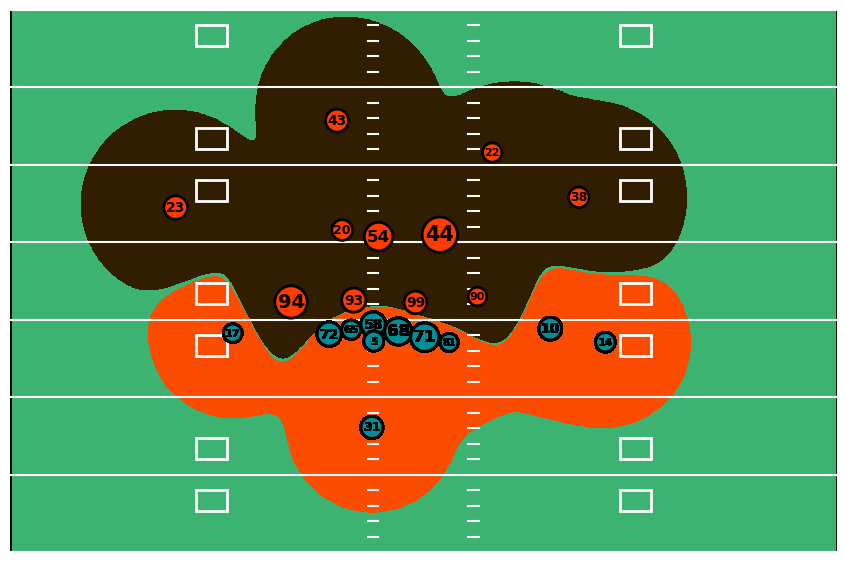

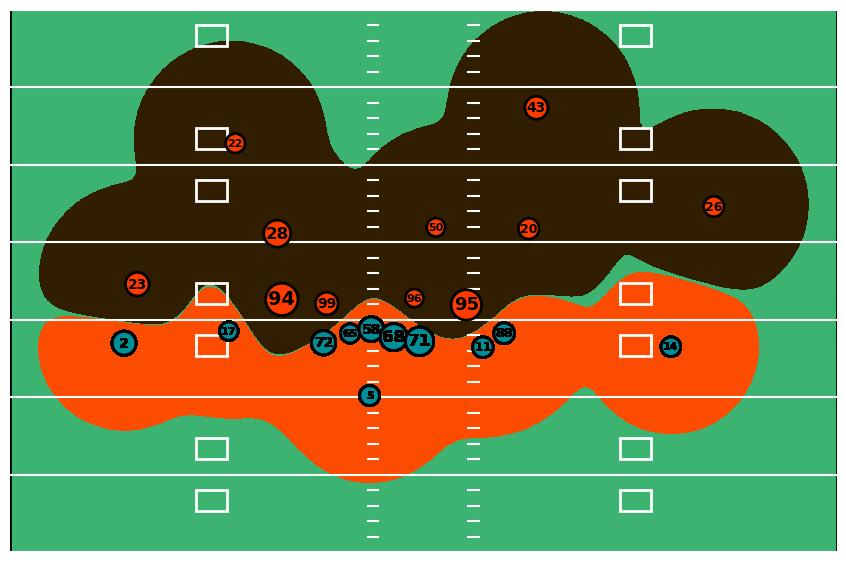

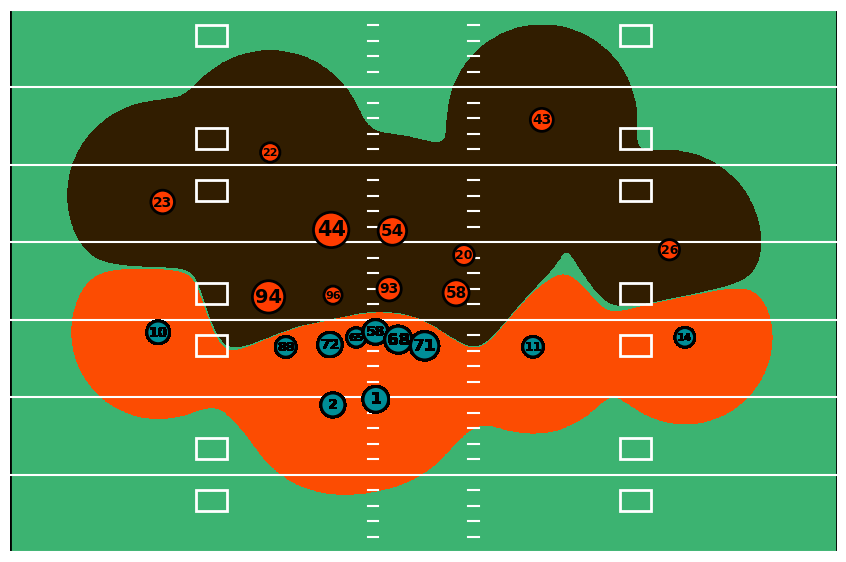

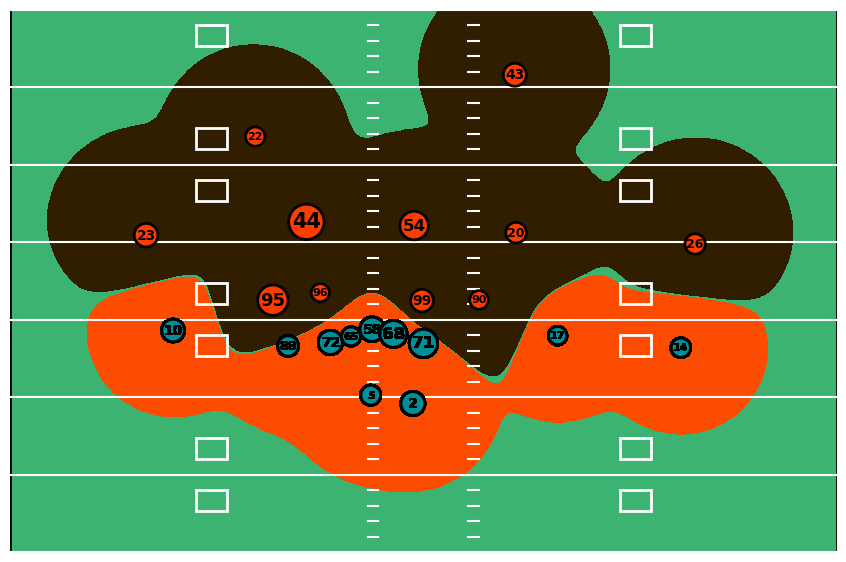

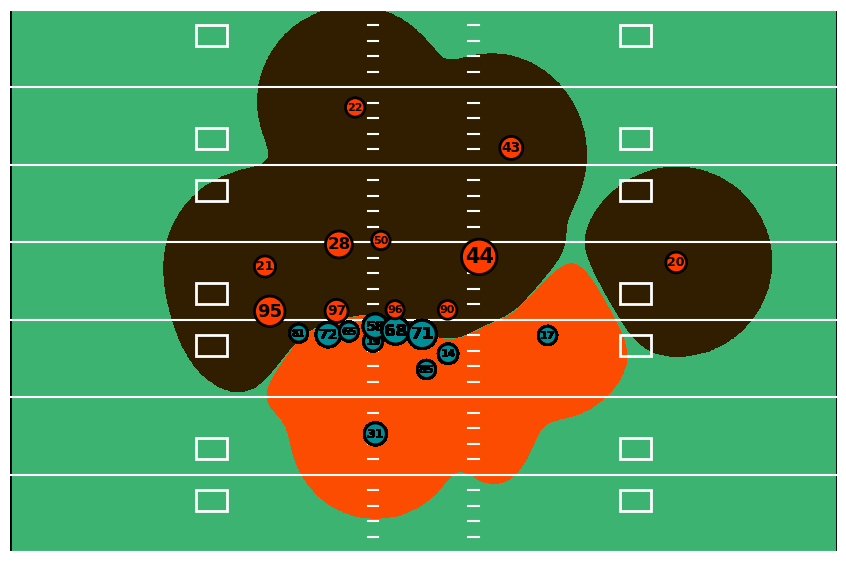

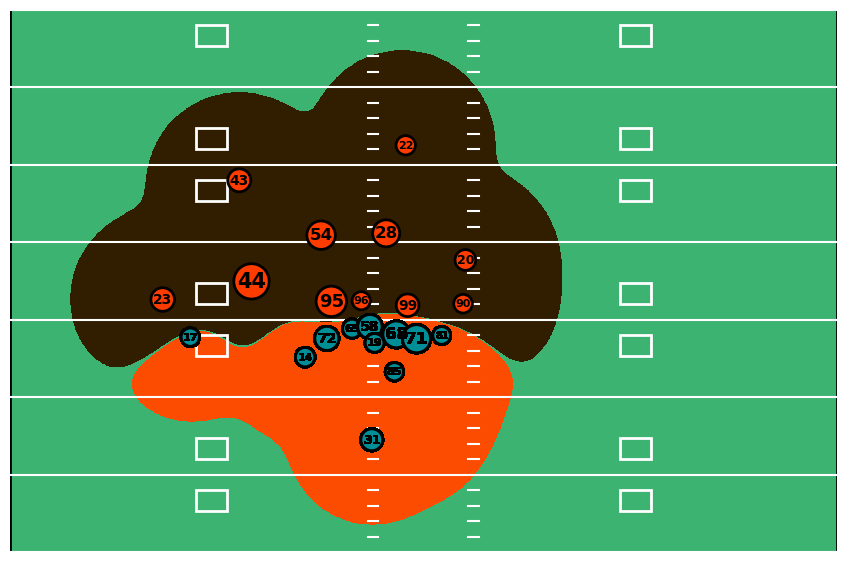

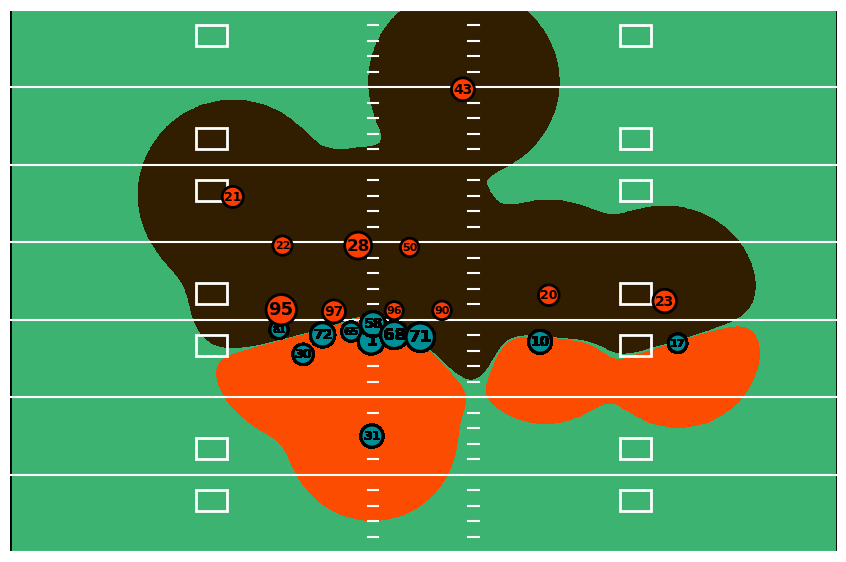

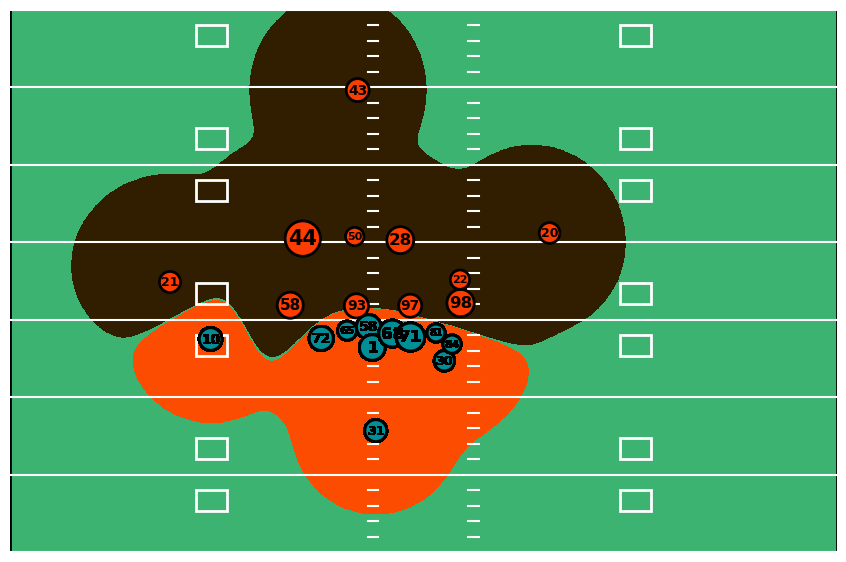

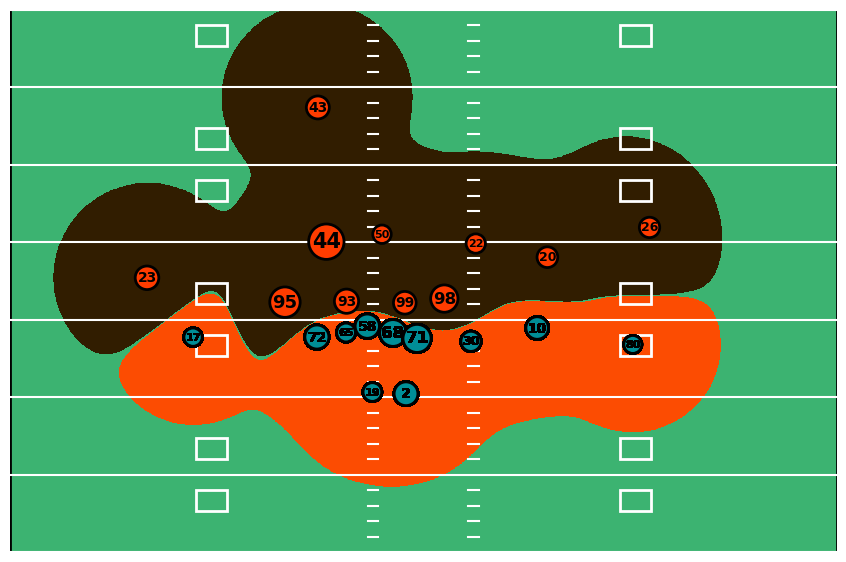

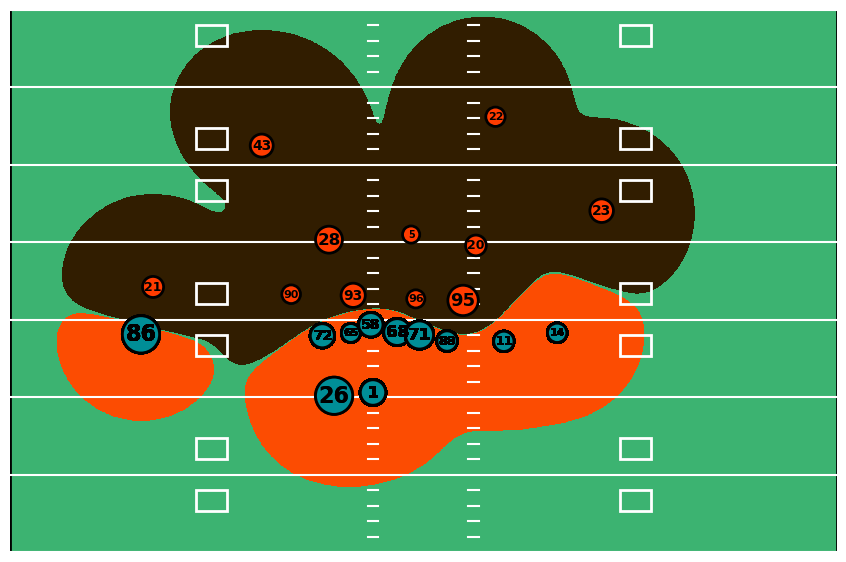

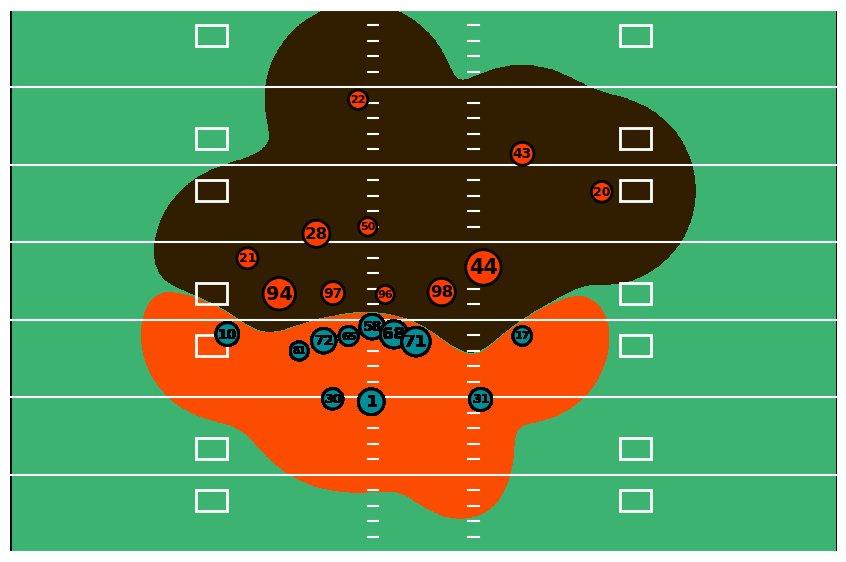

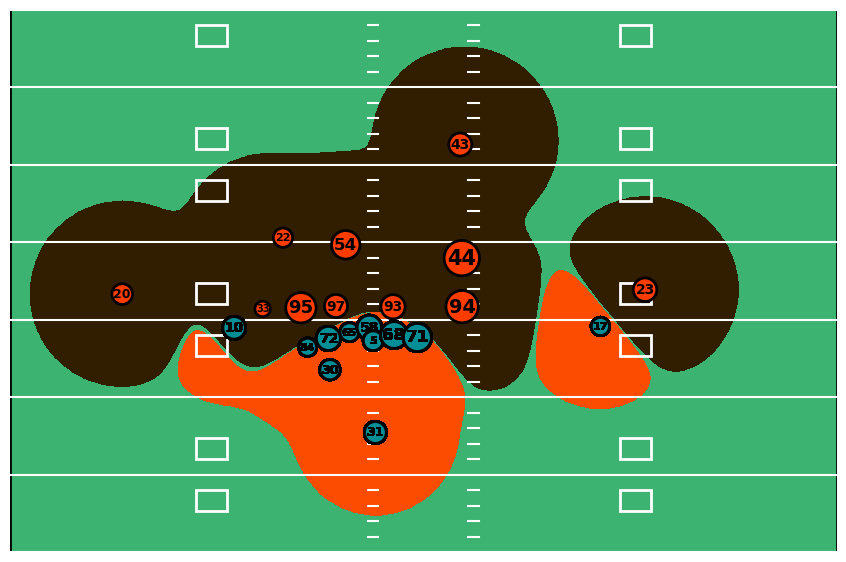

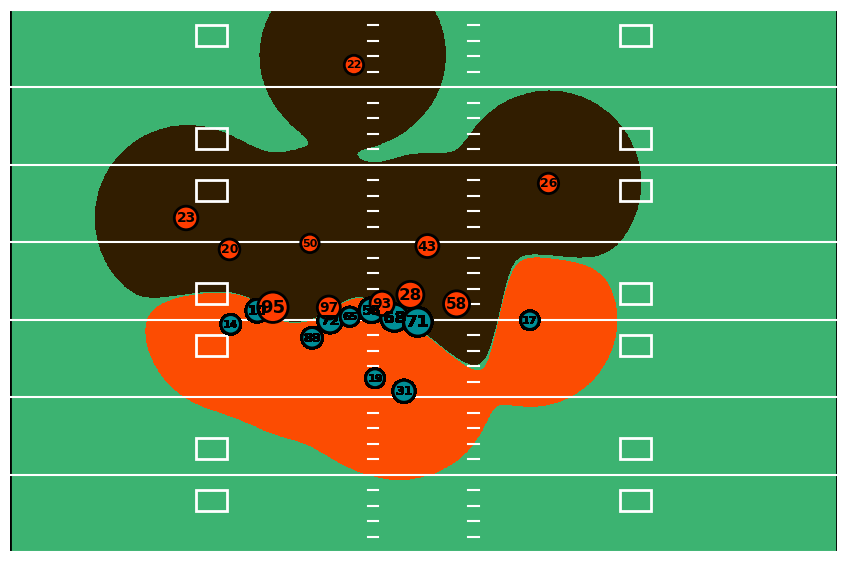

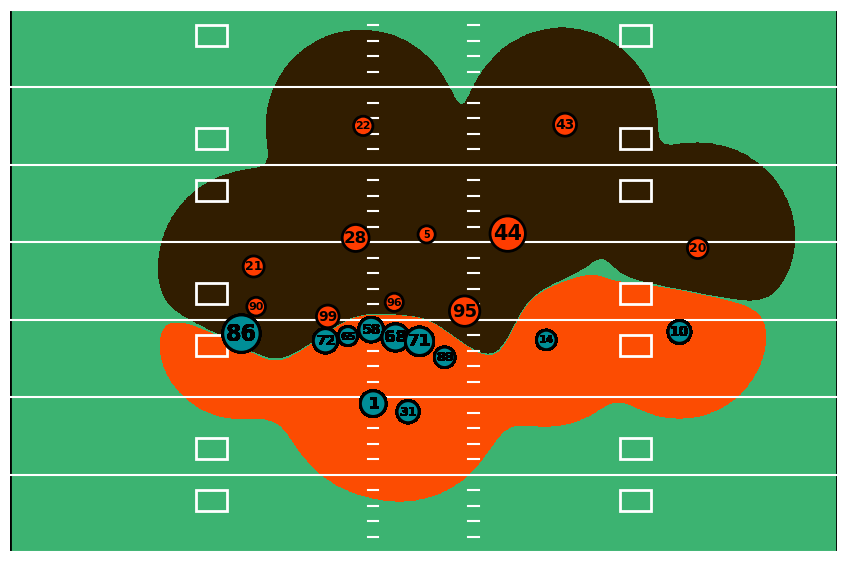

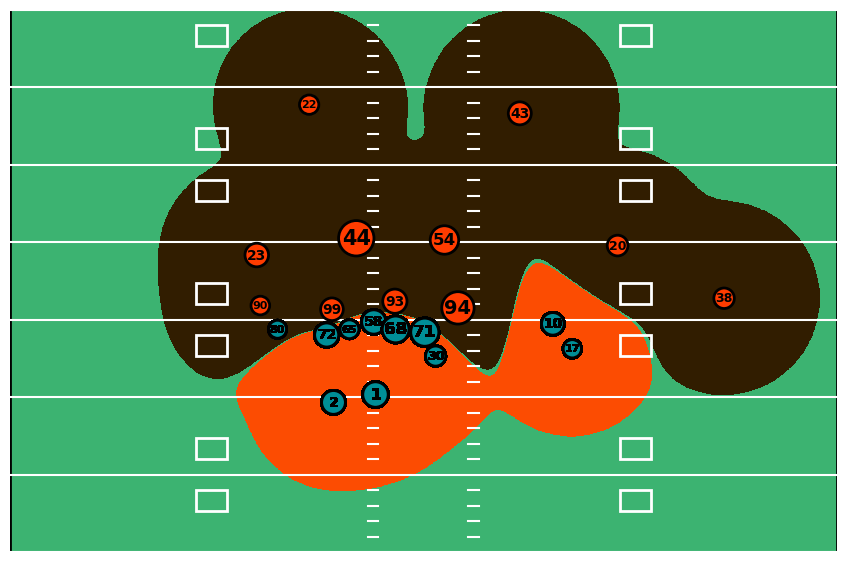

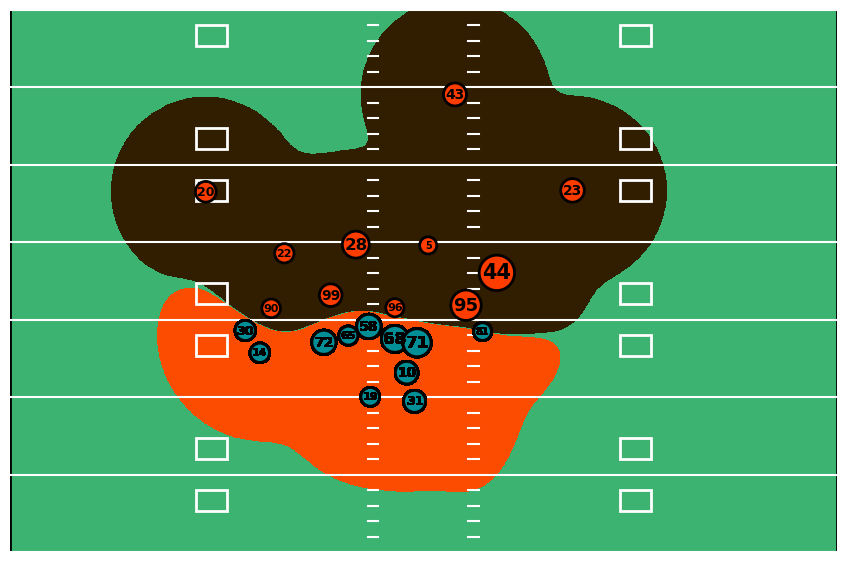

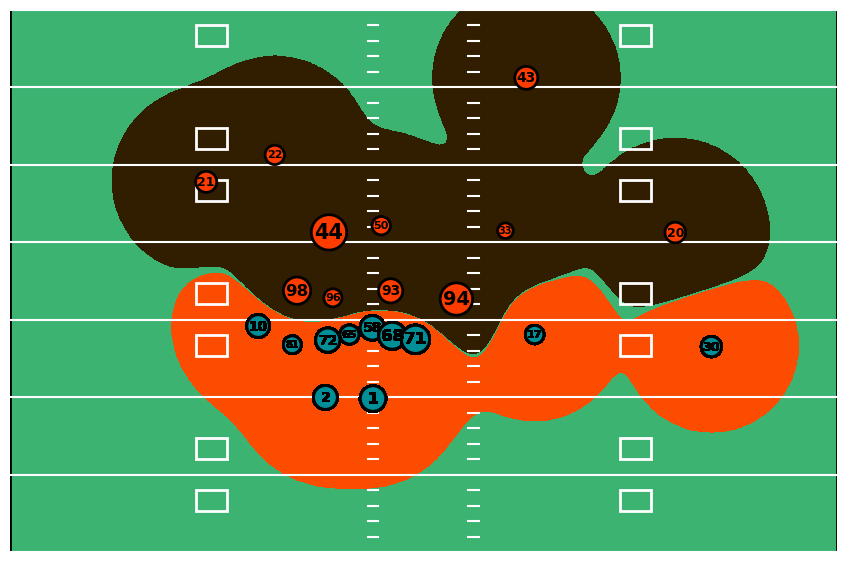

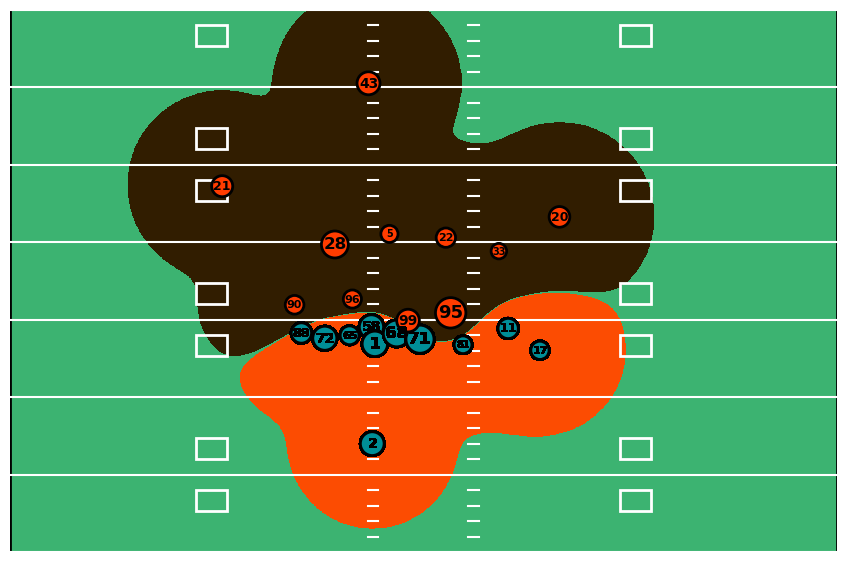

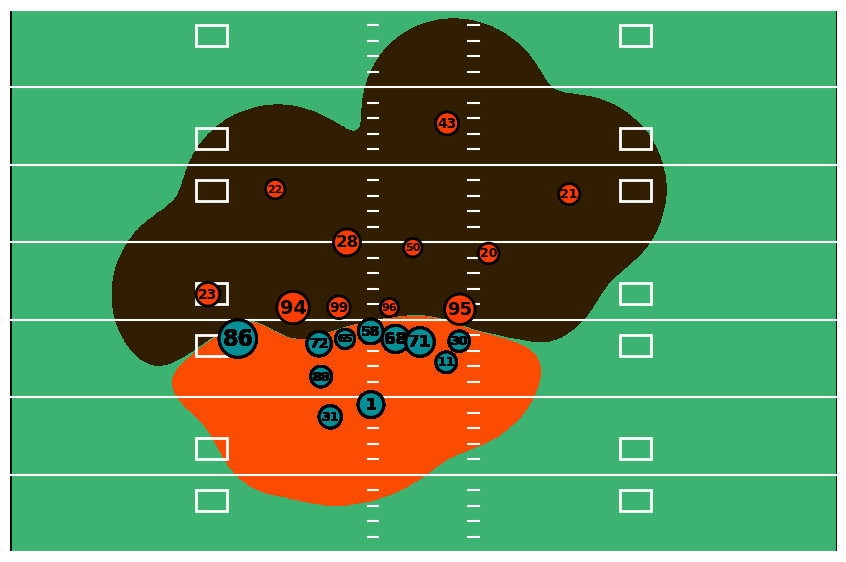

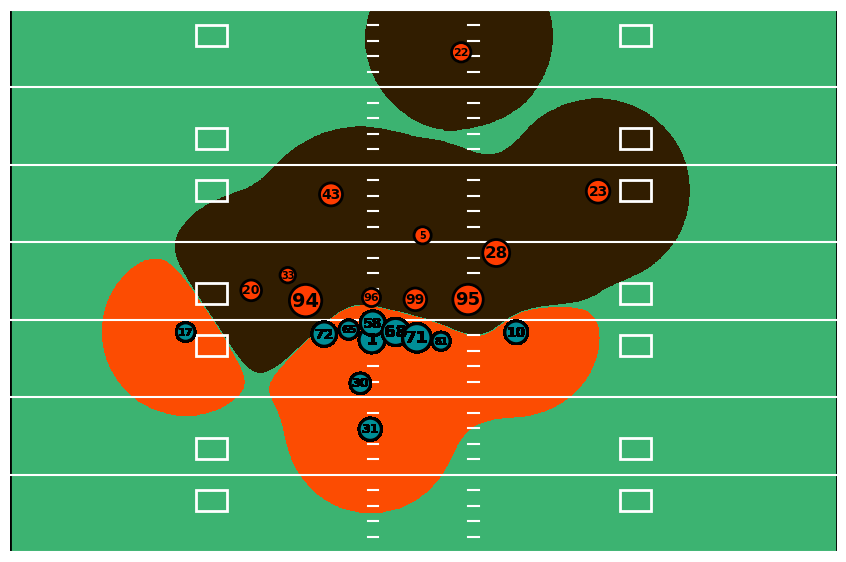

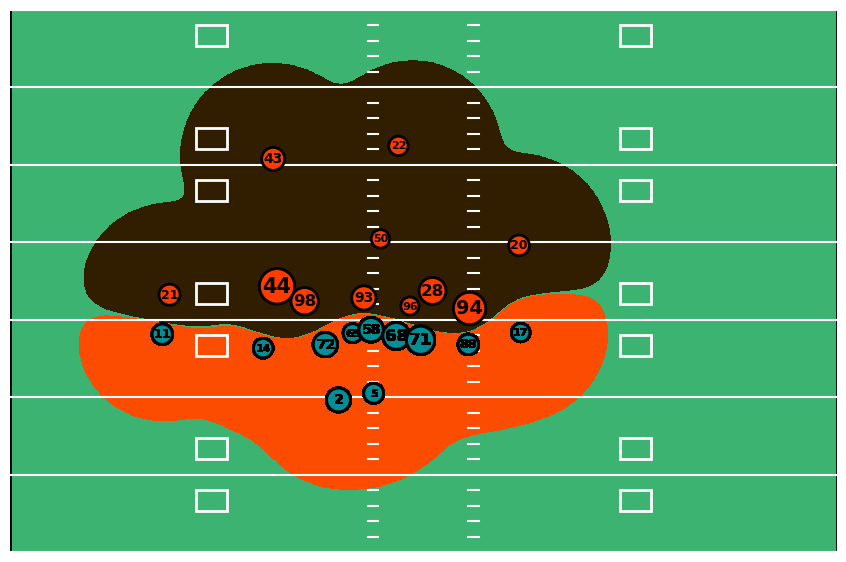

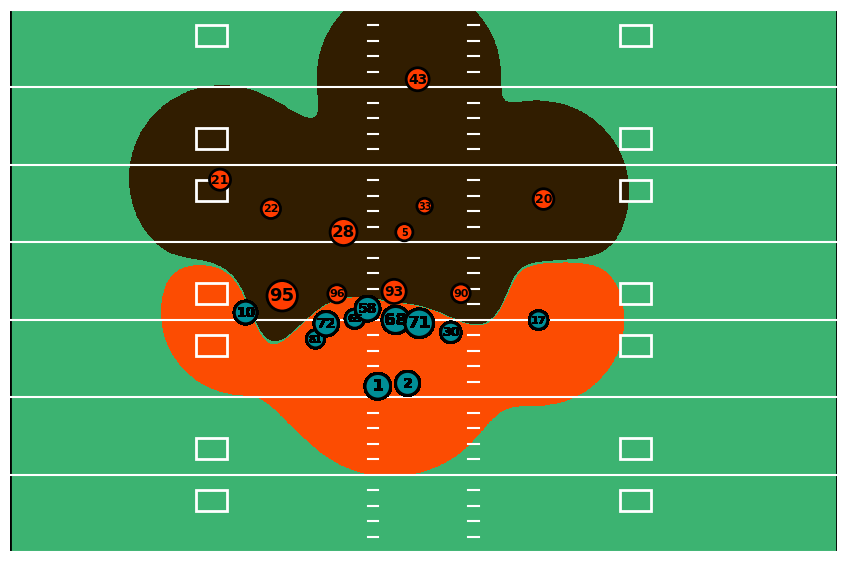

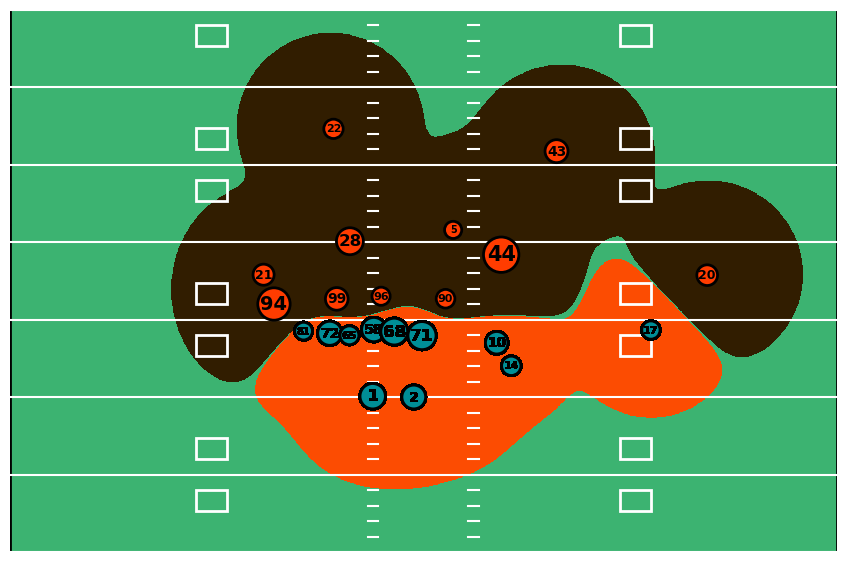

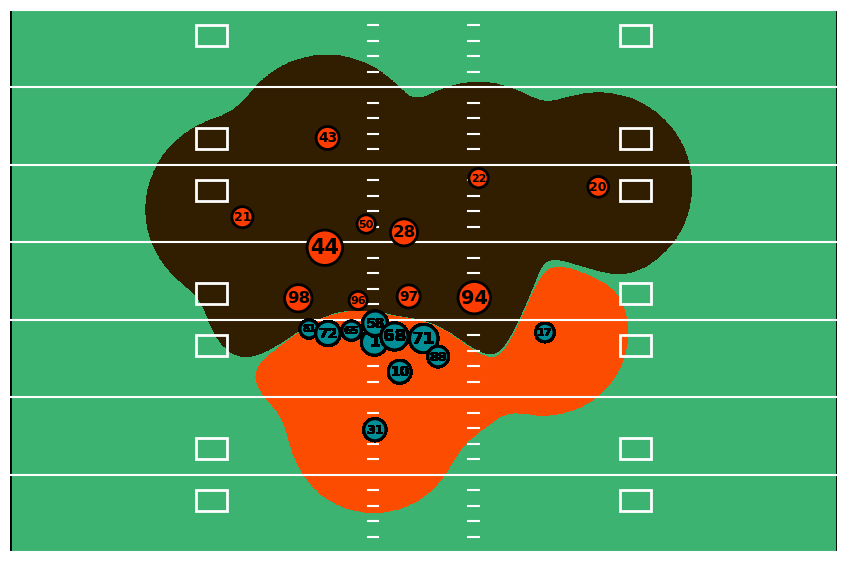

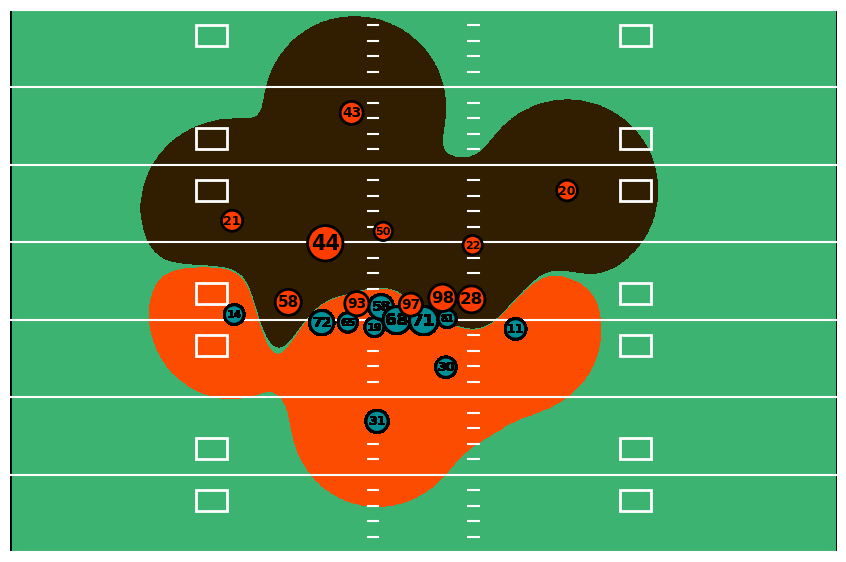

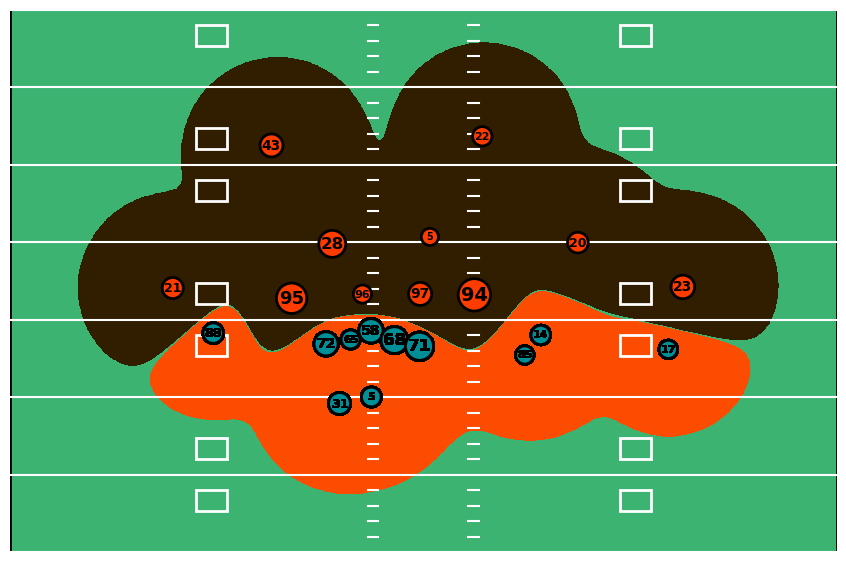

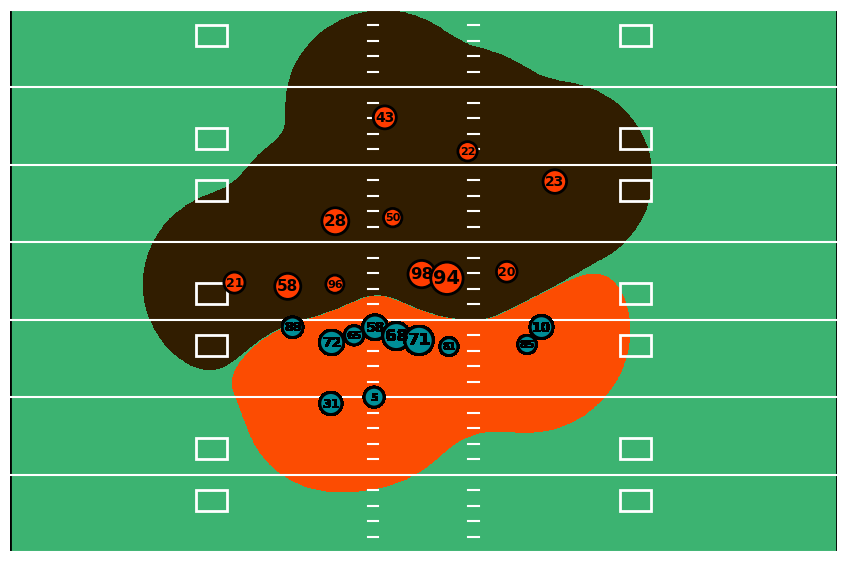

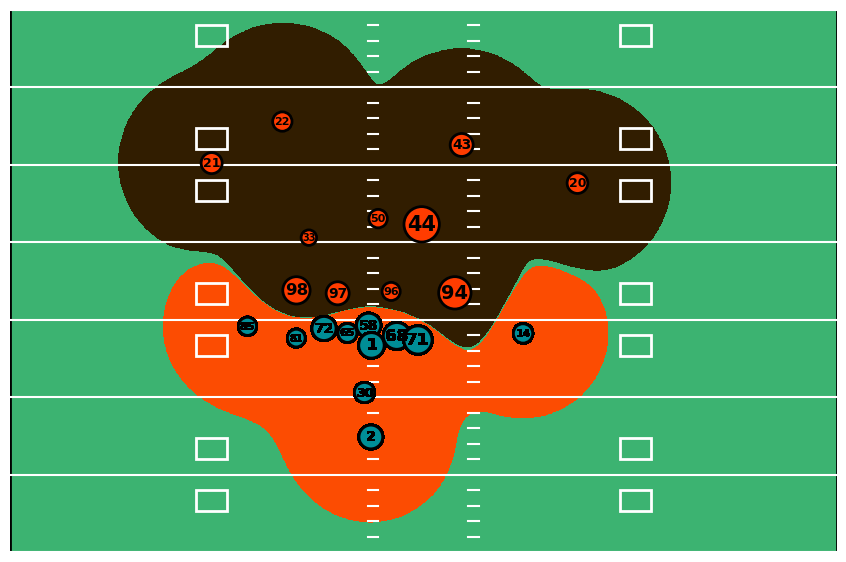

In [74]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            if str(size) == 'nan':
                size = .7
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                if pos in ['T', 'G', 'C']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            else:
                if pos in ['DT', 'DE', 'NT']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig(prefix + '/testfig/best/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [65]:
size

0.24399531303183702

In [66]:
ofdf_mean

O_Label  \
0         0   
1        30   
2        26   
3         4   
4        20   
5        33   
6        27   
7        17   
8        24   
9        31   
10       19   
11        2   
12       18   
13       22   
14        3   
15        6   
16        5   
17       23   
18        9   
19       28   
20       16   
21       12   
22       14   
23       32   
24        1   
25       11   
26       10   
27        8   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[0.0002850422, 0.00026164827, 0.00027572134, 0.0002758277, 0.00029564128, 0.00026050096, 0.00026706187, 0.0003112279, 0.00026045897, 0.00023434211, 0.00027938557, 0.000615099, 0.0003008605, 0.00024610927, 0.0003254548, 0.00027683718, 0.00026634283, 0.00024624553, 0.00027545958, 0.00023492477, 0.0002406978, 0.00025304907, 0.00035660563, 0.00031836942, 0.00028083744, 0.00025615894, 0.00025994322, 0.00033116373, 0.00024340757, 0.00040912107, 0.00031601853, 0.00020891277, 0.0002906661, 0.000397...   
1   [[0.00024864587, 0.00028008502, 0.0002862773, 0.00028130892, 0.00028319826, 0.000274691, 0.00030327143, 0.00031994245, 0.00025723377, 0.00021699381, 0.0002906574, 0.0006099141, 0.00027532305, 0.00024404844, 0.00031961233, 0.00028701045, 0.0002649974, 0.00023869194, 0.0002931156, 0.00025641656, 0.00024601683, 0.00026866424, 0.0003293756, 0.0003212397, 0.00032519878, 0.00028312398, 0.0002550254, 0.0003370659, 0.00022323379, 0.00039231847, 0.00030710507, 0.00022122594, 0.0002995052, 0.000374665...   
2   [[0.0002617206, 0.00026080443, 0.00026792943, 0.00026972275, 0.00028940942, 0.00026552944, 0.00029005294, 0.0002991073, 0.00023687274, 0.00021889355, 0.00027244163, 0.00058972393, 0.00027603243, 0.00024263738, 0.00031638308, 0.00027609547, 0.0002656396, 0.00024569282, 0.00028550913, 0.00024152252, 0.00022554149, 0.0002728241, 0.00030069493, 0.00031110813, 0.00030124446, 0.00025765793, 0.00024287954, 0.00034208022, 0.00022154434, 0.00040340665, 0.0002955152, 0.00020444141, 0.00027998327, 0.00...   
3   [[0.00025553975, 0.00026677444, 0.00028218524, 0.0002749834, 0.00029875268, 0.00027557762, 0.0002957457, 0.00031514087, 0.00024490486, 0.00022279698, 0.00028726106, 0.00062344305, 0.00026950394, 0.00024799892, 0.00032466455, 0.00028144525, 0.00027225044, 0.00023907093, 0.0002980157, 0.00025005237, 0.00022971262, 0.00027918804, 0.0003161315, 0.00032712982, 0.00031705512, 0.0002777745, 0.00025127296, 0.00034563444, 0.00022308381, 0.0004079158, 0.0003075399, 0.00021681946, 0.00029194567, 0.0003...   
4   [[0.00027198638, 0.00024396853, 0.00027353648, 0.00026979865, 0.00026829747, 0.00026315154, 0.0002714539, 0.0003131228, 0.00025708604, 0.0002208538, 0.0002685819, 0.0005491893, 0.0002896916, 0.00022536583, 0.0003284103, 0.00027150824, 0.00026112958, 0.00024269626, 0.0002656681, 0.00022423881, 0.00024900681, 0.00023867852, 0.00035710155, 0.00030608103, 0.00027750907, 0.00025308074, 0.00024845178, 0.00033495118, 0.00022746701, 0.00039227004, 0.00030670137, 0.00019440512, 0.00028634284, 0.00038...   
5   [[0.0002611952, 0.00028944106, 0.00027893577, 0.0002768572, 0.00030241843, 0.00026798906, 0.0002738122, 0.00031526148, 0.00025829277, 0.00022593398, 0.00025498503, 0.0006236081, 0.00030817933, 0.00025042822, 0.0003459258, 0.00029921246, 0.0002690222, 0.00025669293, 0.00026940717, 0.00024886985, 0.00026178447, 0.00024259978, 0.0003549718, 0.0003300687, 0.00028190544, 0.00024856528, 0.00027374888, 0.0003123457, 0.00023547225, 0.0003992205, 0.0003080624, 0.00020581059, 0.00030900261, 0.00038998...   
6   [[0.00026655168

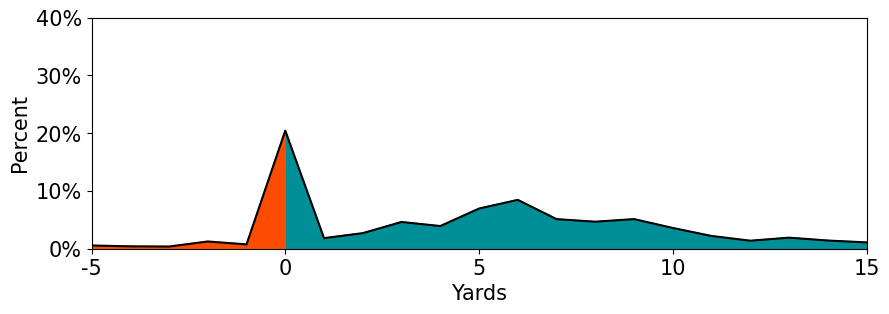

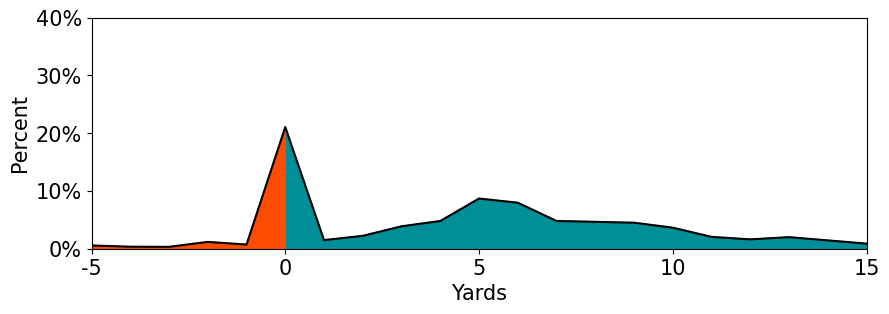

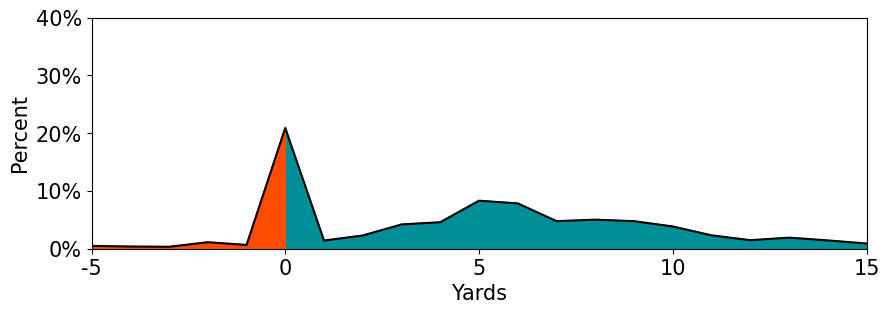

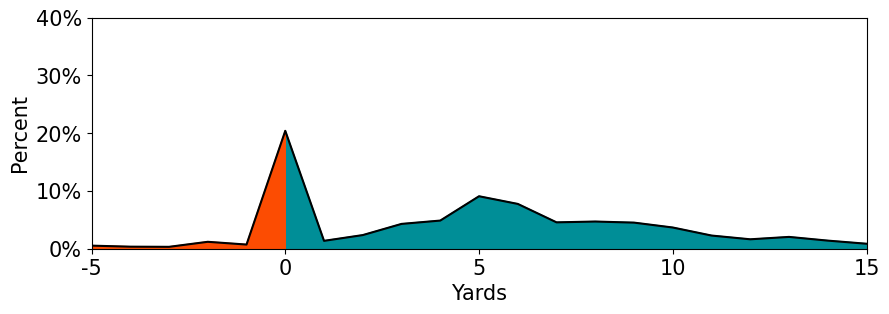

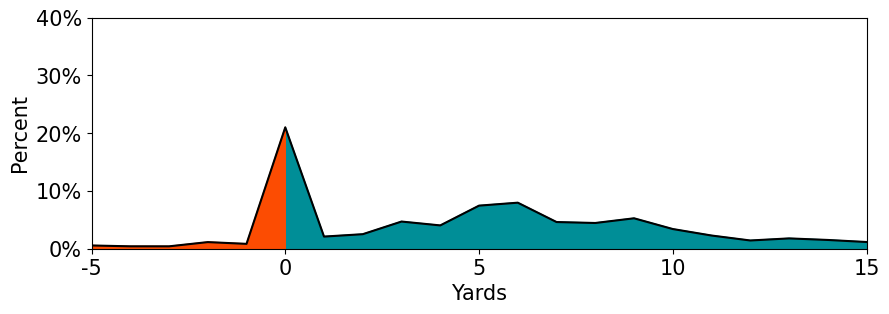

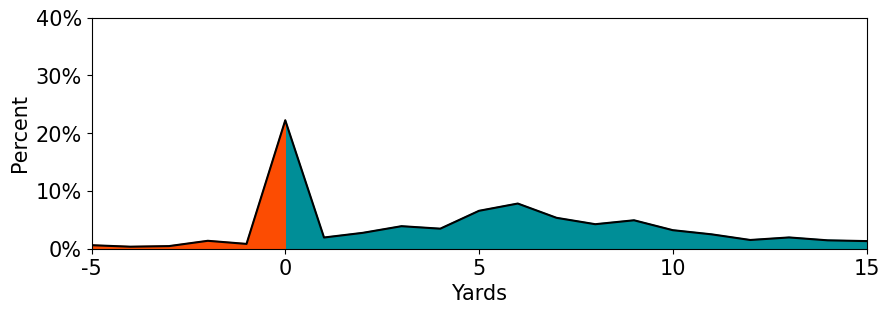

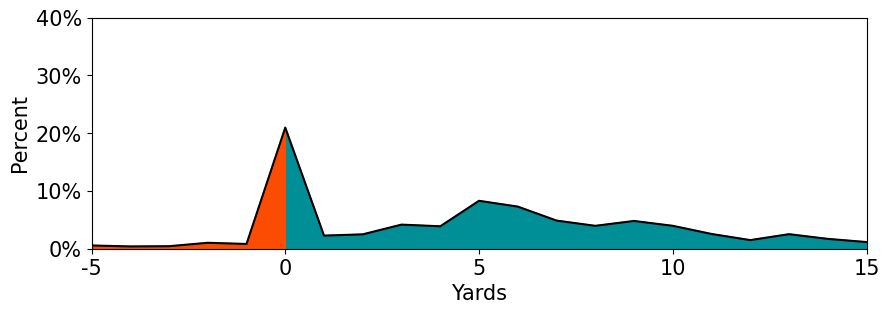

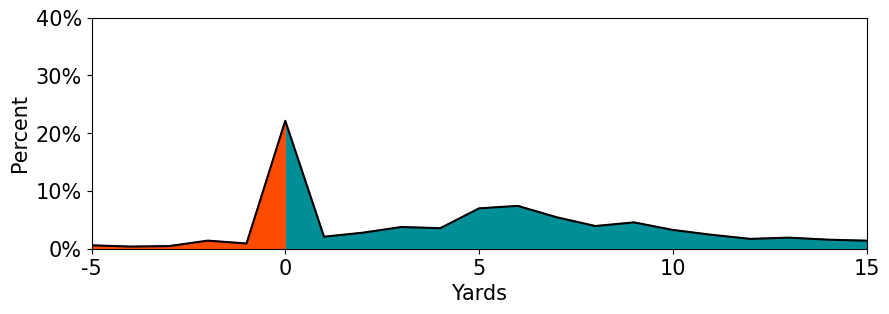

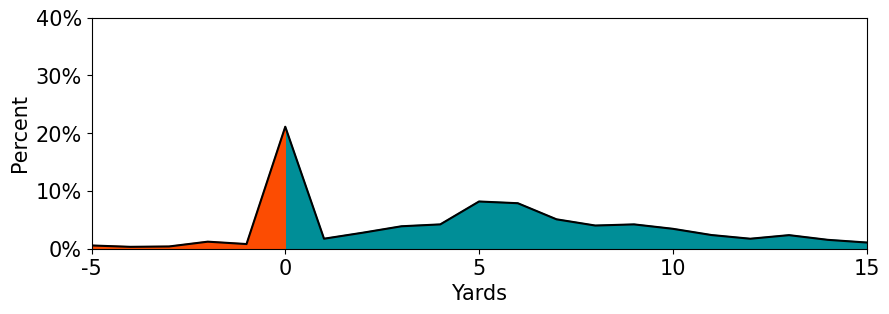

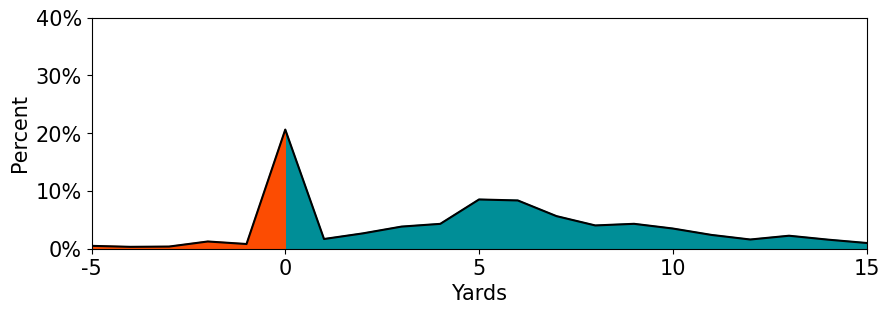

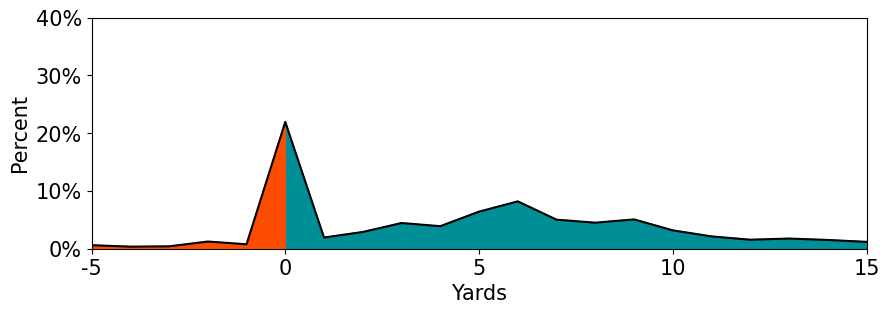

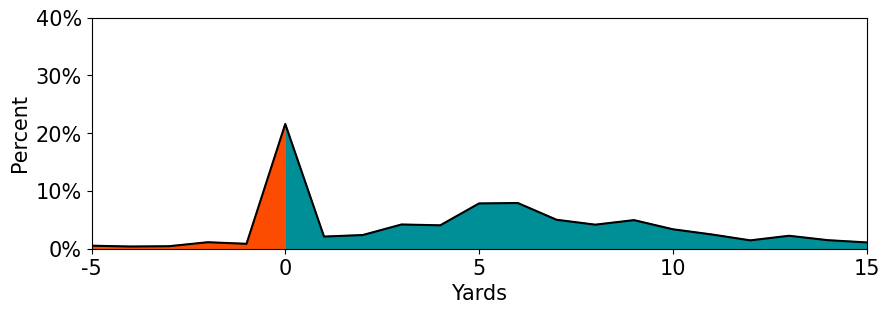

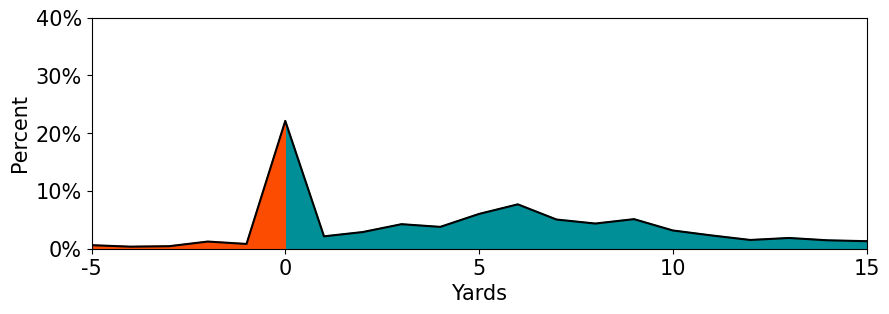

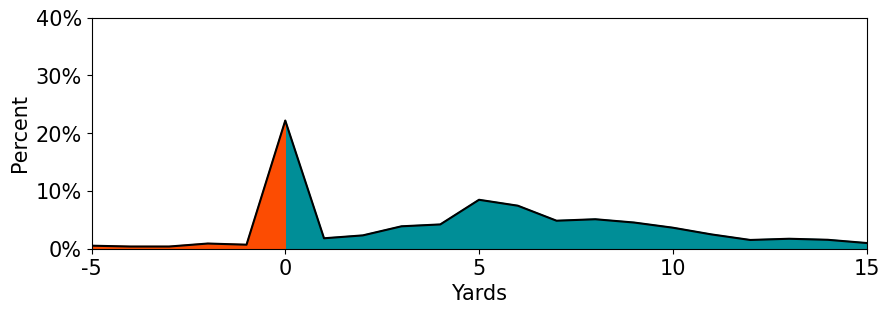

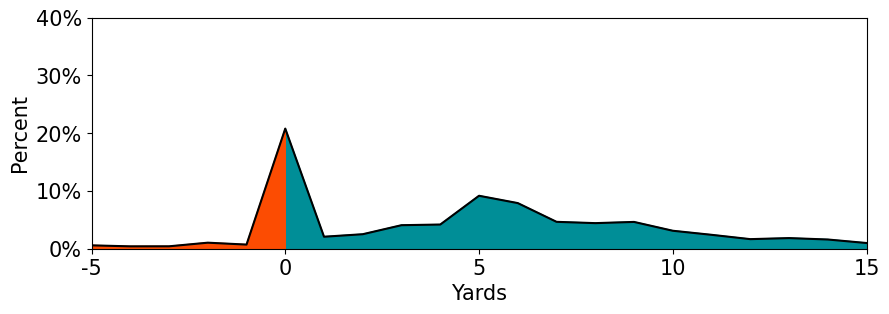

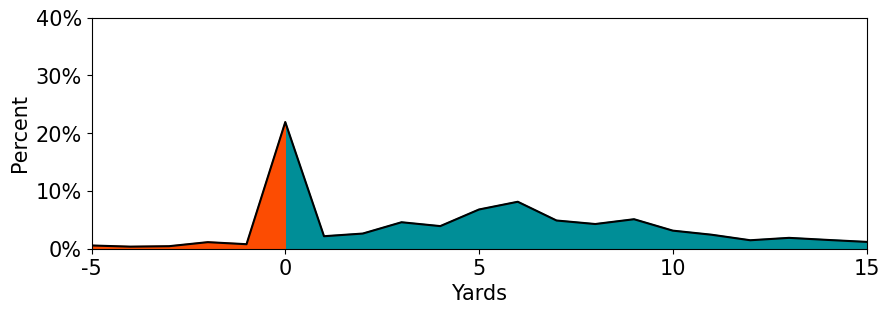

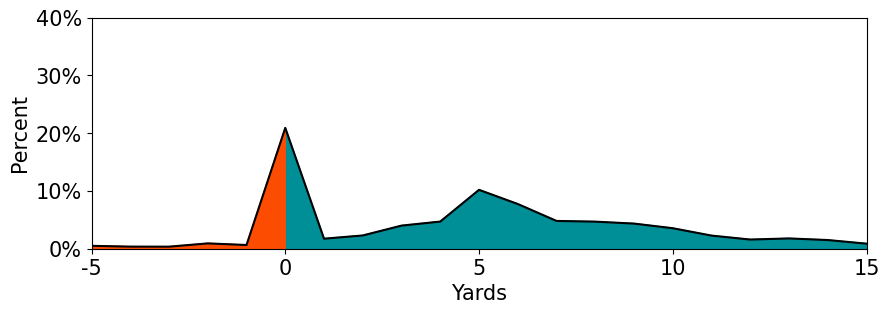

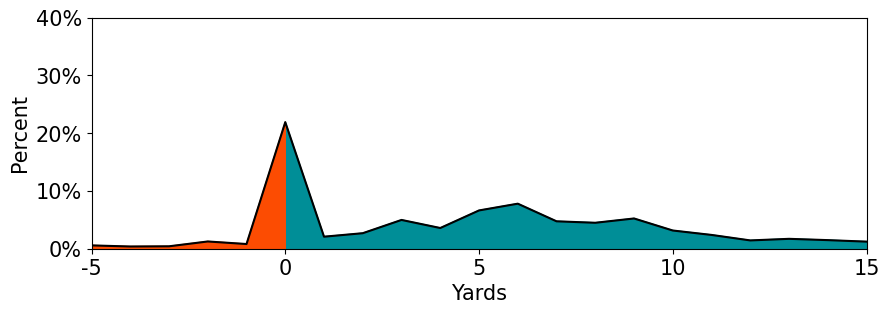

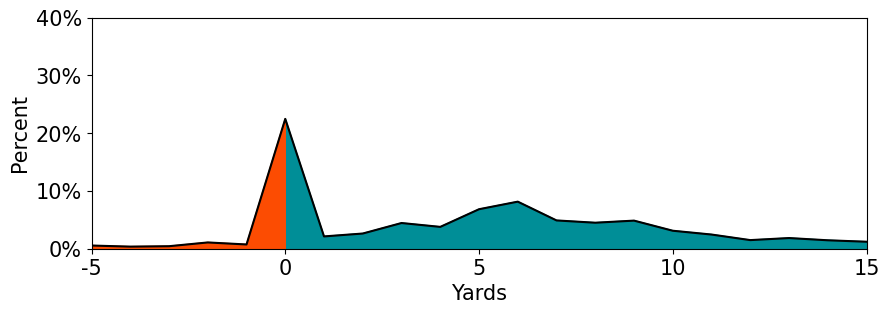

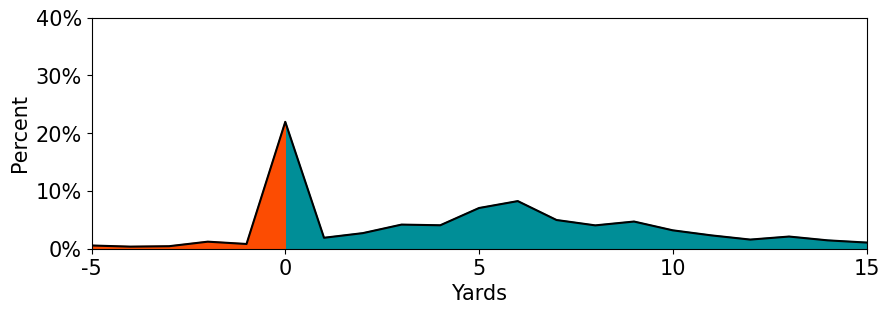

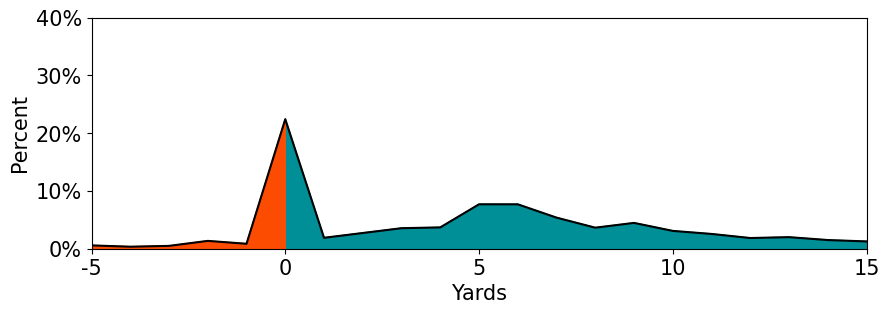

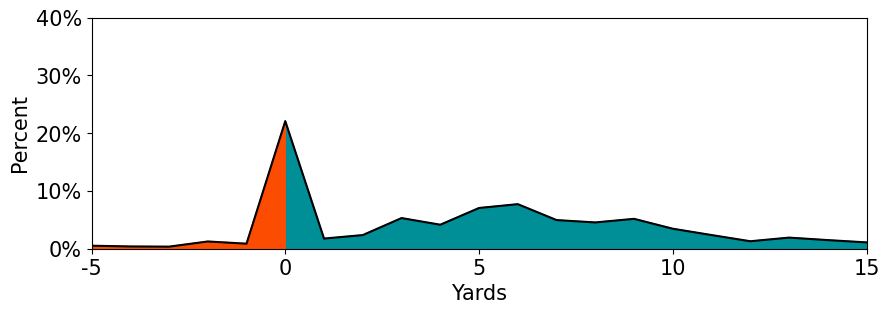

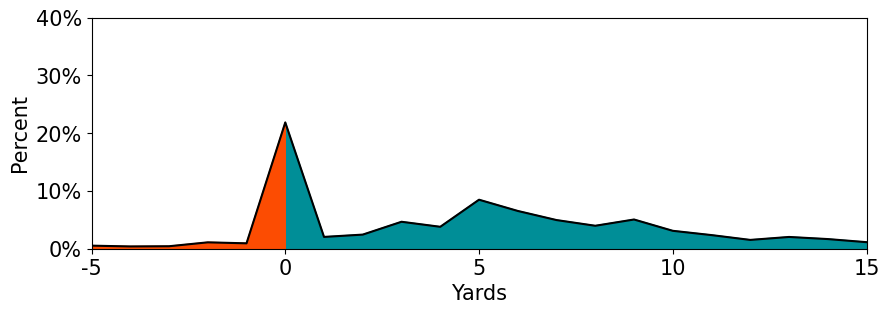

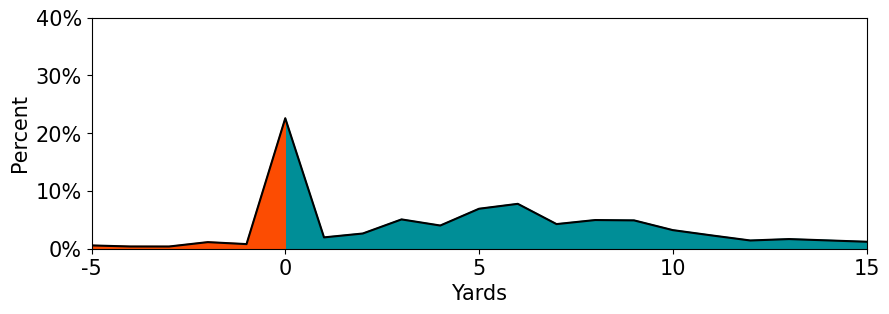

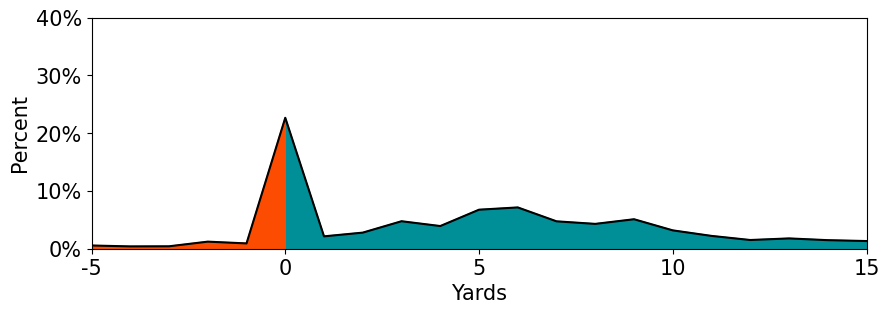

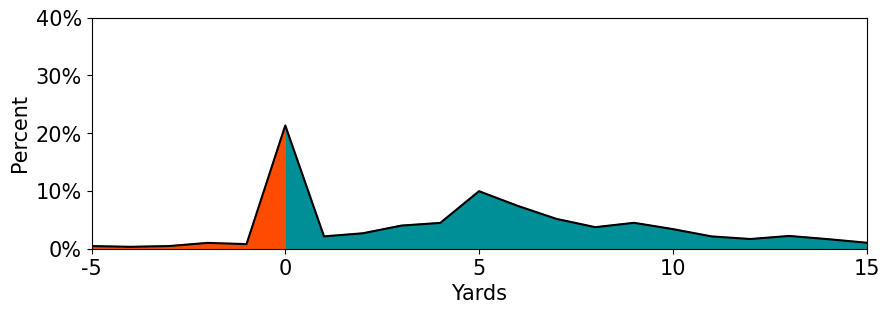

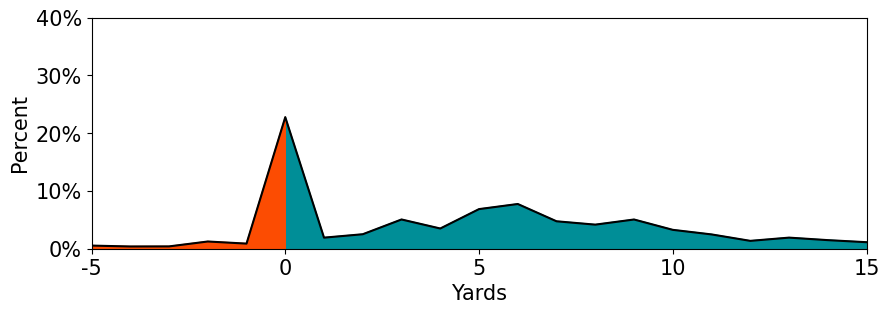

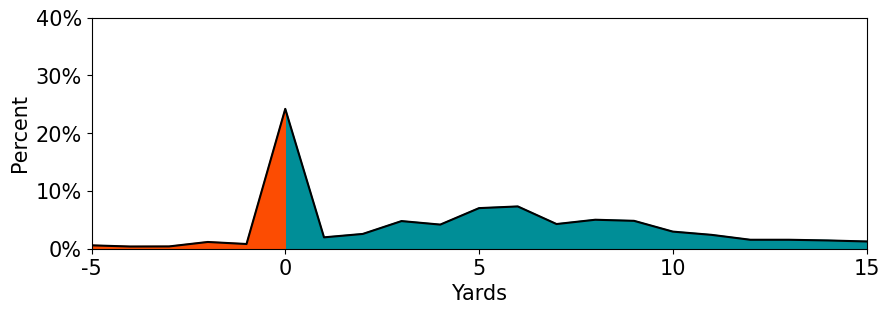

In [75]:
for i in range(len(ofdf_mean)):  
    bdb.plt.figure(figsize=(10, 3))  # Optional: Set figure size01
    bdb.plt.ylim([0, .4])
    bdb.plt.xlim([94, 114])
    new_x_ticks = [94, 99, 104, 109, 114]
    new_x_labels = [-5, 0, 5, 10, 15]
    new_y_ticks = [0, .1, .2, .3, .4]
    new_y_labels = ['0%', '10%', '20%', '30%', '40%']
    plt.xlabel("Yards", fontsize=15)  # X-axis label font size
    plt.ylabel("Percent", fontsize=15)  # Y-axis label font size
    plt.xticks(fontsize=15)  # X-tick labels font size
    plt.yticks(fontsize=15)
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = ofdf_mean['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 99), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 99), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.savefig(prefix + '/testfig/line_charts/testfig-O-' + str(ofdf_mean['O_Label'].iloc[i]) + '-D' + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
    bdb.plt.show()

In [68]:
play_stats1=pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
play_stats1['playId'] = play_stats1['gameId'].astype(str) + play_stats1['playId'].astype(str).str.zfill(4)
play_stats1['playId'] = play_stats1['playId'].astype('int64')

In [69]:
predicted_plays_w_coverage = pd.merge(predicted_plays, play_stats1[['playId', 'pff_passCoverage']], how = 'left', left_on = 'PlayIdD', right_on = 'playId').reset_index(drop=True)

In [83]:
predicted_plays_w_coverage.loc[(predicted_plays_w_coverage['O_Label'] == 4)].reset_index(drop=True)

GameId          PlayId  Team          X          Y     S     A   Dis  \
0   2022103100  20221031003508  home  61.260002  30.260000  0.58  0.92  0.06   
1   2022103100  20221031003508  home  66.060002  26.070000  0.02  0.17  0.00   
2   2022103100  20221031003508  home  61.250002  16.960000  0.55  0.61  0.06   
3   2022103100  20221031003508  home  75.790002  32.570000  0.76  0.79  0.08   
4   2022103100  20221031003508  home  61.220002  26.580000  0.60  0.24  0.09   
5   2022103100  20221031003508  home  64.870002  44.200000  1.51  0.46  0.15   
6   2022103100  20221031003508  home  66.300002  19.120000  1.02  0.70  0.10   
7   2022103100  20221031003508  home  71.800002  15.820000  0.54  1.28  0.06   
8   2022103100  20221031003508  home  61.730002  20.020000  0.60  1.15  0.06   
9   2022103100  20221031003508  home  65.600002  32.650000  0.61  0.74  0.06   
10  2022103100  20221031003508  home  65.440002   8.780000  1.99  0.07  0.20   
11  2022092900  20221031003508  away  58.520002  20.669999  0.02  0.36  0.00   
12  2022092900  20221031003508  away  55.120002  23.269999  0.00  0.00  0.00   
13  2022092900  20221031003508  away  59.290002  10.519999  0.00  0.00  0.02   
14  2022092900  20221031003508  away  58.290002  17.939999  0.00  0.00  0.00   
15  2022092900  20221031003508  away  59.370002  23.369999  0.61  2.35  0.05   
16  2022092900  20221031003508  away  54.580002  25.989999  0.00  0.00  0.00   
17  2022092900  20221031003508  away  58.180002  43.279999  0.00  0.00  0.01   
18  2022092900  20221031003508  away  58.460002  26.669999  0.19  1.33  0.02   
19  2022092900  20221031003508  away  59.070002  24.739999  0.47  1.45  0.04   
20  2022092900  20221031003508  away  58.960002  35.329999  0.00  0.00  0.00   
21  2022092900  20221031003508  away  58.910002  21.999999  0.10  0.78  0.01   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -3.272143  41227.0      OLB        30        4   0.333870            CIN   
1  -3.367962  43341.0      ILB        30        4   0.333870            CIN   
2  -3.143338  44813.0       DE        30        4   0.333870            CIN   
3   0.164061  44903.0       SS        30        4   0.333870            CIN   
4  -2.965314  46098.0       DT        30        4   0.333870            CIN   
5  -0.050440  47829.0       CB        30        4   0.333870            CIN   
6  -3.938335  47863.0      OLB        30        4   0.333870            CIN   
7  -3.617718  52452.0       SS        30        4   0.333870            CIN   
8  -3.277728  52496.0       DT        30        4   0.333870            CIN   
9  -2.519034  53455.0       CB        30        4   0.333870            CIN   
10  0.084299  54533.0       CB        30        4   0.333870            CIN   
11 -2.671226  40023.0        T        19        3   0.867574            MIA   
12 -5.571266  41258.0       QB        19        3   0.867574            MIA   
13 -6.419321  43454.0       WR        19        3   0.867574            MIA   
14 -5.123763  46111.0       TE        19        3   0.867574            MIA   
15 -2.724983  46119.0        C        19        3   0.867574            MIA   
16 -7.057064  46203.0       RB        19        3   0.867574            MIA   
17 -3.903952  46671.0       WR        19        3   0.867574            MIA   
18 -2.824117  47820.0        T        19        3   0.867574            MIA   
19 -2.769314  52447.0        G        19        3   0.867574            MIA   
20 -3.525740  53435.0       WR        19        3   0.867574            MIA   
21 -2.071706  53471.0        G        19        3   0.867574            MIA   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            CLE     2        10           CIN                   32   
1            CLE     2        10           CIN                   32   
2            CLE     2        10           CIN                   32   
3            CLE     2        10           CIN                   

In [71]:
play_stats1.loc[(play_stats1['playId'] == 20221002010749)]

gameId          playId  \
14752  2022100201  20221002010749   

                                                                                                      playDescription  \
14752  (2:11) (Shotgun) M.Mariota pass deep left to P.Hesse pushed ob at CLV 13 for 22 yards (M.Emerson) [I.Rochell].   

       quarter  down  yardsToGo possessionTeam defensiveTeam yardlineSide  \
14752        1     2         14            ATL           CLE          CLE   

       yardlineNumber gameClock  preSnapHomeScore  preSnapVisitorScore  \
14752              35     02:11                 3                    0   

      playNullifiedByPenalty  absoluteYardlineNumber  \
14752                      N                      75   

       preSnapHomeTeamWinProbability  preSnapVisitorTeamWinProbability  \
14752                       0.683317                          0.316683   

       expectedPoints offenseFormation receiverAlignment  playClockAtSnap  \
14752        3.036869            EMPTY               3x2              8.0   

      passResult  passLength  targetX  targetY  playAction dropbackType  \
14752          C        17.0    91.51    51.23       False     SCRAMBLE   

       dropbackDistance passLocationType  timeToThrow  timeInTackleBox  \
14752              2.22     OUTSIDE_LEFT        5.939              3.5   

       timeToSack passTippedAtLine unblockedPressure qbSpike  qbKneel qbSneak  \
14752         NaN            False             False   False        0     NaN   

      rushLocationType  penaltyYards  prePenaltyYardsGained  yardsGained  \
14752              NaN           NaN                     22           22   

       homeTeamWinProbabilityAdded  visitorTeamWinProbilityAdded  \
14752                     0.034643                     -0.034643   

       expectedPointsAdded  isDropback pff_runConceptPrimary  \
14752             2.100005        True                   NaN   

      pff_runConceptSecondary  pff_runPassOption pff_passCoverage pff_manZone  
14752                     NaN                  0          Cover-3        Zone

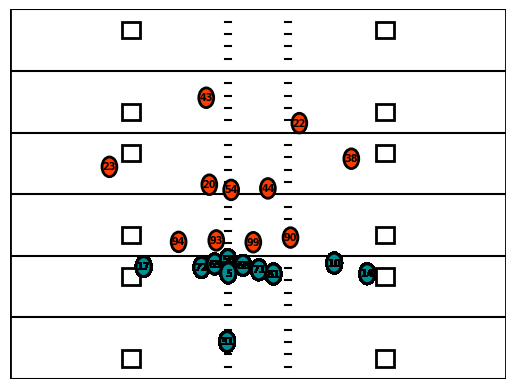

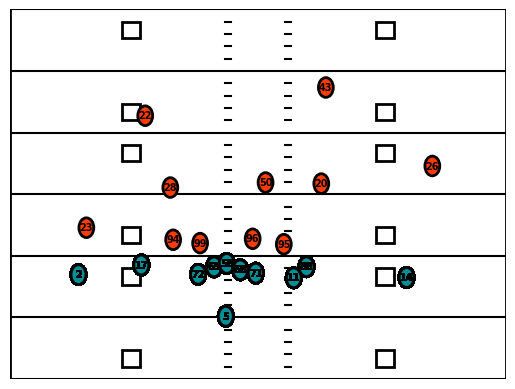

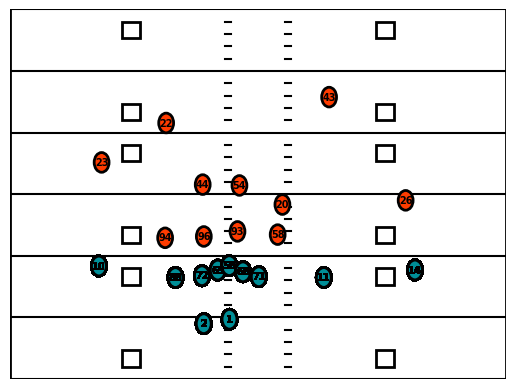

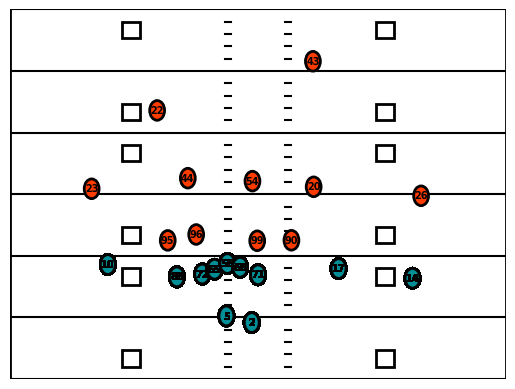

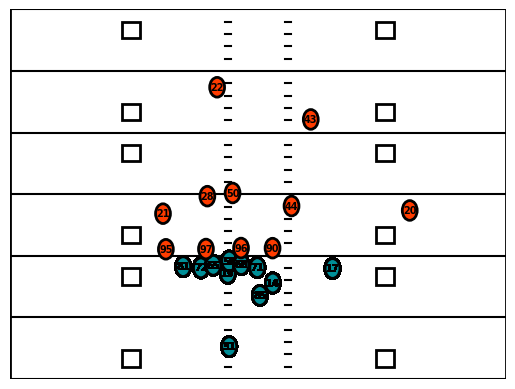

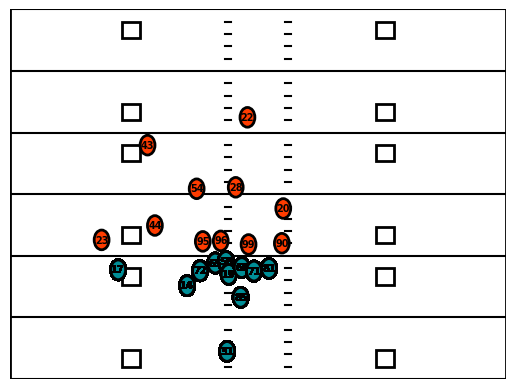

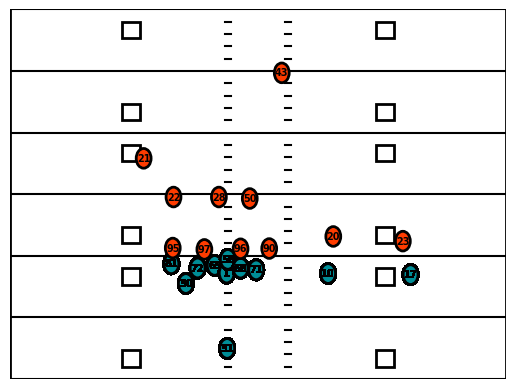

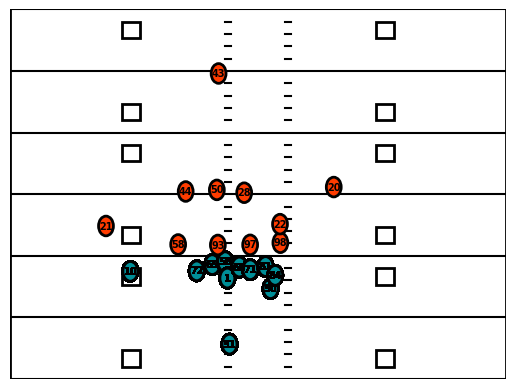

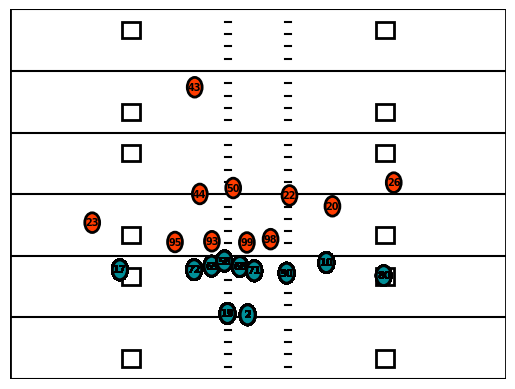

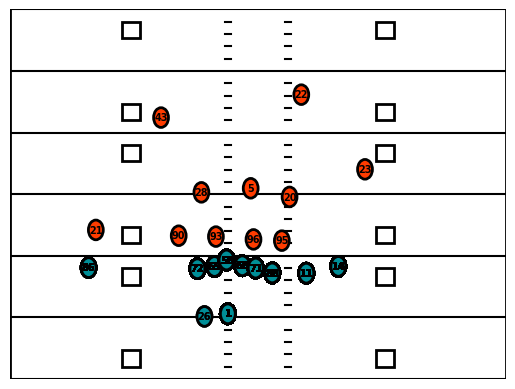

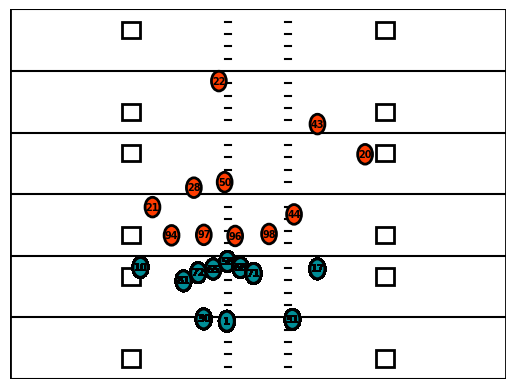

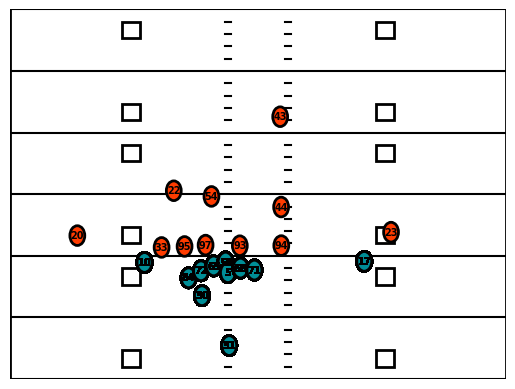

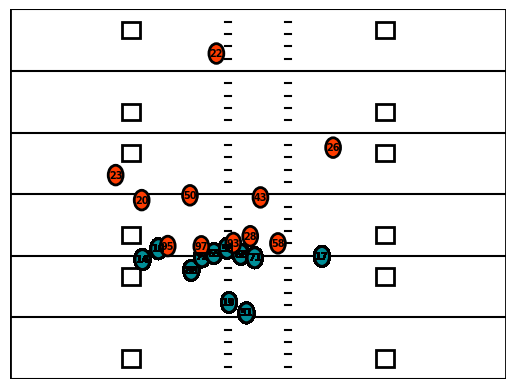

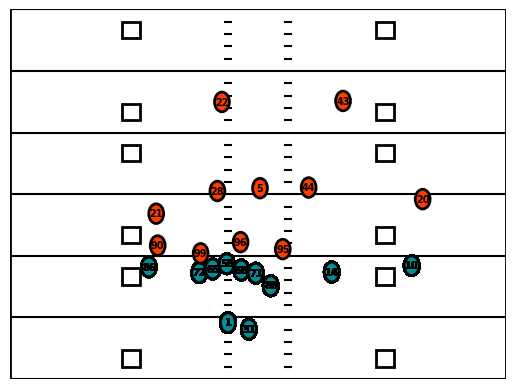

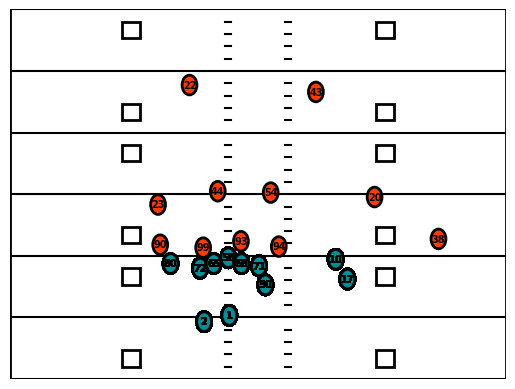

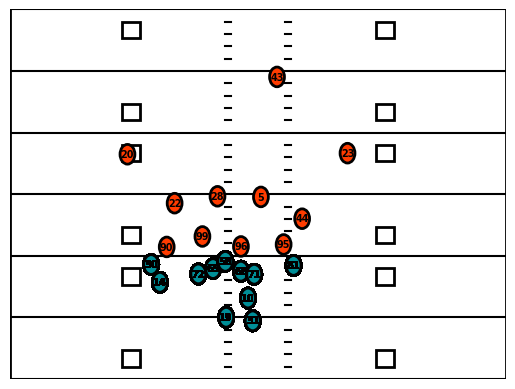

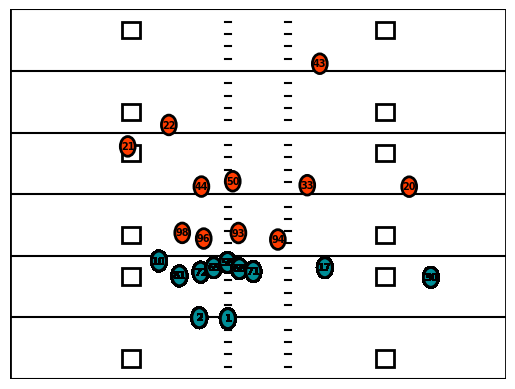

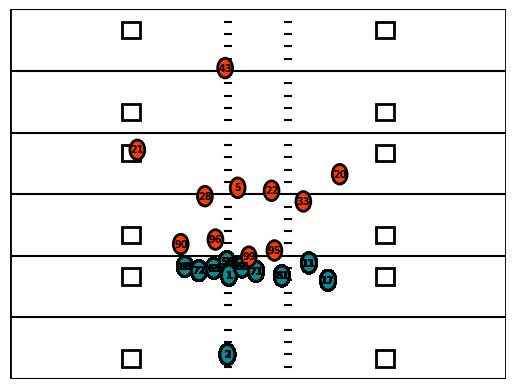

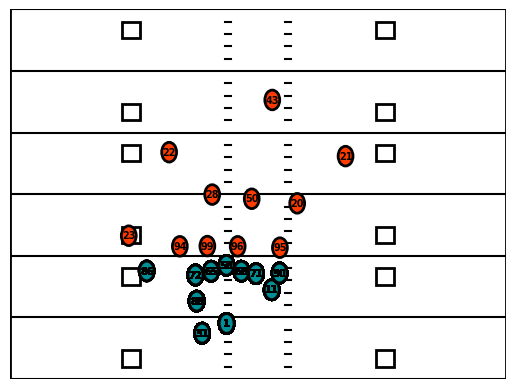

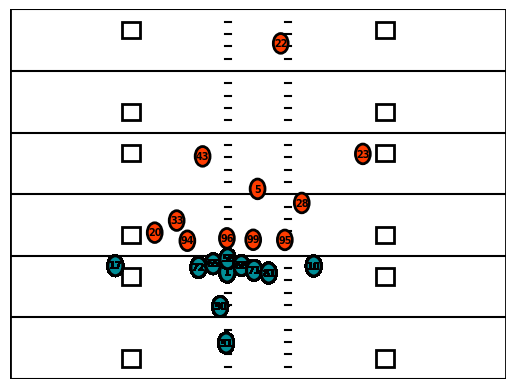

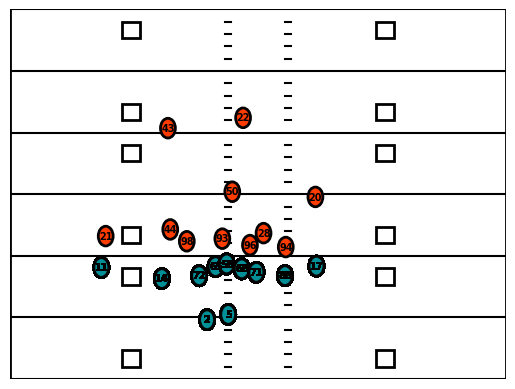

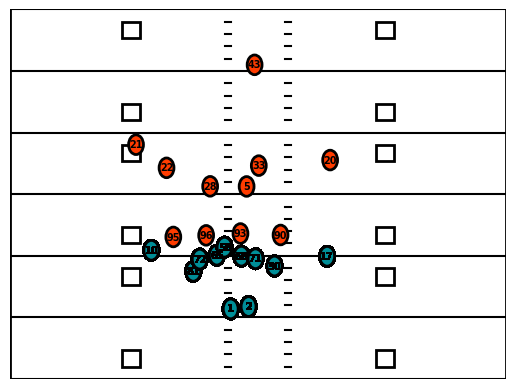

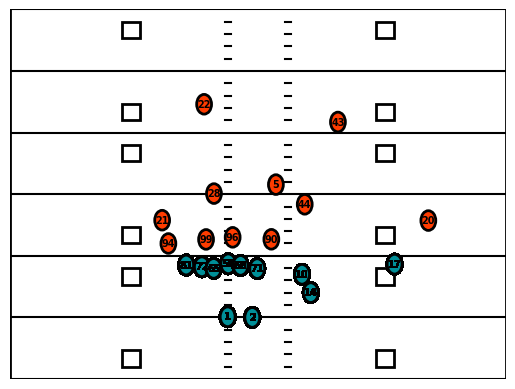

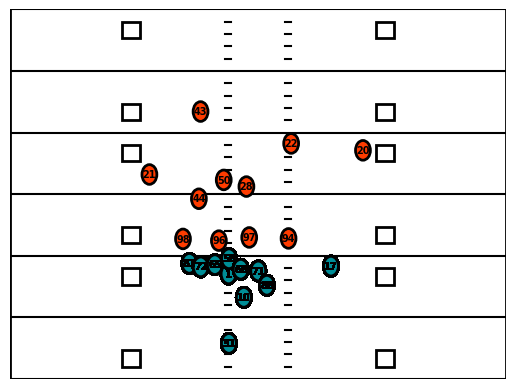

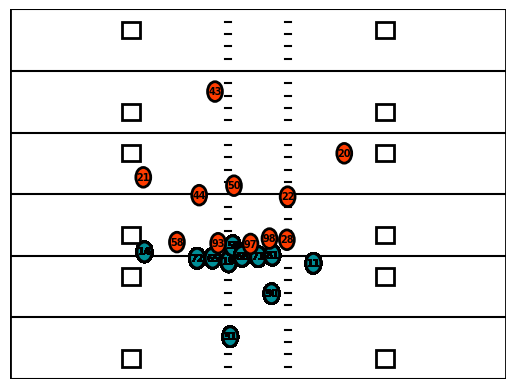

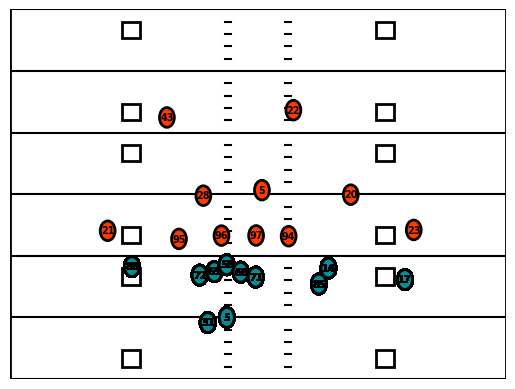

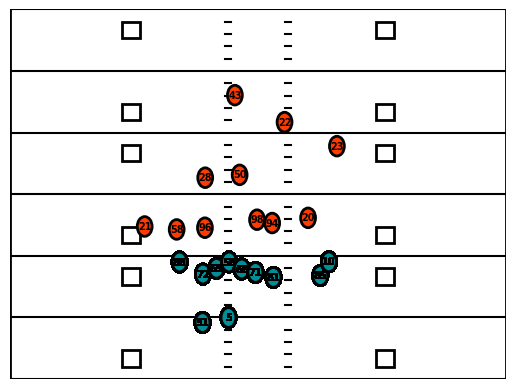

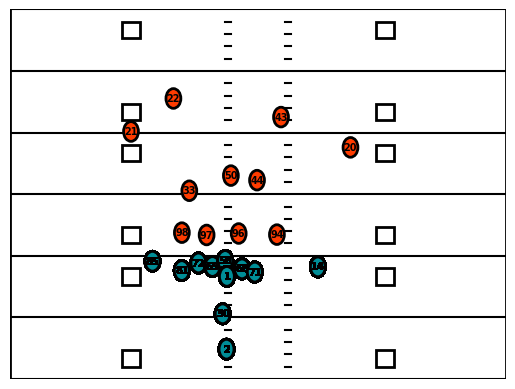

In [73]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots()
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        #ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')
            else:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')

        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-10, 20) 
        bdb.plt.savefig(prefix + '/testfig/drawing/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [76]:
play_stats1=pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
play_stats1['playId'] = play_stats1['gameId'].astype(str) + play_stats1['playId'].astype(str).str.zfill(4)
play_stats1['playId'] = play_stats1['playId'].astype('int64')

In [77]:
predicted_plays_w_coverage = pd.merge(predicted_plays, play_stats1[['playId', 'pff_passCoverage']], how = 'left', left_on = 'PlayIdD', right_on = 'playId').reset_index(drop=True)

In [80]:
predicted_plays_w_coverage.loc[(predicted_plays_w_coverage['O_Label'] == 4)].reset_index(drop=True)

GameId          PlayId  Team          X          Y     S     A   Dis  \
0   2022103100  20221031003508  home  61.260002  30.260000  0.58  0.92  0.06   
1   2022103100  20221031003508  home  66.060002  26.070000  0.02  0.17  0.00   
2   2022103100  20221031003508  home  61.250002  16.960000  0.55  0.61  0.06   
3   2022103100  20221031003508  home  75.790002  32.570000  0.76  0.79  0.08   
4   2022103100  20221031003508  home  61.220002  26.580000  0.60  0.24  0.09   
5   2022103100  20221031003508  home  64.870002  44.200000  1.51  0.46  0.15   
6   2022103100  20221031003508  home  66.300002  19.120000  1.02  0.70  0.10   
7   2022103100  20221031003508  home  71.800002  15.820000  0.54  1.28  0.06   
8   2022103100  20221031003508  home  61.730002  20.020000  0.60  1.15  0.06   
9   2022103100  20221031003508  home  65.600002  32.650000  0.61  0.74  0.06   
10  2022103100  20221031003508  home  65.440002   8.780000  1.99  0.07  0.20   
11  2022092900  20221031003508  away  58.520002  20.669999  0.02  0.36  0.00   
12  2022092900  20221031003508  away  55.120002  23.269999  0.00  0.00  0.00   
13  2022092900  20221031003508  away  59.290002  10.519999  0.00  0.00  0.02   
14  2022092900  20221031003508  away  58.290002  17.939999  0.00  0.00  0.00   
15  2022092900  20221031003508  away  59.370002  23.369999  0.61  2.35  0.05   
16  2022092900  20221031003508  away  54.580002  25.989999  0.00  0.00  0.00   
17  2022092900  20221031003508  away  58.180002  43.279999  0.00  0.00  0.01   
18  2022092900  20221031003508  away  58.460002  26.669999  0.19  1.33  0.02   
19  2022092900  20221031003508  away  59.070002  24.739999  0.47  1.45  0.04   
20  2022092900  20221031003508  away  58.960002  35.329999  0.00  0.00  0.00   
21  2022092900  20221031003508  away  58.910002  21.999999  0.10  0.78  0.01   

         Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  -3.272143  41227.0      OLB        30        4   0.333870            CIN   
1  -3.367962  43341.0      ILB        30        4   0.333870            CIN   
2  -3.143338  44813.0       DE        30        4   0.333870            CIN   
3   0.164061  44903.0       SS        30        4   0.333870            CIN   
4  -2.965314  46098.0       DT        30        4   0.333870            CIN   
5  -0.050440  47829.0       CB        30        4   0.333870            CIN   
6  -3.938335  47863.0      OLB        30        4   0.333870            CIN   
7  -3.617718  52452.0       SS        30        4   0.333870            CIN   
8  -3.277728  52496.0       DT        30        4   0.333870            CIN   
9  -2.519034  53455.0       CB        30        4   0.333870            CIN   
10  0.084299  54533.0       CB        30        4   0.333870            CIN   
11 -2.671226  40023.0        T        19        3   0.867574            MIA   
12 -5.571266  41258.0       QB        19        3   0.867574            MIA   
13 -6.419321  43454.0       WR        19        3   0.867574            MIA   
14 -5.123763  46111.0       TE        19        3   0.867574            MIA   
15 -2.724983  46119.0        C        19        3   0.867574            MIA   
16 -7.057064  46203.0       RB        19        3   0.867574            MIA   
17 -3.903952  46671.0       WR        19        3   0.867574            MIA   
18 -2.824117  47820.0        T        19        3   0.867574            MIA   
19 -2.769314  52447.0        G        19        3   0.867574            MIA   
20 -3.525740  53435.0       WR        19        3   0.867574            MIA   
21 -2.071706  53471.0        G        19        3   0.867574            MIA   

   DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0            CLE     2        10           CIN                   32   
1            CLE     2        10           CIN                   32   
2            CLE     2        10           CIN                   32   
3            CLE     2        10           CIN                   